In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats
import collections
import os
import ast
from scipy.stats import pearsonr
from pathlib import Path
import itertools
from itertools import repeat
import re
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42

/home/labs/barkailab/aileenc/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## The color palette:

In [2]:
n = 256  
c = 0.4
base_cmap = plt.get_cmap("Greens")  
colors = (1. - c) * base_cmap(np.linspace(0., 1., n)) + c * np.ones((n, 4)) 
pastel_cmap = mcolors.LinearSegmentedColormap.from_list("PastelGreens", colors, N=n)
norm = mcolors.Normalize(vmin=0, vmax=1)

## File loading:

In [3]:
WT_system_data = pd.read_pickle('WT_system_strains.gz')
d12_system_data = pd.read_pickle('d12_Fusion_system.gz')
WT_d12 = pd.read_pickle('WT_d12_strains.gz')
Repeats = pd.read_pickle('experimental_repeats.gz')
Flocculation = pd.read_pickle('flocculation_results.gz')

In [4]:
gp = pd.read_csv('geneinfo_params.csv', index_col=0)
df_for_sp = pd.read_csv('frame_for_spcalc.csv', index_col=4)

In [5]:
folder_path = os.getcwd()+'/'
promoter_files = [f for f in os.listdir(folder_path) if f.endswith('2000bp_signals.gz')]
file_dict = {}
for file in promoter_files:
    file_dict[file] = folder_path+file
    data = [{'file_name': k, 'path': v} for k, v in file_dict.items()]

# Create the DataFrame
promoter_binding_signals = pd.DataFrame(data)
promoter_binding_signals.set_index('file_name', inplace=True)
promoter_binding_signals=promoter_binding_signals.T

## Targets:

In [6]:
med15_top_targets = ['YFR052C-A', 'HXK1', 'TPS2', 'GIP2', 'HOR7', 'HSP12', 'EGO4', 'PGM2', 'HSP26', 'BDH2', 'MDJ1', 'UGP1', 'TMA10', 'HXT7', 'SNF11', 'YMR194C-A', 'ALD6', 'GIS1', 'IPT1', 'MRK1', 'ICY1', 'CIT2', 'ZWF1', 'RAS2', 'RTC3', 'TDH1', 'ISF1', 'YNL193W', 'YNL194C', 'GDH1', 'YGR161W-C', 'RTS3', 'USV1', 'CTT1', 'RSM10', 'GAC1', 'NCE102', 'DDR2', 'FMP45', 'SED1', 'GSY2', 'JEN1', 'YPR160W-A', 'GPH1', 'RGI1', 'YGR067C', 'CMC4', 'GSY1', 'DIP5', 'SPO24', 'LEE1', 'LGE1', 'YNL097W-A', 'SUR1', 'YDL124W', 'HNT1', 'YBR085C-A', 'VHS1', 'CUE4', 'TSL1', 'TDA1', 'GLN1', 'YDR133C', 'CCW22', 'ADP1', 'PGK1', 'ZRT1', 'CYB2', 'ALD3', 'SIT4', 'NNR2', 'MCR1', 'RGI2', 'MIG1', 'TYE7', 'VHR1', 'ALD4', 'IXR1', 'SPG4', 'YGR122W', 'PNS1', 'ENO1', 'STP4', 'GLC3', 'YAP1802', 'MPC3', 'HHF2', 'HHT2', 'TPO4', 'MOD5', 'SPI1', 'YNL144C', 'BAG7', 'TDH3', 'YGL036W', 'PNC1', 'APJ1', 'VPS36', 'YLR415C', 'COX26', 'PHM7', 'ADR1', 'GLK1', 'AGP1', 'HAS1', 'YMR320W', 'FMP40', 'PIL1', 'YLR257W', 'CIP1', 'HST2', 'GRE1', 'YGR121W-A', 'MEP1', 'PAL2', 'YBR126W-B', 'MEO1', 'TPS1', 'WTM1', 'HAP4', 'PEA2', 'YGP1', 'YJR115W', 'PRR2', 'FMP16', 'PBI2', 'SUC2', 'FBA1', 'STF2', 'HSP150', 'YMR206W', 'GLO1', 'FAA1', 'FET4', 'YPR148C', 'RSM7', 'SIP18', 'PAI3', 'MTH1', 'GSC2', 'TPH3', 'ECM3', 'HHT1', 'HHF1', 'ACS1', 'FLC2', 'PLB1', 'MMO1', 'PMP3', 'AIM17', 'NMA1', 'MNT2', 'ADH4', 'PUT4', 'ATO2', 'BAP2', 'RHO5', 'YMR196W', 'NQM1', 'PIG2', 'MNN4', 'DOT6', 'KTI12', 'HYP2', 'ZRT2', 'RIM4', 'PYC1', 'ANP1', 'GPG1', 'BAP3', 'HTB2', 'HTA2', 'PIR1', 'MHO1', 'PIR3', 'GPX1', 'IRA2', 'YGR146C-A', 'CYC3', 'YGR050C', 'FMP48', 'GPD1', 'PUN1', 'BMH1', 'CIT1', 'YNR001W-A', 'ATO3', 'HXK2', 'YCL042W', 'PDI1', 'TSA2', 'HXT5', 'YDR154C', 'CPR1', 'RPA14', 'UBX6', 'HTB1', 'GPP1', 'YIL055C', 'HTA1']

lost_in_dC = ['CYC3', 'FLC2', 'ACS1', 'BDH2', 'HTB2', 'HTA2', 'ACH1', 'HSP26', 'TPS1', 'YCL042W', 'PDI1', 'GPM2', 'GPD1', 'STP4', 'MRK1', 'YDL124W', 'HNT1', 'PRR2', 'FMP45', 'PST1', 'FMP16', 'TPS2', 'AFR1', 'HTB1', 'HTA1', 'VHS1', 'TSA2', 'GLC3', 'PIC2', 'GIP2', 'RGI1', 'PEA2', 'SPI1', 'PDA1', 'HSP12', 'MDJ1', 'GSY1', 'HXK1', 'YGL036W', 'PNC1', 'GPG1', 'ZRT1', 'ADH4', 'MNT2', 'STF2', 'NQM1', 'YGR067C', 'PIL1', 'CTT1', 'MEP1', 'PCT1', 'YCH1', 'TDA10', 'YAP1802', 'MPC3', 'RIE1', 'ENO1', 'PXR1', 'YOR1', 'AIM17', 'RTC3', 'HXT5', 'PAL2', 'YAP1801', 'MPC2', 'PIG2', 'PCL7', 'MMF1', 'TPH3', 'KAR2', 'TAD2', 'UBX6', 'TDH1', 'LOG1', 'ZAP1', 'HSP150', 'PIR5', 'TPK1', 'APS2', 'PTK2', 'RSM7', 'YJR115W', 'GPX1', 'MNR2', 'YET1', 'MBR1', 'MCR1', 'NNR2', 'PIR3', 'PIR1', 'ADE16', 'YPS1', 'ZRT2', 'MAS1', 'SHH4', 'TMA10', 'NMA1', 'GLO1', 'CYB2', 'TSL1', 'CUE4', 'RSC9', 'MSC1', 'PGM2', 'SPG4', 'DDR48', 'ICY1', 'YMR206W', 'HAS1', 'TDA1', 'FET4', 'YMR320W', 'PBI2', 'HHF2', 'HHT2', 'APJ1', 'RAS2', 'YNL144C', 'YGP1', 'YNL193W', 'YNL194C', 'CIT1', 'ATO2', 'PHM7', 'YOL107W', 'INO4', 'ALR1', 'VHS3', 'ECM3', 'BAG7', 'PNS1', 'ULA1', 'LSP1', 'ALD6', 'YDC1', 'UIP4', 'FMP40', 'GRE1', 'USV1', 'YPR148C', 'NCE102', 'DDR2', 'HOR7', 'YMR173W-A', 'YMR194C-A', 'YLR120W-A', 'ALD3', 'PAI3', 'SIP18', 'CMC4', 'YNL097W-A', 'YNR001W-A', 'EGO4', 'YBR085C-A', 'MEO1', 'YBR126W-B', 'COX26', 'YER053C-A', 'YFR052C-A', 'YGR121W-A']

gained_in_dC = ['CDC19', 'YAT1', 'PRE7', 'FUI1', 'TIP1', 'BAP2', 'TAT1', 'ADY2', 'PWP2', 'YCR061W', 'NRG1', 'HEM13', 'BAP3', 'HEM12', 'YAP6', 'HIM1', 'ESF1', 'KEI1', 'RBA50', 'MIT1', 'IES6', 'GLY1', 'YEL067C', 'FCY2', 'VHR2', 'ARG56', 'MET6', 'IES5', 'AFT1', 'MET13', 'MIG2', 'RPS25A', 'MSP1', 'YGR035C', 'MUP1', 'ECL1', 'GTO1', 'CYS4', 'CHO2', 'PCL5', 'MET30', 'SER33', 'MET28', 'YAP5', 'ASF1', 'NCA3', 'URA2', 'PEX2', 'OPT1', 'TDH2', 'HMS2', 'PHD1', 'MSN4', 'YKR041W', 'UTH1', 'SRP40', 'PTR2', 'YCT1', 'YLL056C', 'ALT1', 'XDJ1', 'PDR8', 'BOP2', 'INA1', 'HXT2', 'SOK2', 'AAC1', 'FET3', 'ADH3', 'GID8', 'GAT2', 'CLN1', 'FAA4', 'POR1', 'MET4', 'LEU4', 'MET2', 'ADH1', 'ITR2', 'RGS2', 'PUT4', 'CIN1', 'FIT2', 'FIT3', 'FRE5', 'CAR1', 'CUP9', 'SAM3', 'ASN1', 'TPO3', 'TDA6', 'COA6', 'YKL068W-A', 'YOL085W-A', 'YEL008C-A', 'YGL007C-A', 'YGR146C-A', 'YHR069C-A', 'YIR018C-A']

lost_in_d12_gained_in_fusion = ['CYC3', 'CLN3', 'FLC2', 'ACS1', 'BDH2', 'HTB2', 'HTA2', 'ACH1', 'HHF1', 'HHT1', 'REG2', 'NRG2', 'BAP2', 'HSP26', 'TPS1', 'SSE2', 'MCM7', 'PHO89', 'AGP1', 'LSB5', 'GRX1', 'GLK1', 'YCL042W', 'PDI1', 'YCP4', 'CIT2', 'ADY2', 'HSP30', 'GPM2', 'SIT4', 'STP4', 'MRK1', 'YDL124W', 'HNT1', 'INH1', 'PRR2', 'RSM10', 'NRG1', 'FMP16', 'TPS2', 'GIS1', 'ALT2', 'YDR133C', 'CCW22', 'ENT5', 'YDR154C', 'CPR1', 'RPA14', 'HSP42', 'ADR1', 'HTB1', 'HTA1', 'VHS1', 'PMP3', 'MTH1', 'HXT7', 'EFT2', 'EMI2', 'GRH1', 'GLC3', 'GTT3', 'HYP2', 'ANP1', 'EDC2', 'GIP2', 'FCY2', 'GPP2', 'THO1', 'VHR2', 'RGI1', 'DOT6', 'YER137C', 'SPI1', 'YER158C', 'BMH1', 'PDA1', 'HSP12', 'MDJ1', 'GAT1', 'GSY1', 'IGD1', 'HXK1', 'MIG1', 'YGL036W', 'PNC1', 'PYC1', 'TOS8', 'GPG1', 'SUT1', 'ZRT1', 'ADH4', 'MNT2', 'MTL1', 'GSC2', 'NQM1', 'YGR050C', 'FMP48', 'PIL1', 'CTT1', 'MEP1', 'YGR122W', 'RTS3', 'PCT1', 'YCH1', 'TDA10', 'YAP1802', 'MPC3', 'MGA1', 'RIE1', 'RIM4', 'HXT5', 'YAP1801', 'MPC2', 'COX5B', 'SUC2', 'UBX6', 'TDH1', 'LOG1', 'ZAP1', 'PRY3', 'DAS1', 'SNA3', 'PEX2', 'OPT1', 'APS2', 'PTK2', 'RSM7', 'YJR115W', 'IXR1', 'UGP1', 'MMO1', 'YKL063C', 'MNR2', 'YET1', 'HAP4', 'KTI12', 'MCR1', 'NNR2', 'JEN1', 'UTH1', 'ALT1', 'XDJ1', 'ZRT2', 'NDL1', 'YLR257W', 'GSY2', 'TMA10', 'NMA1', 'DIF1', 'CAR2', 'TSL1', 'CUE4', 'RSC9', 'MSC1', 'HXT2', 'ISF1', 'PGM2', 'SPG4', 'GID8', 'GAT2', 'NDE1', 'DDR48', 'ICY1', 'YMR196W', 'PFK2', 'YMR206W', 'HAS1', 'TDA1', 'PRC1', 'FET4', 'YMR320W', 'HEF3', 'PBI2', 'HHF2', 'HHT2', 'APJ1', 'RAS2', 'YNL144C', 'YGP1', 'RHO5', 'YNL193W', 'YNL194C', 'ZWF1', 'CIT1', 'PHO91', 'YNR014W', 'PLB3', 'HTZ1', 'IRA2', 'PHM7', 'SHR5', 'MDY2', 'VHS3', 'ECM3', 'CRC1', 'GAC1', 'WTM1', 'YOR302W', 'CPA1', 'SNC2', 'YOR342C', 'PYK2', 'PUT4', 'CIN1', 'ALD4', 'GDH1', 'CIP1', 'HST2', 'SWI1', 'IRC15', 'LEE1', 'LGE1', 'LCL1', 'SUR1', 'ALD6', 'ISU1', 'GIP3', 'USV1', 'DIP5', 'GLN1', 'YPR063C', 'YPR148C', 'NCE102', 'GPH1', 'DDR2', 'HOR7', 'PMP2', 'YMR173W-A', 'SNA2', 'YMR194C-A', 'STF1', 'YJL077W-A', 'ALD3', 'CMC4', 'YNL097W-A', 'YNR001W-A', 'EGO4', 'SPO24', 'YPR160W-A', 'YBR085C-A', 'MEO1', 'YBR126W-B', 'MIN7', 'YDR524C-A', 'YER053C-A', 'YFR052C-A', 'YGR121W-A', 'YGR161W-C']

## Functions:

In [7]:
def heatmap_around_TSS_one_target(df_promoter_files, strain, targets, ax, cbar_ax=None):
    df = pd.read_pickle(df_promoter_files[f'{strain}'].loc['path'])
    df.fillna(0, inplace=True)
    df=df.rolling(window=10, center = True, axis=1).mean()
    selected_rows = df.loc[targets]
    segments = []

    for index, row in selected_rows.iterrows():
        segment = row.values[:4000]
        if len(segment) < 4000:
            segment = np.pad(segment, (0, 4000 - len(segment)), 'constant', constant_values=0)
        segments.append(segment)
    segments_df = pd.DataFrame(segments)
    segments_df['sum'] = segments_df.sum(axis=1)
    segments_df = segments_df.sort_values(by='sum', ascending=False).drop(columns=['sum'])
    
    # Plot the heatmap
    sns.heatmap(segments_df, cmap='Greens', vmax=100, cbar_ax=cbar_ax, cbar=True, yticklabels=False, rasterized=True, xticklabels=False, ax=ax)
    ax.axvline(x=2000, color='k', linestyle='--')
    ax.text(2000, len(targets) + 5, 'TSS', color='k', ha='center')
    ax.set_title(f'{strain[:-18]}',fontsize = 10)

# Figure 1

### Figure 1B

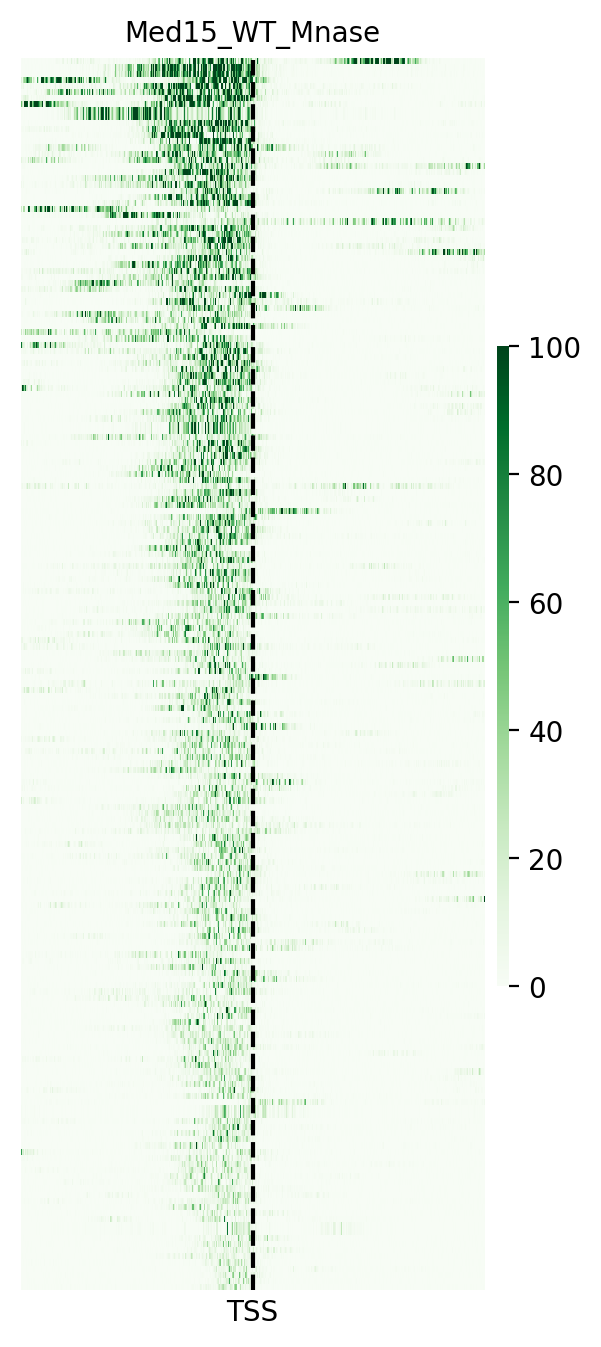

In [8]:
fig, axes = plt.subplots(1, figsize=(3, 8), gridspec_kw={'width_ratios': [1], 'wspace': 0.1})
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  

for i, column in enumerate(promoter_binding_signals.filter(regex='WT').columns):    
    heatmap_around_TSS_one_target(promoter_binding_signals, column, med15_top_targets, axes, cbar_ax)

plt.subplots_adjust(right=0.90)  
plt.show()

### Figure 1C

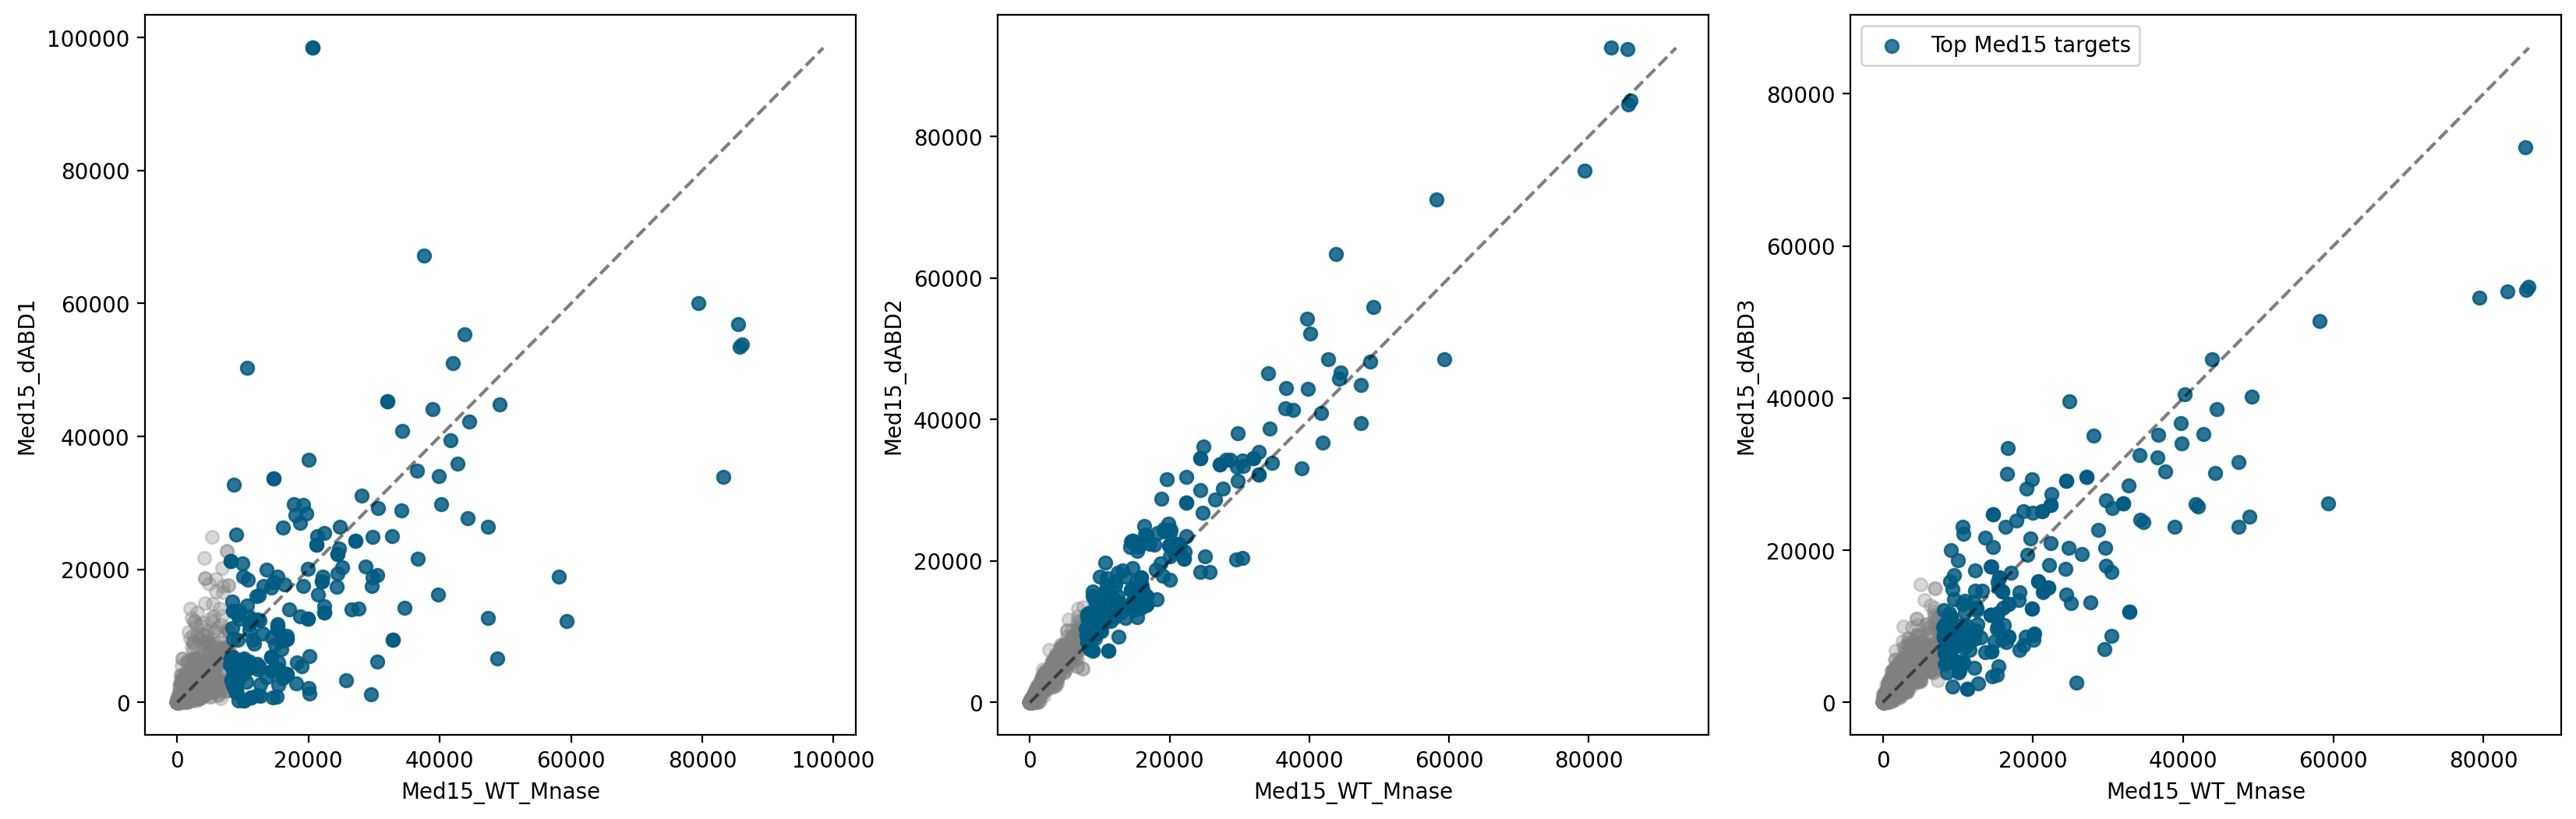

In [9]:
fig, axes = plt.subplots(1,3, figsize=(20, 6))
axes[0].scatter(WT_system_data['Med15_WT_Mnase'], WT_system_data['Med15_dABD1'], 
        alpha=0.3, 
        color='grey'
    )
axes[0].scatter(
        WT_system_data['Med15_WT_Mnase'].loc[med15_top_targets], WT_system_data['Med15_dABD1'].loc[med15_top_targets],
        alpha=0.8, 
        color='#005b82', edgecolor='#005b82',
        label='Top Med15 targets'
    )

max_val = max(WT_system_data['Med15_WT_Mnase'].max(), WT_system_data['Med15_dABD1'].max())
axes[0].plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
axes[0].set_xlabel('Med15_WT_Mnase')
axes[0].set_ylabel('Med15_dABD1')

axes[1].scatter(WT_system_data['Med15_WT_Mnase'], WT_system_data['Med15_dABD2'], 
        alpha=0.3, 
        color='grey'
    )
axes[1].scatter(
        WT_system_data['Med15_WT_Mnase'].loc[med15_top_targets], WT_system_data['Med15_dABD2'].loc[med15_top_targets],
        alpha=0.8, 
        color='#005b82', edgecolor='#005b82',
        label='Top Med15 targets'
    )

max_val = max(WT_system_data['Med15_WT_Mnase'].max(), WT_system_data['Med15_dABD2'].max())
axes[1].plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
axes[1].set_xlabel('Med15_WT_Mnase')
axes[1].set_ylabel('Med15_dABD2')

axes[2].scatter(WT_system_data['Med15_WT_Mnase'], WT_system_data['Med15_dABD3'], 
        alpha=0.3, 
        color='grey'
    )
axes[2].scatter(
        WT_system_data['Med15_WT_Mnase'].loc[med15_top_targets], WT_system_data['Med15_dABD3'].loc[med15_top_targets],
        alpha=0.8, 
        color='#005b82', edgecolor='#005b82',
        label='Top Med15 targets'
    )

max_val = max(WT_system_data['Med15_WT_Mnase'].max(), WT_system_data['Med15_dABD3'].max())
axes[2].plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
axes[2].set_xlabel('Med15_WT_Mnase')
axes[2].set_ylabel('Med15_dABD3')
plt.legend()

plt.show()

### Figure 1D

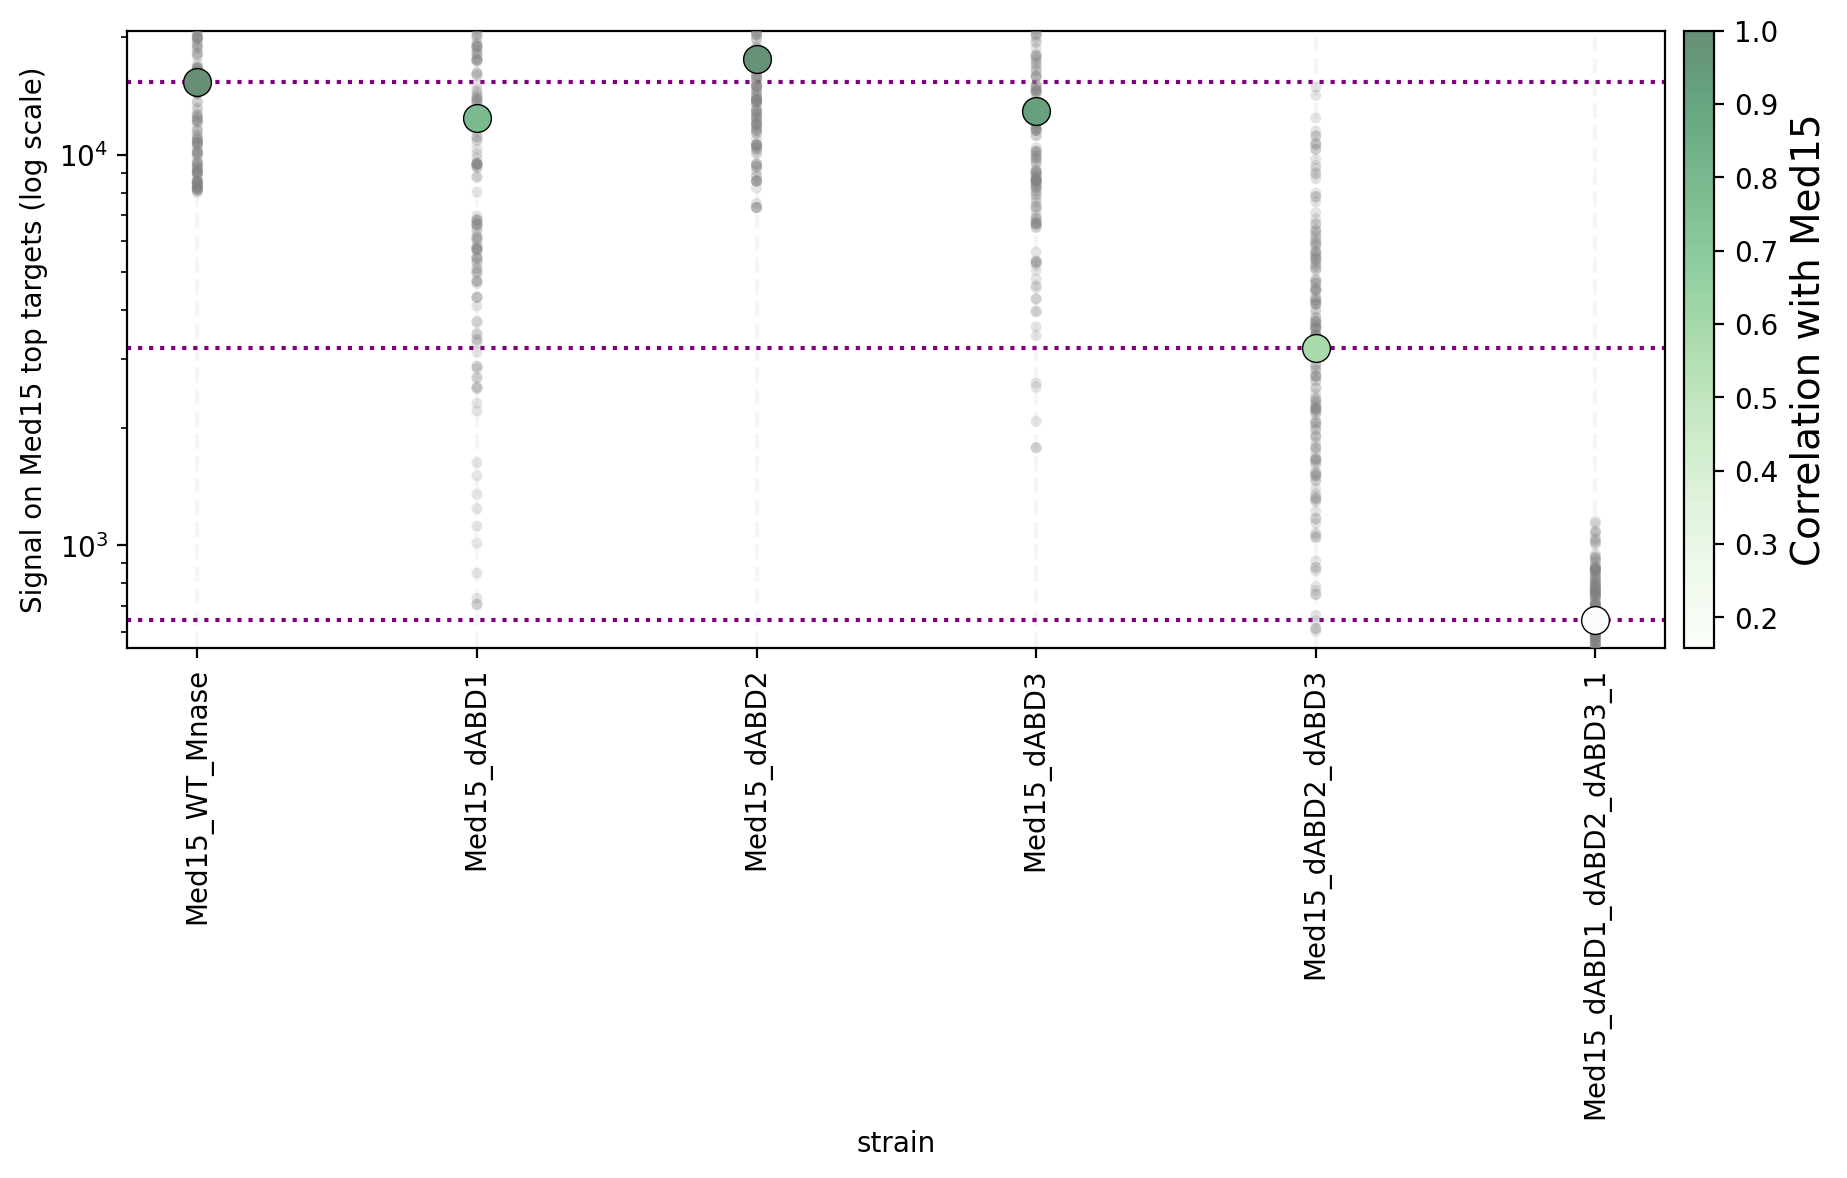

In [13]:
dABDs = WT_system_data[['Med15_WT_Mnase', 'Med15_dABD1', 'Med15_dABD2', 'Med15_dABD3','Med15_dABD2_dABD3','Med15_dABD1_dABD2_dABD3_1']]
df_top = dABDs.loc[med15_top_targets].copy()
df_top['gene'] = df_top.index

df_long = df_top.melt(
    id_vars='gene',
    var_name='strain',
    value_name='signal'
).dropna()


median_df = (
    df_long
    .groupby('strain')['signal']
    .median()
    .reset_index(name='median_signal')
)


WT_col = 'Med15_WT_Mnase'
corr_with_WT = dABDs[dABDs.columns].corr()[WT_col]
corr_with_WT = corr_with_WT.reindex(dABDs.columns)  # ensure same order


median_df['corr_to_WT'] = median_df['strain'].map(corr_with_WT)


median_df = median_df.set_index('strain').reindex(dABDs.columns).reset_index()


norm = Normalize(
    vmin=median_df['corr_to_WT'].min(),
    vmax=median_df['corr_to_WT'].max()
)
cmap = cm.get_cmap('viridis')


plt.figure(figsize=(10, 6))


sns.stripplot(
    data=df_long,
    x='strain',
    y='signal',
    order=dABDs.columns,       
    color='grey',
    alpha=0.2,
    jitter=False,              
    size=4
)


for _, row in median_df.iterrows():
    if pd.isna(row['median_signal']):
        continue  
    plt.scatter(
        x=row['index'],
        y=row['median_signal'],
        color=pastel_cmap(norm(row['corr_to_WT'])),
        edgecolor='black',
        s=100,
        linewidth=0.5,
        zorder=10
    )


for strain in dABDs.columns:
    plt.axvline(x=strain, color='lightgrey', linestyle='--', alpha=0.2)



target_strain = 'Med15_dABD1_dABD2_dABD3_1'
subset = median_df.loc[median_df['index'] == target_strain, 'median_signal']
med15_N600_avg = subset.mean() if not subset.empty else None
if med15_N600_avg is not None:
    plt.axhline(med15_N600_avg, color='purple', linestyle=':', label=f'{target_strain} binding profile')

target_strain = 'Med15_WT_Mnase'
subset = median_df.loc[median_df['index'] == target_strain, 'median_signal']
med15_N600_avg = subset.mean() if not subset.empty else None
if med15_N600_avg is not None:
    plt.axhline(med15_N600_avg, color='purple', linestyle=':', label=f'{target_strain} binding profile')

target_strain = 'Med15_dABD2_dABD3'
subset = median_df.loc[median_df['index'] == target_strain, 'median_signal']
med15_N600_avg = subset.mean() if not subset.empty else None
if med15_N600_avg is not None:
    plt.axhline(med15_N600_avg, color='purple', linestyle=':', label=f'{target_strain} binding profile')


sm = cm.ScalarMappable(norm=norm, cmap=pastel_cmap)
cbar = plt.colorbar(sm, pad=0.01)
cbar.set_label('Correlation with Med15', fontsize=14)


plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('Signal on Med15 top targets (log scale)')
plt.tight_layout()
plt.show()


### Figure 1E

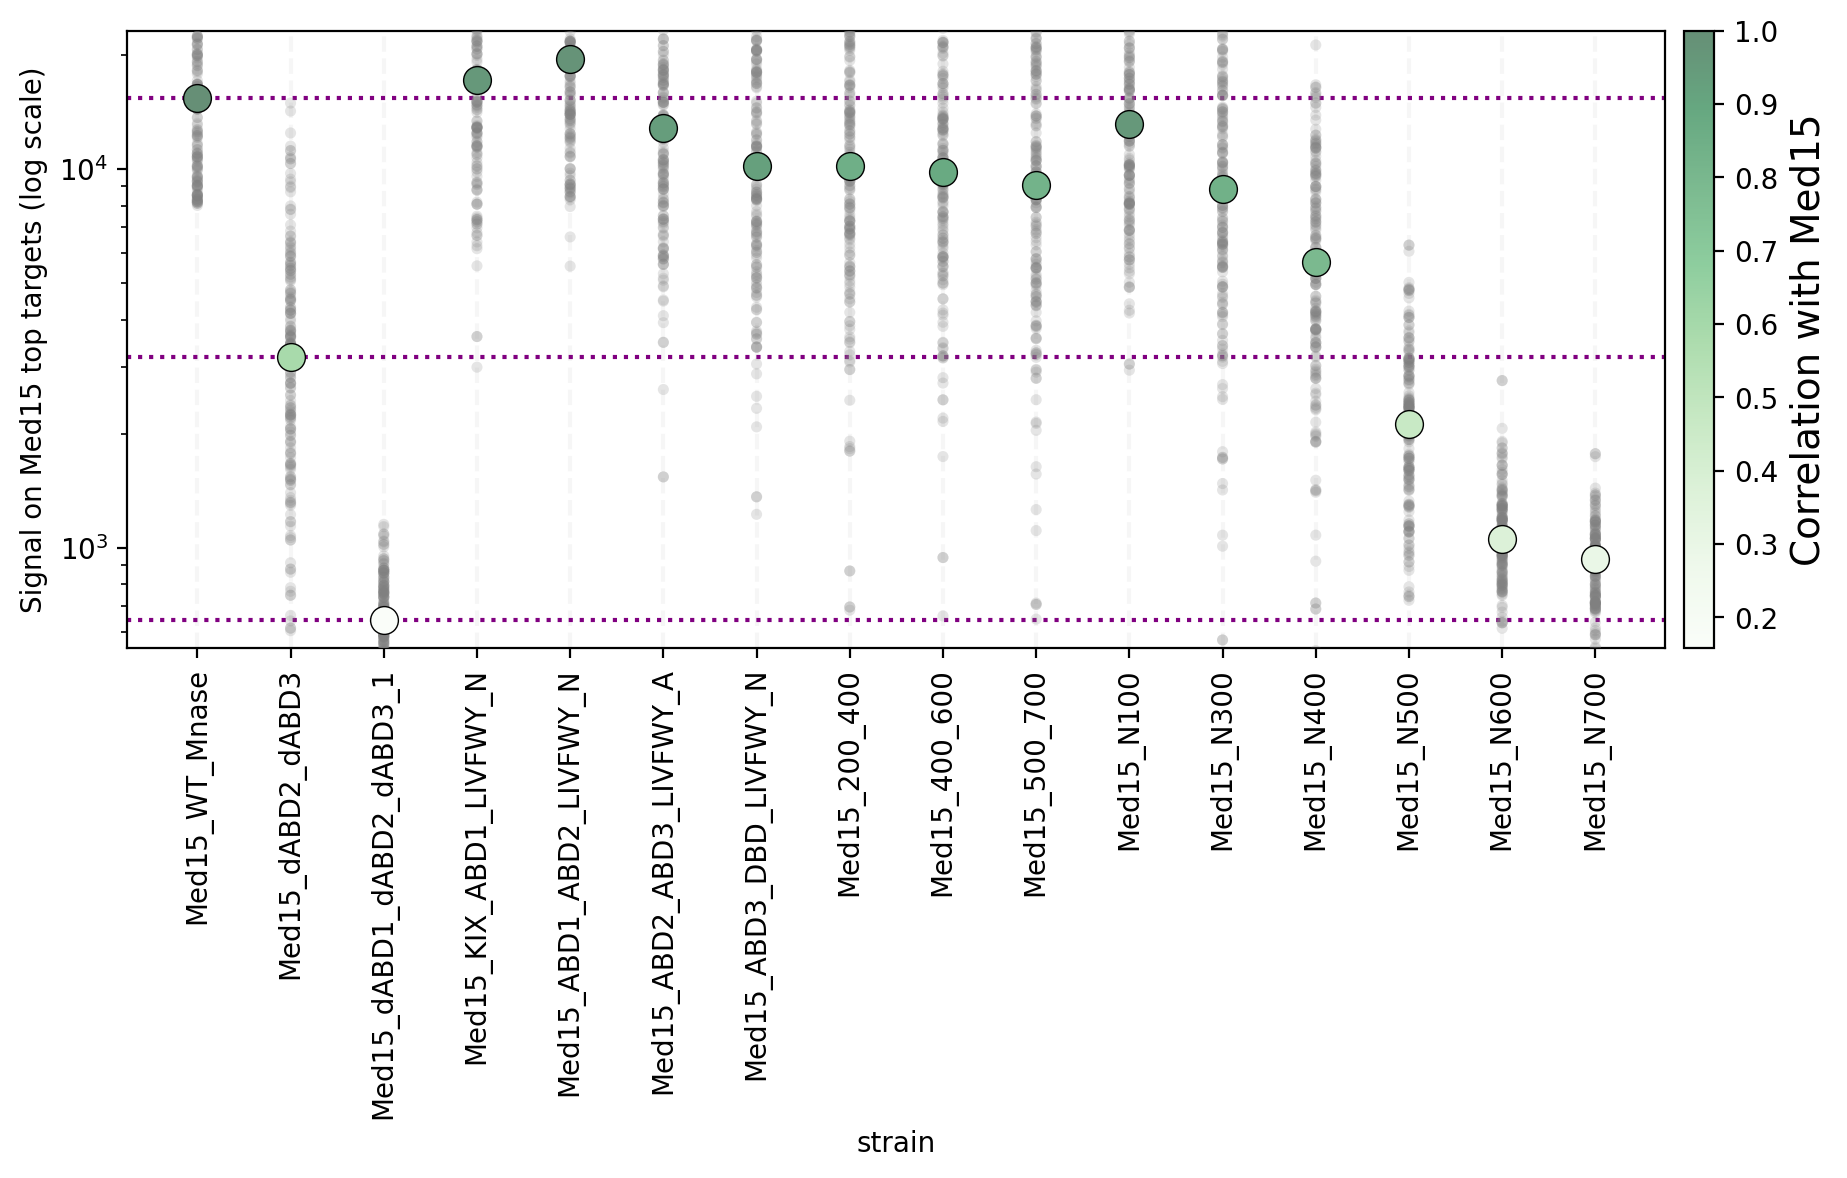

In [14]:
dABDs = WT_system_data[['Med15_WT_Mnase','Med15_dABD2_dABD3','Med15_dABD1_dABD2_dABD3_1', 'Med15_KIX_ABD1_LIVFWY_N','Med15_ABD1_ABD2_LIVFWY_N', 'Med15_ABD2_ABD3_LIVFWY_A','Med15_ABD3_DBD_LIVFWY_N','Med15_200_400', 'Med15_400_600', 'Med15_500_700','Med15_N100', 'Med15_N300', 'Med15_N400', 'Med15_N500','Med15_N600','Med15_N700']]
df_top = dABDs.loc[med15_top_targets].copy()
df_top['gene'] = df_top.index

df_long = df_top.melt(
    id_vars='gene',
    var_name='strain',
    value_name='signal'
).dropna()


median_df = (
    df_long
    .groupby('strain')['signal']
    .median()
    .reset_index(name='median_signal')
)


WT_col = 'Med15_WT_Mnase'
corr_with_WT = dABDs[dABDs.columns].corr()[WT_col]
corr_with_WT = corr_with_WT.reindex(dABDs.columns)  # ensure same order


median_df['corr_to_WT'] = median_df['strain'].map(corr_with_WT)


median_df = median_df.set_index('strain').reindex(dABDs.columns).reset_index()


norm = Normalize(
    vmin=median_df['corr_to_WT'].min(),
    vmax=median_df['corr_to_WT'].max()
)
cmap = cm.get_cmap('viridis')


plt.figure(figsize=(10, 6))


sns.stripplot(
    data=df_long,
    x='strain',
    y='signal',
    order=dABDs.columns,       
    color='grey',
    alpha=0.2,
    jitter=False,              
    size=4
)


for _, row in median_df.iterrows():
    if pd.isna(row['median_signal']):
        continue  
    plt.scatter(
        x=row['index'],
        y=row['median_signal'],
        color=pastel_cmap(norm(row['corr_to_WT'])),
        edgecolor='black',
        s=100,
        linewidth=0.5,
        zorder=10
    )


for strain in dABDs.columns:
    plt.axvline(x=strain, color='lightgrey', linestyle='--', alpha=0.2)



target_strain = 'Med15_dABD1_dABD2_dABD3_1'
subset = median_df.loc[median_df['index'] == target_strain, 'median_signal']
med15_N600_avg = subset.mean() if not subset.empty else None
if med15_N600_avg is not None:
    plt.axhline(med15_N600_avg, color='purple', linestyle=':', label=f'{target_strain} binding profile')

target_strain = 'Med15_WT_Mnase'
subset = median_df.loc[median_df['index'] == target_strain, 'median_signal']
med15_N600_avg = subset.mean() if not subset.empty else None
if med15_N600_avg is not None:
    plt.axhline(med15_N600_avg, color='purple', linestyle=':', label=f'{target_strain} binding profile')

target_strain = 'Med15_dABD2_dABD3'
subset = median_df.loc[median_df['index'] == target_strain, 'median_signal']
med15_N600_avg = subset.mean() if not subset.empty else None
if med15_N600_avg is not None:
    plt.axhline(med15_N600_avg, color='purple', linestyle=':', label=f'{target_strain} binding profile')


sm = cm.ScalarMappable(norm=norm, cmap=pastel_cmap)
cbar = plt.colorbar(sm, pad=0.01)
cbar.set_label('Correlation with Med15', fontsize=14)


plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('Signal on Med15 top targets (log scale)')
plt.tight_layout()
plt.show()


# Figure 2

### Figure 2A

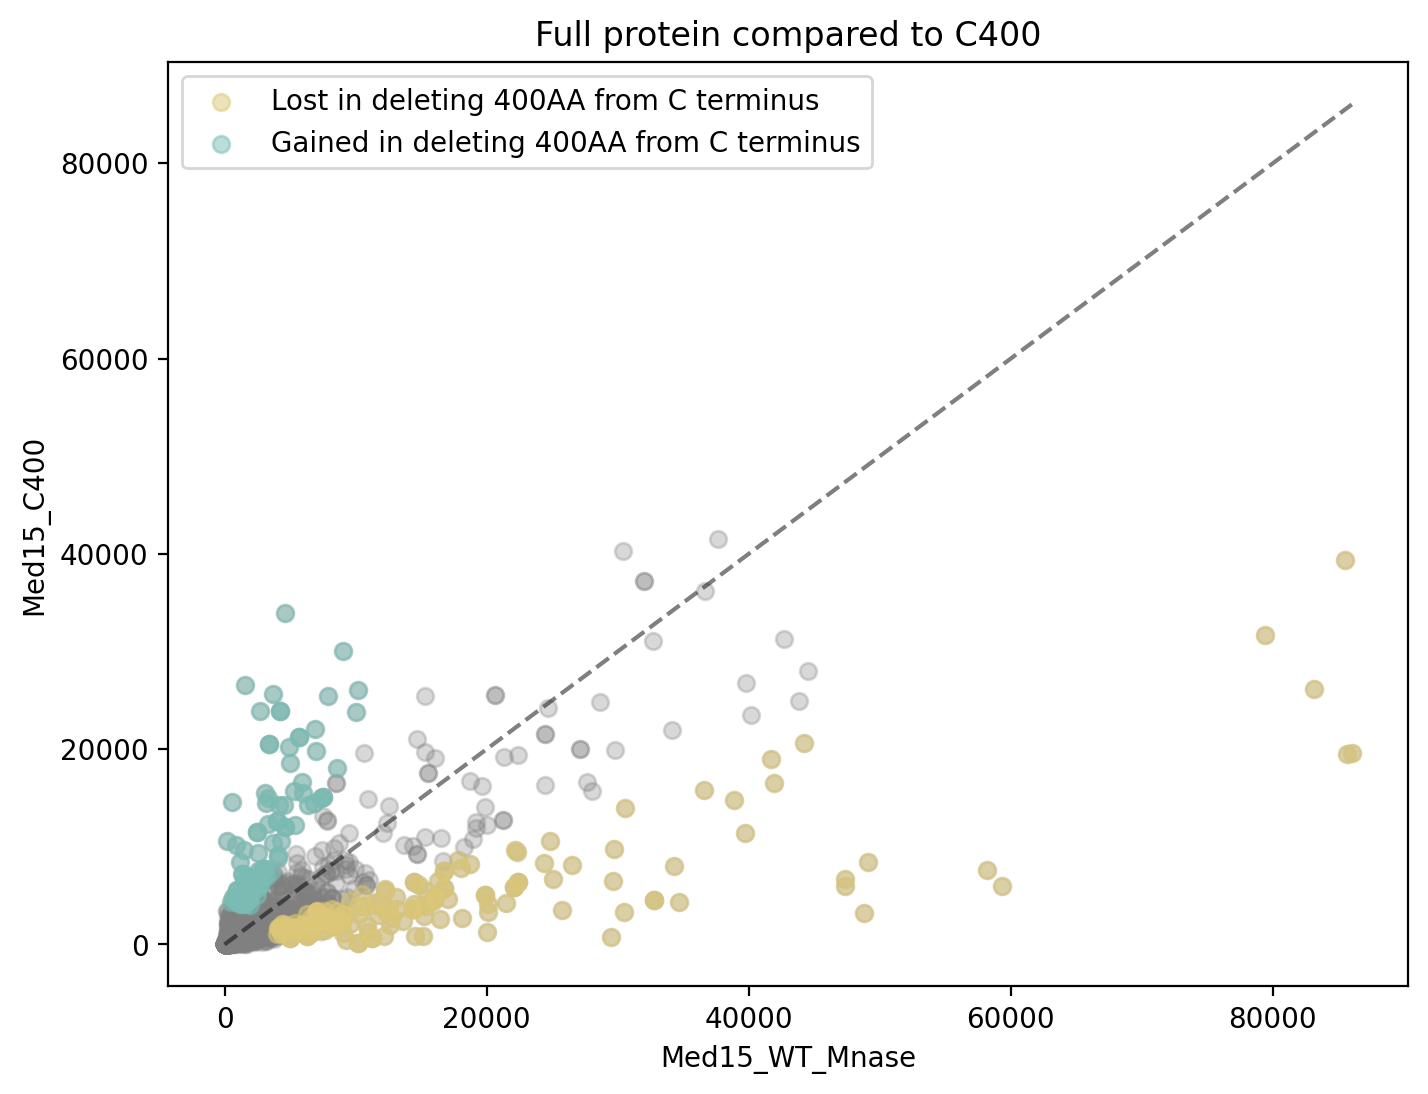

In [15]:
fig, axes = plt.subplots(1, figsize=(8, 6))
plt.scatter(WT_system_data['Med15_WT_Mnase'], WT_system_data['Med15_C400'], 
        alpha=0.3, 
        color='grey'
    )
plt.scatter(
        WT_system_data['Med15_WT_Mnase'].loc[lost_in_dC], WT_system_data['Med15_C400'].loc[lost_in_dC],
        alpha=0.5, 
        color='#DDC878', edgecolor='#DDC878',
        label='Lost in deleting 400AA from C terminus'
    )
plt.scatter(
        WT_system_data['Med15_WT_Mnase'].loc[gained_in_dC], WT_system_data['Med15_C400'].loc[gained_in_dC],
        alpha=0.5, 
        color='#7ABDB5', edgecolor='#7ABDB5',
        label='Gained in deleting 400AA from C terminus'
    )
max_val = max(WT_system_data['Med15_C400'].max(), WT_system_data['Med15_WT_Mnase'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
plt.ylabel('Med15_C400')
plt.xlabel('Med15_WT_Mnase')
plt.legend()
plt.title(f'Full protein compared to C400')
plt.show()

### Figure 2B

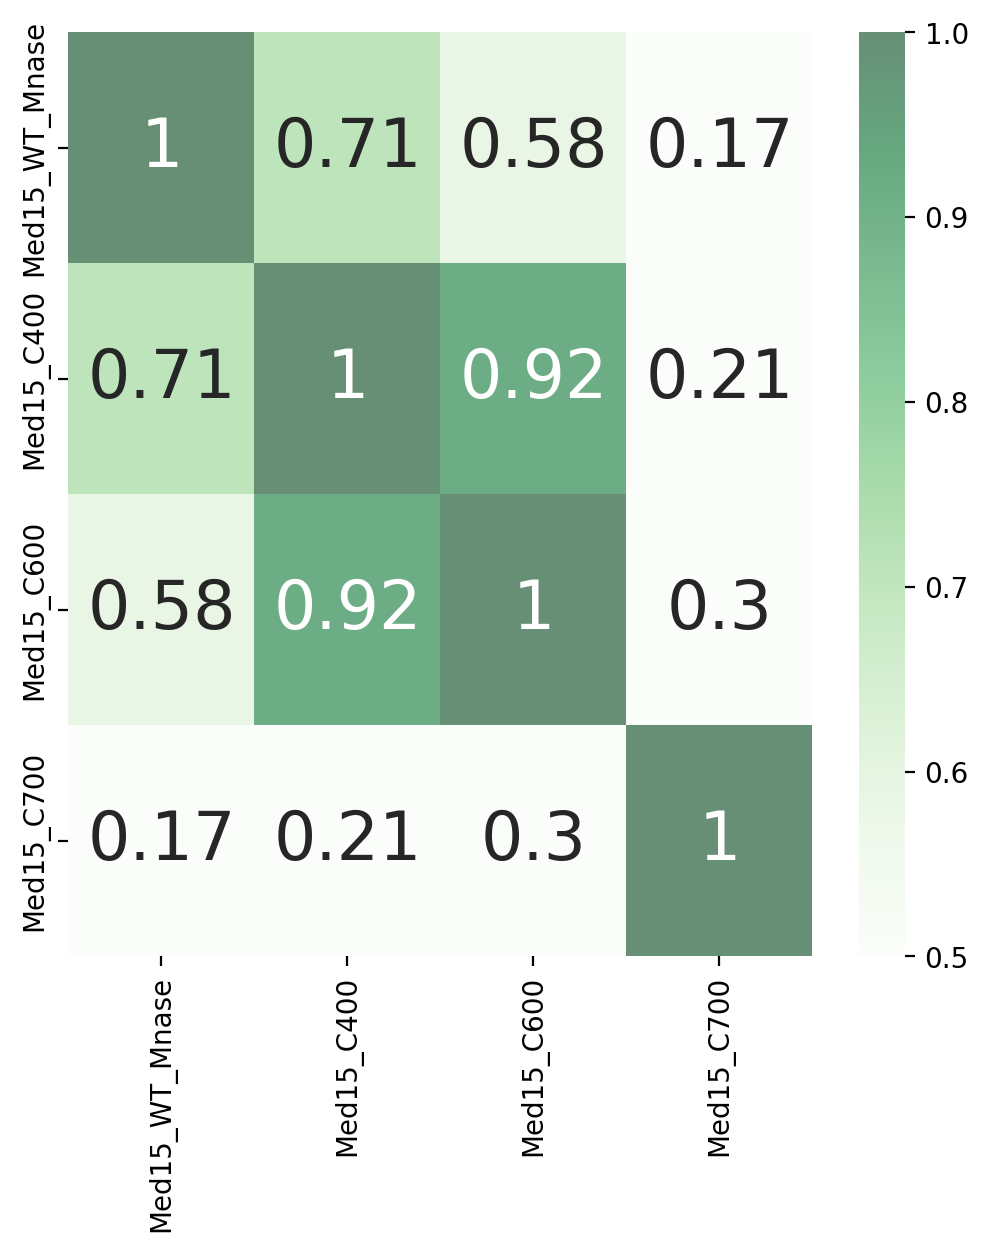

In [16]:
corr_matrix = WT_system_data.filter(regex='Med15_WT_Mnase|C400|C600|C700').corr().abs()

filtered_corr_matrix = corr_matrix

plt.subplots(figsize=(6,6))
heatmap = sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2g", cmap=pastel_cmap, vmax=1, vmin=0.5, annot_kws={"size": 24, 'rotation':0})

plt.show()

### Figure 2C

In [17]:
Figure_2C = WT_system_data[['Med15_WT_Mnase','Med15_C100', 'Med15_C200', 'Med15_C300',
       'Med15_C400', 'Med15_C600', 'Med15_C700','Med15_700_900','Med15_dDBD', 'Med15_800_1000',
       'Med15_900_1080','Med15_DBD_END_LIVFWY_N','Med15_Mnase_LIVFWY_Shift_DBD_END', 'Med15_DBD_END_QN_G',
       'Med15_DBD_END_Q_N']]

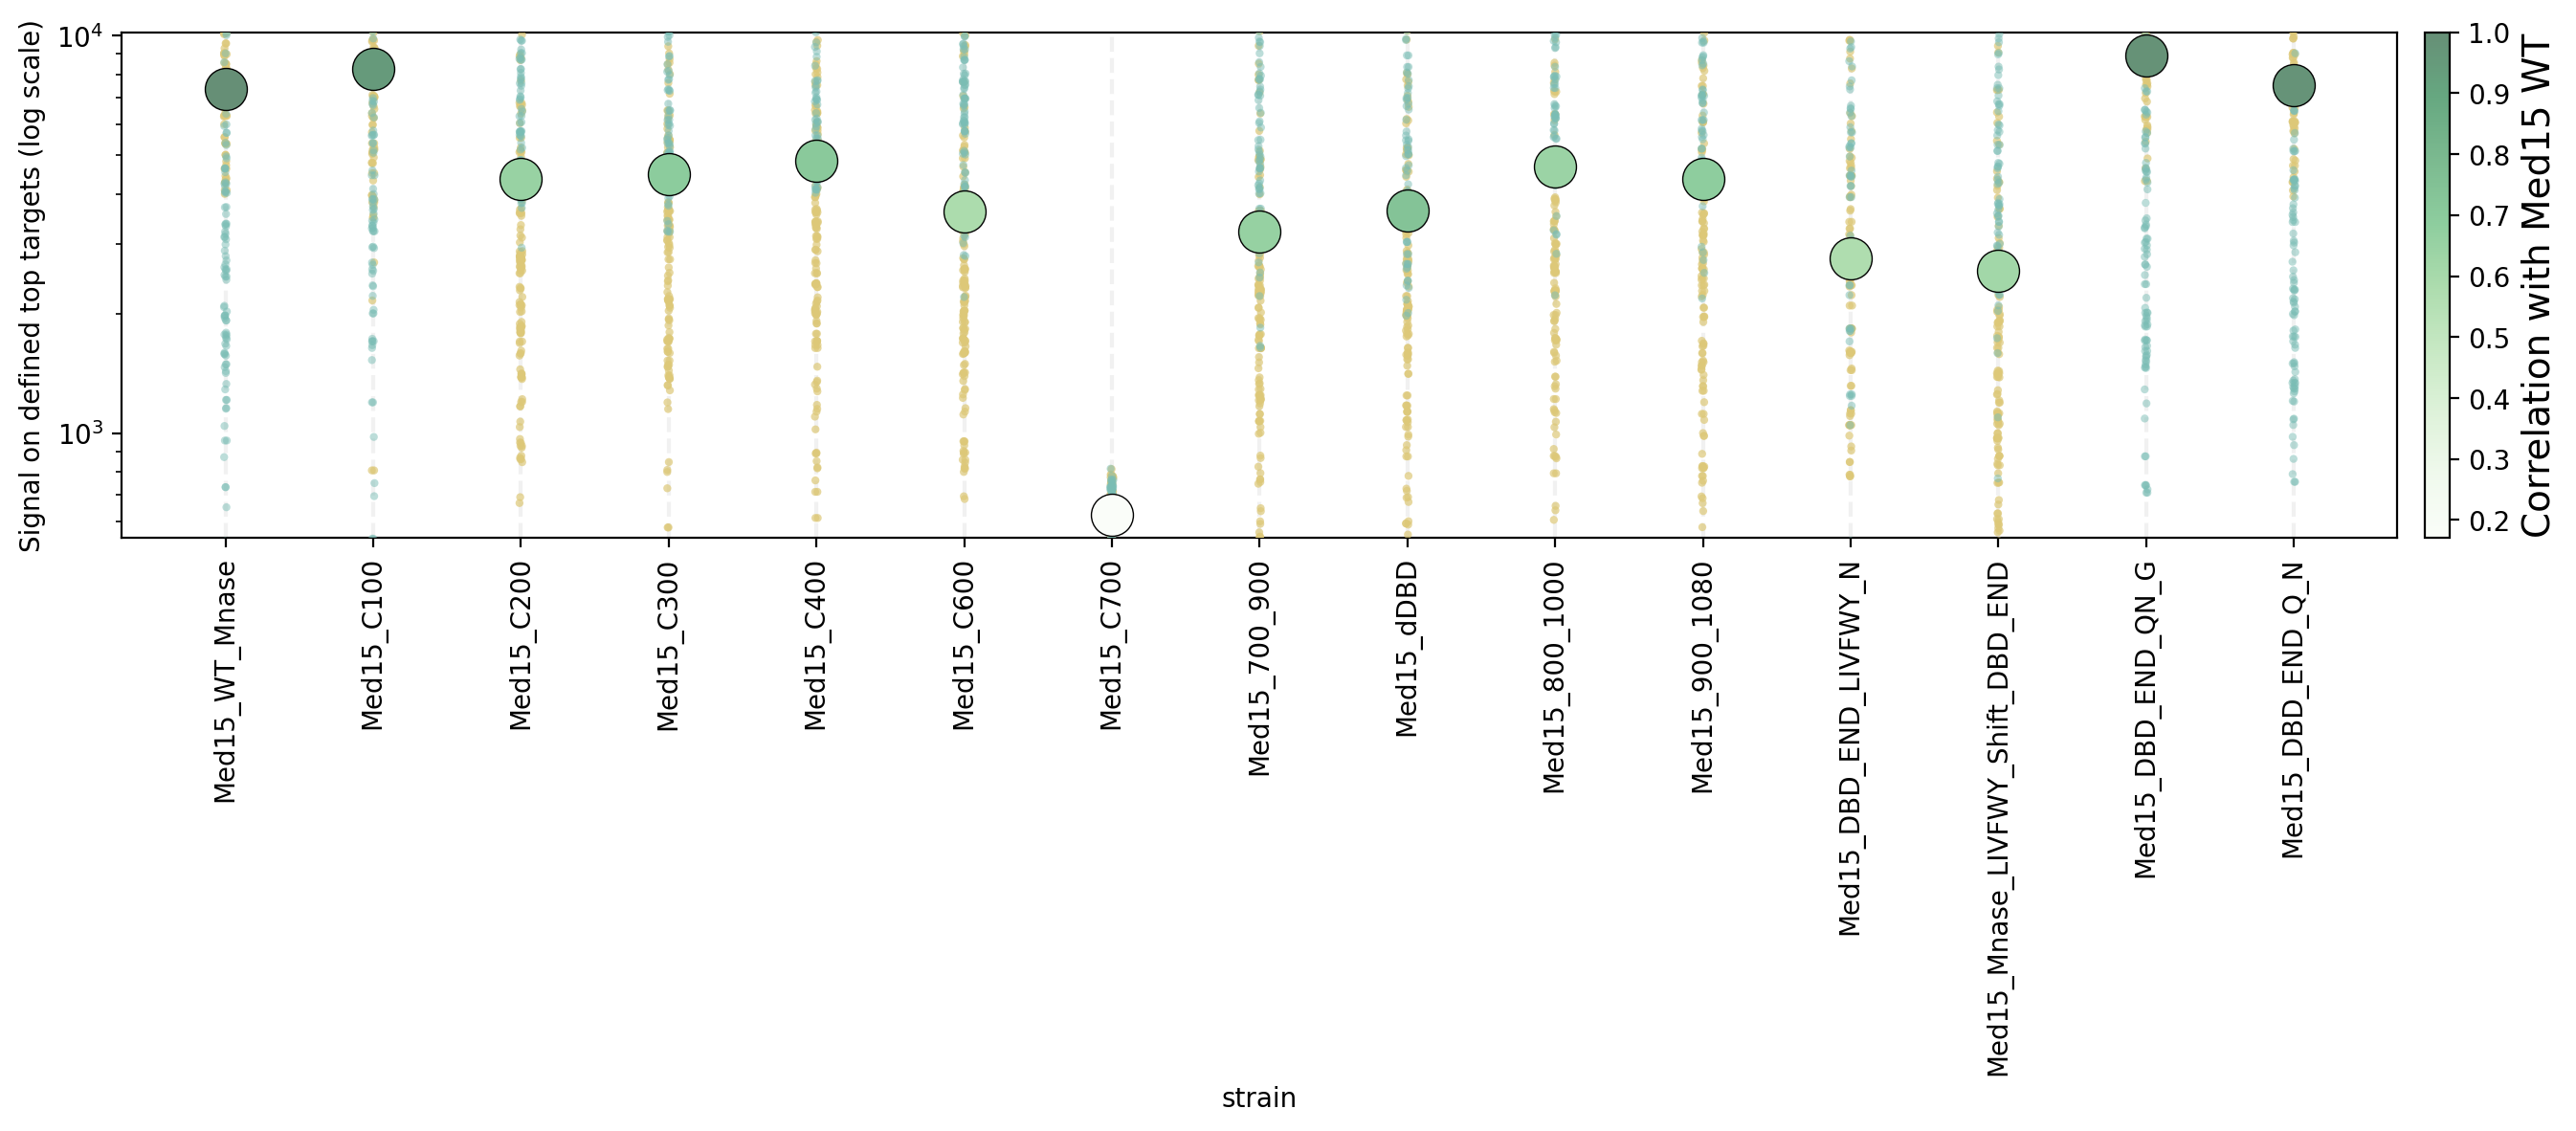

In [18]:
df_top = Figure_2C.loc[lost_in_dC + gained_in_dC].copy()
df_top['gene'] = df_top.index

df_long = df_top.melt(
    id_vars='gene',
    var_name='strain',
    value_name='signal'
).dropna()


median_df = (
    df_long
    .groupby('strain')['signal']
    .median()
    .reset_index(name='median_signal')
)


WT_col = 'Med15_WT_Mnase'
corr_with_WT = Figure_2C[Figure_2C.columns].corr()[WT_col]
corr_with_WT = corr_with_WT.reindex(Figure_2C.columns)  # ensure same order


median_df['corr_to_WT'] = median_df['strain'].map(corr_with_WT)


median_df = median_df.set_index('strain').reindex(Figure_2C.columns).reset_index()


norm = Normalize(
    vmin=median_df['corr_to_WT'].min(),
    vmax=median_df['corr_to_WT'].max()
)
cmap = cm.get_cmap('viridis')


plt.figure(figsize=(15, 6))


sns.stripplot(
    data=df_long[df_long['gene'].isin(lost_in_dC)],
    x='strain',
    y='signal',
    order=Figure_2C.columns,
    color='#DDC878',
    alpha=0.7,
    jitter=0.01,
    size=3
)
sns.stripplot(
    data=df_long[df_long['gene'].isin(gained_in_dC)],
    x='strain',
    y='signal',
    order=Figure_2C.columns,
    color='#7ABDB5',
    edgecolor='#7ABDB5',
    alpha=0.5,
    jitter=0.01,
    size=3
)

for _, row in median_df.iterrows():
    if pd.isna(row['median_signal']):
        continue
    plt.scatter(
        x=row['index'],
        y=row['median_signal'],
        color=pastel_cmap(norm(row['corr_to_WT'])),
        edgecolor='black',
        s=250,
        linewidth=0.5,
        zorder=10
    )


for strain in Figure_2C.columns:
    plt.axvline(x=strain, color='lightgrey', linestyle='--', alpha=0.3)


sm = cm.ScalarMappable(norm=norm, cmap=pastel_cmap)
cbar = plt.colorbar(sm, pad=0.01)
cbar.set_label('Correlation with Med15 WT', fontsize=14)


plt.xticks(rotation=90)
plt.yscale('log')

plt.ylabel('Signal on defined top targets (log scale)')
plt.tight_layout()
plt.show()


# Figure 3

### Figure 3B

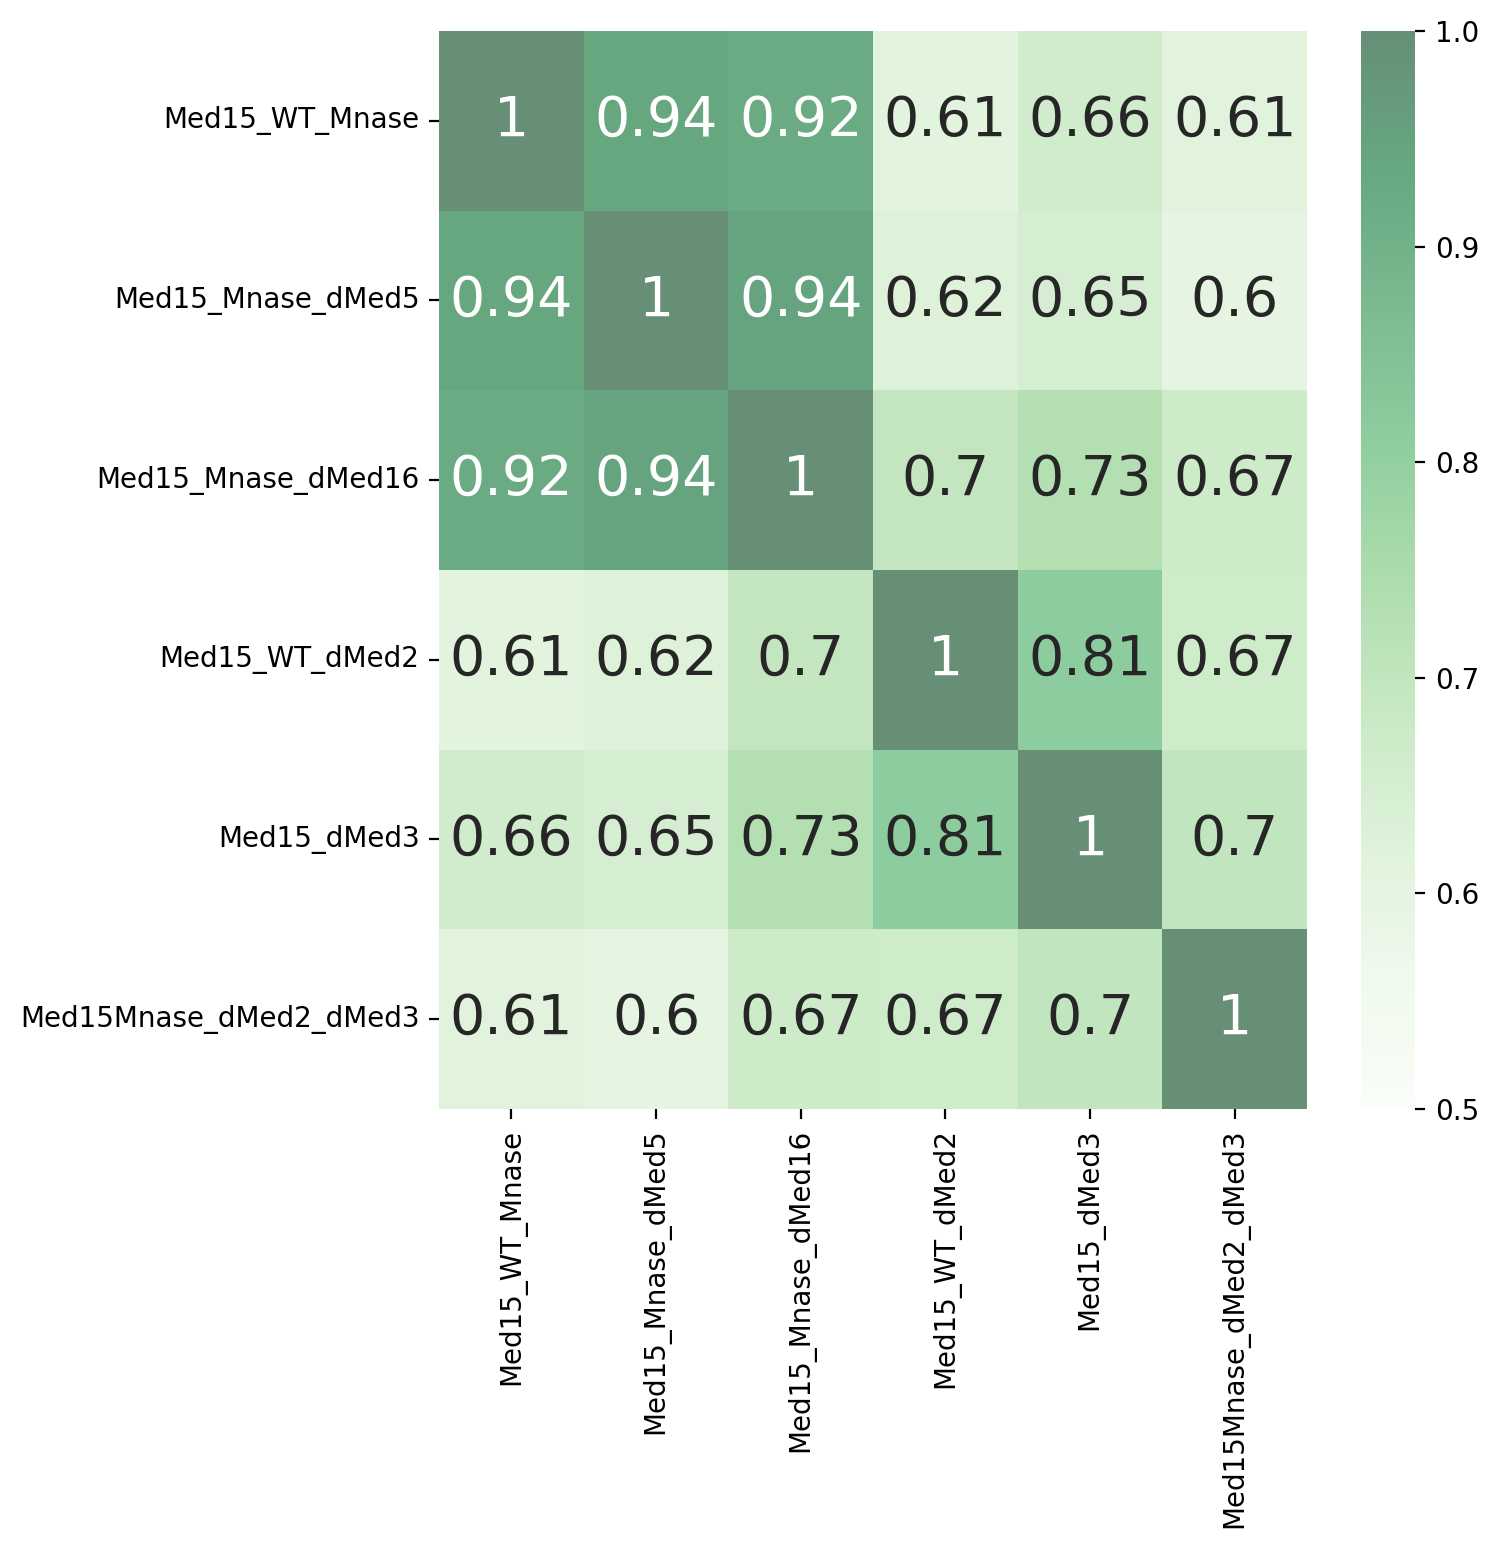

In [19]:
corr_matrix = WT_system_data[['Med15_WT_Mnase','Med15_Mnase_dMed5','Med15_Mnase_dMed16','Med15_WT_dMed2', 'Med15_dMed3','Med15Mnase_dMed2_dMed3']].corr().abs()


filtered_corr_matrix = corr_matrix

plt.subplots(figsize=(7,7))
heatmap = sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2g", cmap=pastel_cmap, vmax=1, vmin=0.5, annot_kws={"size": 20, 'rotation':0})


plt.show()

### Figure 3C

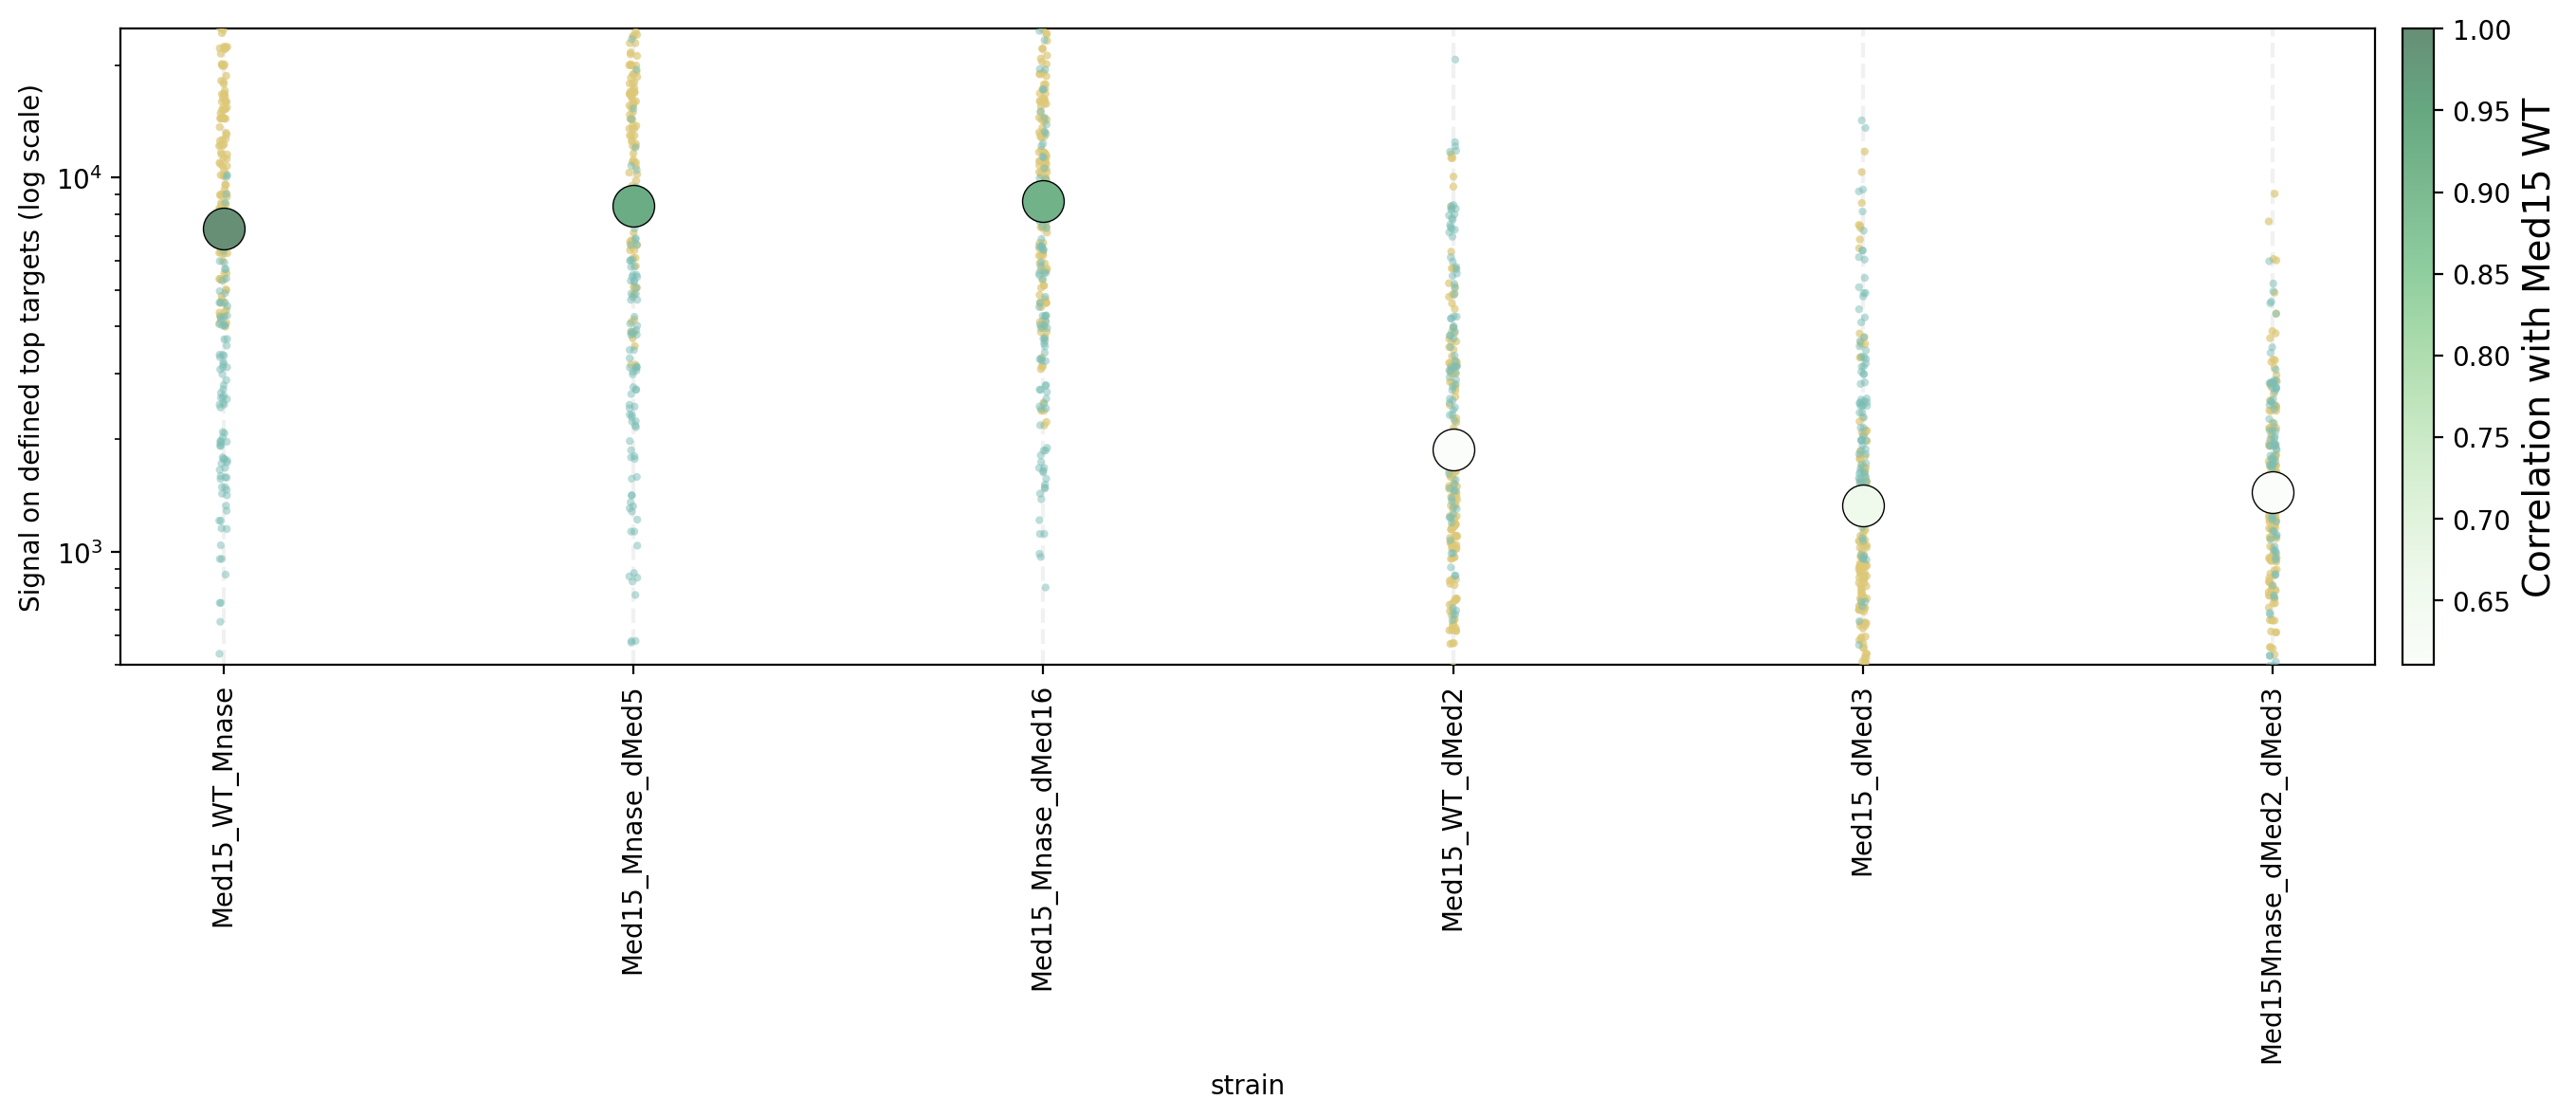

In [20]:
Figure_3C = WT_system_data[['Med15_WT_Mnase','Med15_Mnase_dMed5','Med15_Mnase_dMed16','Med15_WT_dMed2', 'Med15_dMed3','Med15Mnase_dMed2_dMed3']]
df_top = Figure_3C.loc[lost_in_dC + gained_in_dC].copy()
df_top['gene'] = df_top.index

df_long = df_top.melt(
    id_vars='gene',
    var_name='strain',
    value_name='signal'
).dropna()


median_df = (
    df_long
    .groupby('strain')['signal']
    .median()
    .reset_index(name='median_signal')
)


WT_col = 'Med15_WT_Mnase'
corr_with_WT = Figure_3C[Figure_3C.columns].corr()[WT_col]
corr_with_WT = corr_with_WT.reindex(Figure_3C.columns)  # ensure same order


median_df['corr_to_WT'] = median_df['strain'].map(corr_with_WT)


median_df = median_df.set_index('strain').reindex(Figure_3C.columns).reset_index()


norm = Normalize(
    vmin=median_df['corr_to_WT'].min(),
    vmax=median_df['corr_to_WT'].max()
)
cmap = cm.get_cmap('viridis')


plt.figure(figsize=(15, 6))


sns.stripplot(
    data=df_long[df_long['gene'].isin(lost_in_dC)],
    x='strain',
    y='signal',
    order=Figure_3C.columns,
    color='#DDC878',
    alpha=0.7,
    jitter=0.01,
    size=3
)
sns.stripplot(
    data=df_long[df_long['gene'].isin(gained_in_dC)],
    x='strain',
    y='signal',
    order=Figure_3C.columns,
    color='#7ABDB5',
    edgecolor='#7ABDB5',
    alpha=0.5,
    jitter=0.01,
    size=3
)

for _, row in median_df.iterrows():
    if pd.isna(row['median_signal']):
        continue
    plt.scatter(
        x=row['index'],
        y=row['median_signal'],
        color=pastel_cmap(norm(row['corr_to_WT'])),
        edgecolor='black',
        s=250,
        linewidth=0.5,
        zorder=10
    )


for strain in Figure_3C.columns:
    plt.axvline(x=strain, color='lightgrey', linestyle='--', alpha=0.3)


sm = cm.ScalarMappable(norm=norm, cmap=pastel_cmap)
cbar = plt.colorbar(sm, pad=0.01)
cbar.set_label('Correlation with Med15 WT', fontsize=14)


plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(500, 25000)
plt.ylabel('Signal on defined top targets (log scale)')
plt.tight_layout()
plt.show()


### Figure 3D

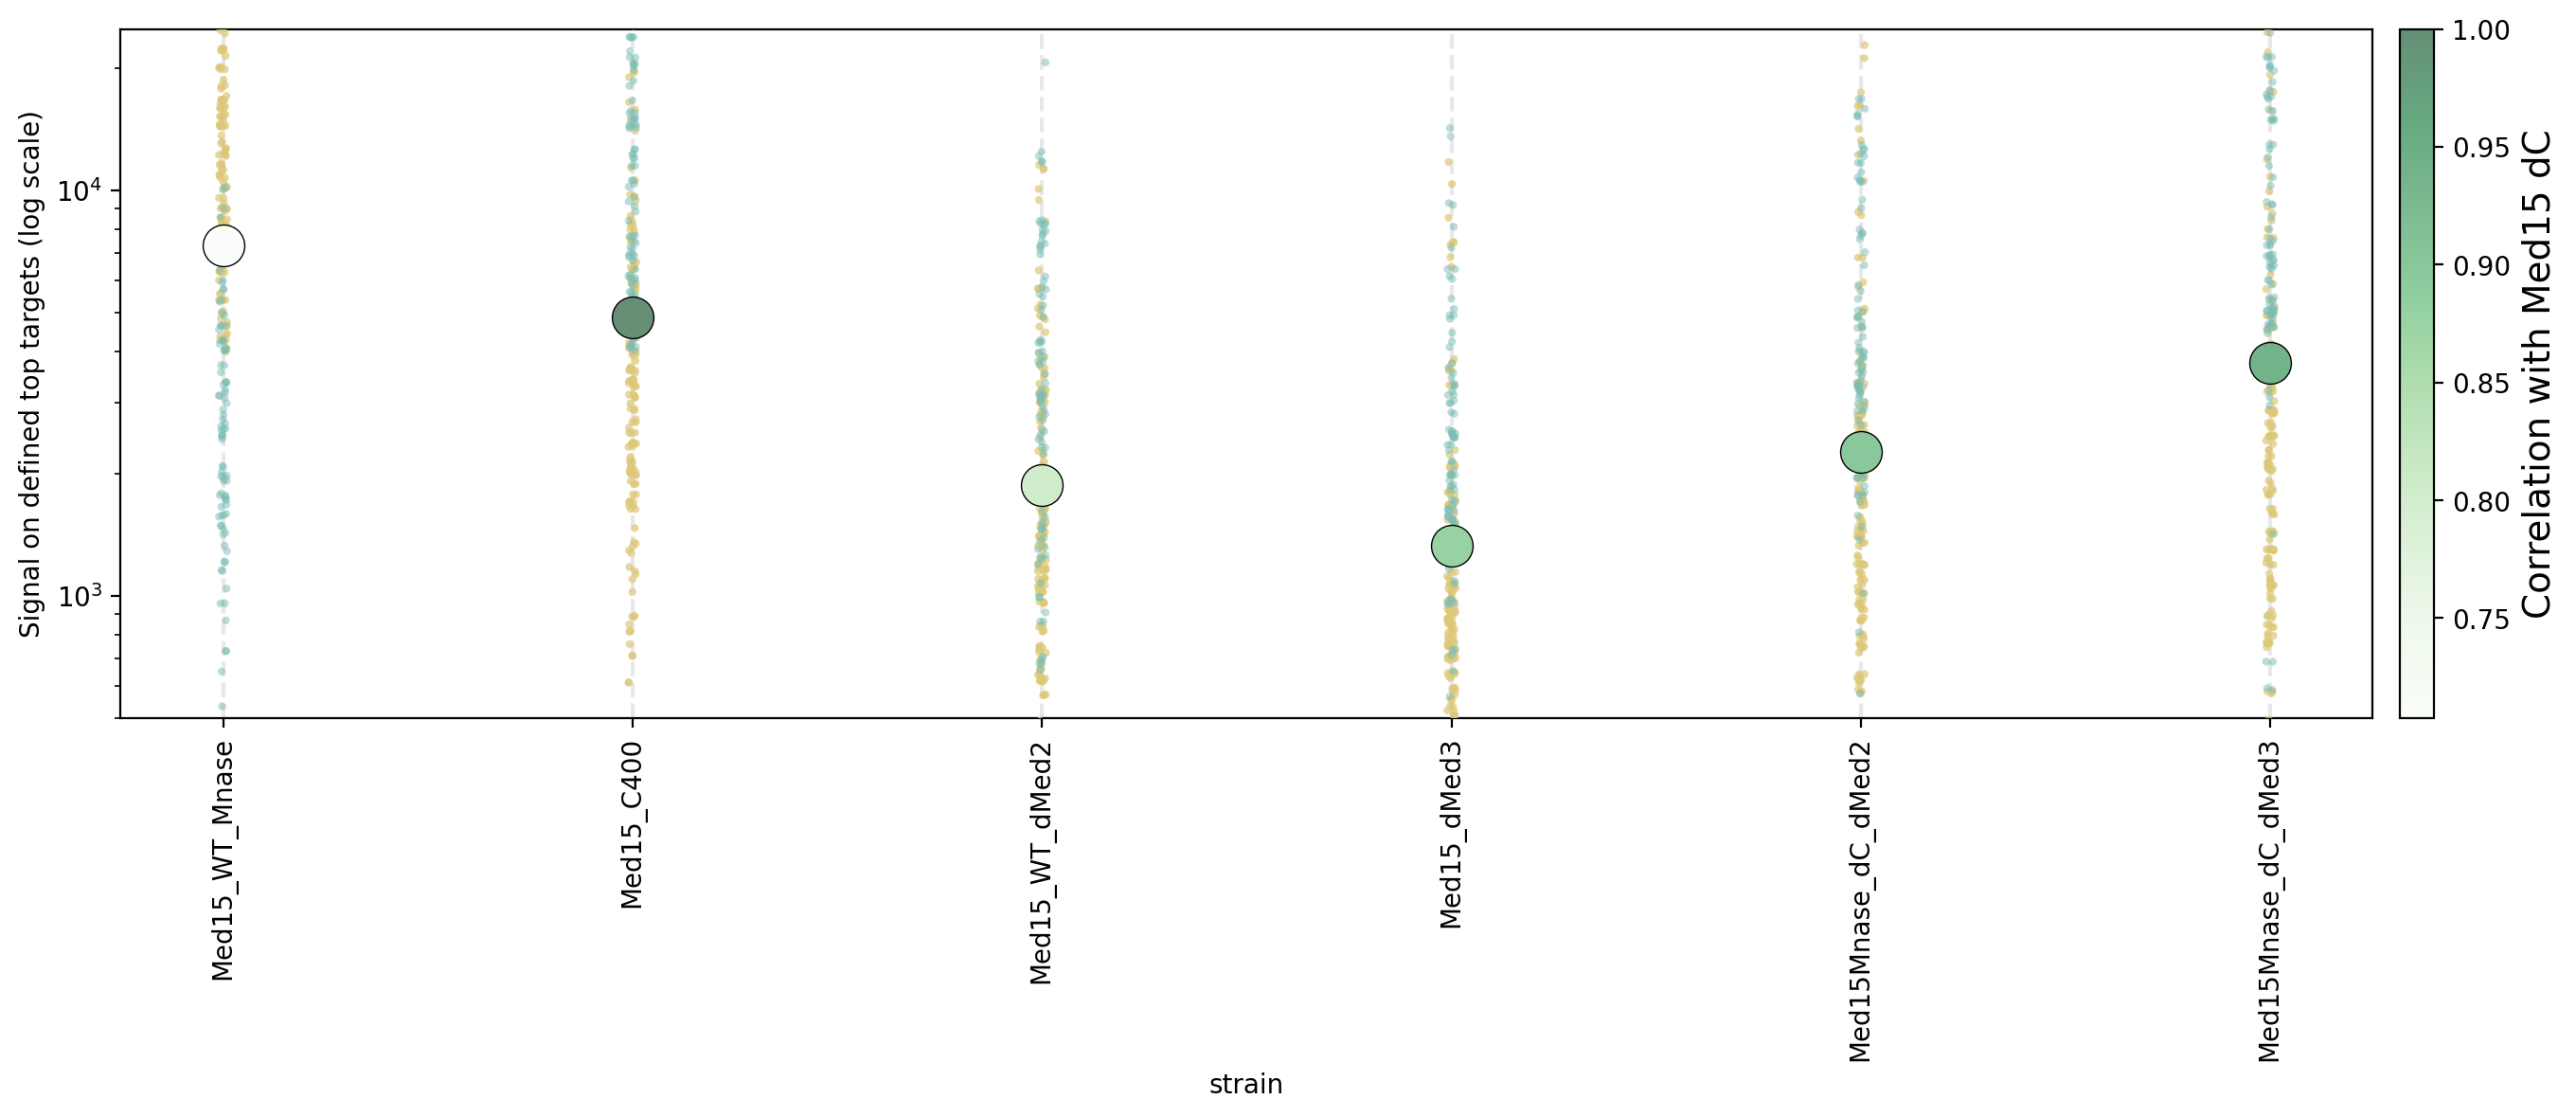

In [21]:
Figure_3D = WT_system_data[['Med15_WT_Mnase','Med15_C400','Med15_WT_dMed2', 'Med15_dMed3','Med15Mnase_dC_dMed2','Med15Mnase_dC_dMed3']]
df_top = Figure_3D.loc[lost_in_dC + gained_in_dC].copy()
df_top['gene'] = df_top.index

df_long = df_top.melt(
    id_vars='gene',
    var_name='strain',
    value_name='signal'
).dropna()


median_df = (
    df_long
    .groupby('strain')['signal']
    .median()
    .reset_index(name='median_signal')
)


WT_col = 'Med15_C400'
corr_with_WT = Figure_3D[Figure_3D.columns].corr()[WT_col]
corr_with_WT = corr_with_WT.reindex(Figure_3D.columns)  # ensure same order


median_df['corr_to_WT'] = median_df['strain'].map(corr_with_WT)


median_df = median_df.set_index('strain').reindex(Figure_3D.columns).reset_index()


norm = Normalize(
    vmin=median_df['corr_to_WT'].min(),
    vmax=median_df['corr_to_WT'].max()
)
cmap = cm.get_cmap('viridis')


plt.figure(figsize=(15, 6))


sns.stripplot(
    data=df_long[df_long['gene'].isin(lost_in_dC)],
    x='strain',
    y='signal',
    order=Figure_3D.columns,
    color='#DDC878',
    alpha=0.7,
    jitter=0.01,
    size=3
)
sns.stripplot(
    data=df_long[df_long['gene'].isin(gained_in_dC)],
    x='strain',
    y='signal',
    order=Figure_3D.columns,
    color='#7ABDB5',
    edgecolor='#7ABDB5',
    alpha=0.5,
    jitter=0.01,
    size=3
)

for _, row in median_df.iterrows():
    if pd.isna(row['median_signal']):
        continue
    plt.scatter(
        x=row['index'],
        y=row['median_signal'],
        color=pastel_cmap(norm(row['corr_to_WT'])),
        edgecolor='black',
        s=250,
        linewidth=0.5,
        zorder=10
    )


for strain in Figure_3D.columns:
    plt.axvline(x=strain, color='lightgrey', linestyle='--', alpha=0.5)


sm = cm.ScalarMappable(norm=norm, cmap=pastel_cmap)
cbar = plt.colorbar(sm, pad=0.01)
cbar.set_label('Correlation with Med15 dC', fontsize=14)


plt.xticks(rotation=90)
plt.yscale('log')
plt.ylim(500, 25000)
plt.ylabel('Signal on defined top targets (log scale)')
plt.tight_layout()
plt.show()


### Figure 3E

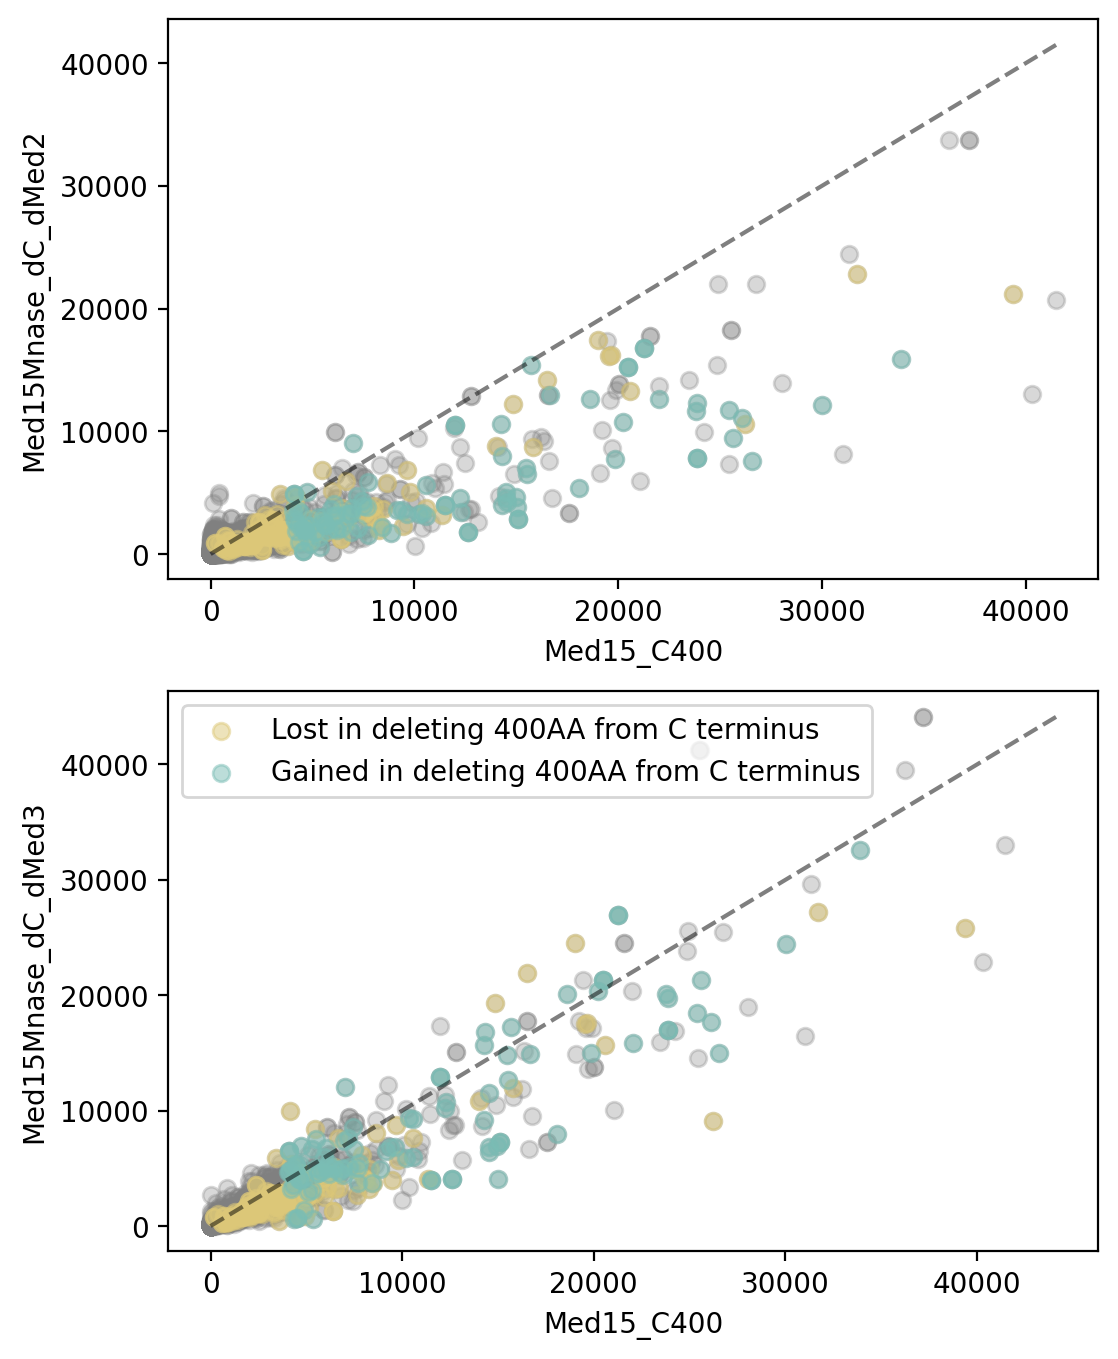

In [22]:
fig, axes = plt.subplots(2,1, figsize=(6, 8))
axes[0].scatter(Figure_3D['Med15_C400'], Figure_3D['Med15Mnase_dC_dMed2'], 
        alpha=0.3, 
        color='grey'
    )
axes[0].scatter(
        Figure_3D['Med15_C400'].loc[lost_in_dC], Figure_3D['Med15Mnase_dC_dMed2'].loc[lost_in_dC],
        alpha=0.5, 
        color='#DDC878', edgecolor='#DDC878',
        label='Lost in deleting 400AA from C terminus'
    )
axes[0].scatter(
        Figure_3D['Med15_C400'].loc[gained_in_dC], Figure_3D['Med15Mnase_dC_dMed2'].loc[gained_in_dC],
        alpha=0.5, 
        color='#7ABDB5', edgecolor='#7ABDB5',
        label='Gained in deleting 400AA from C terminus'
    )
max_val = max(Figure_3D['Med15_C400'].max(), Figure_3D['Med15Mnase_dC_dMed2'].max())
axes[0].plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
axes[0].set_xlabel('Med15_C400')
axes[0].set_ylabel('Med15Mnase_dC_dMed2')

axes[1].scatter(Figure_3D['Med15_C400'], Figure_3D['Med15Mnase_dC_dMed3'], 
        alpha=0.3, 
        color='grey'
    )
axes[1].scatter(
        Figure_3D['Med15_C400'].loc[lost_in_dC], Figure_3D['Med15Mnase_dC_dMed3'].loc[lost_in_dC],
        alpha=0.5, 
        color='#DDC878', edgecolor='#DDC878',
        label='Lost in deleting 400AA from C terminus'
    )
axes[1].scatter(
        Figure_3D['Med15_C400'].loc[gained_in_dC], Figure_3D['Med15Mnase_dC_dMed3'].loc[gained_in_dC],
        alpha=0.5, 
        color='#7ABDB5', edgecolor='#7ABDB5',
        label='Gained in deleting 400AA from C terminus'
    )
max_val = max(Figure_3D['Med15_C400'].max(), Figure_3D['Med15Mnase_dC_dMed3'].max())
axes[1].plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
axes[1].set_xlabel('Med15_C400')
axes[1].set_ylabel('Med15Mnase_dC_dMed3')
plt.legend()

plt.show()

# Figure 4

### Figure 4B

In [23]:
Figure_4B = WT_d12[['Msn2_DBD', 'Med15_WT_Mnase','SPT15_Mnase','SPT3_Mnase','NGG1_Mnase','Med15_Mnase_d12','SPT15_Mnase_d12', 'SPT3_Mnase_d12', 'NGG1_Mnase_d12']]

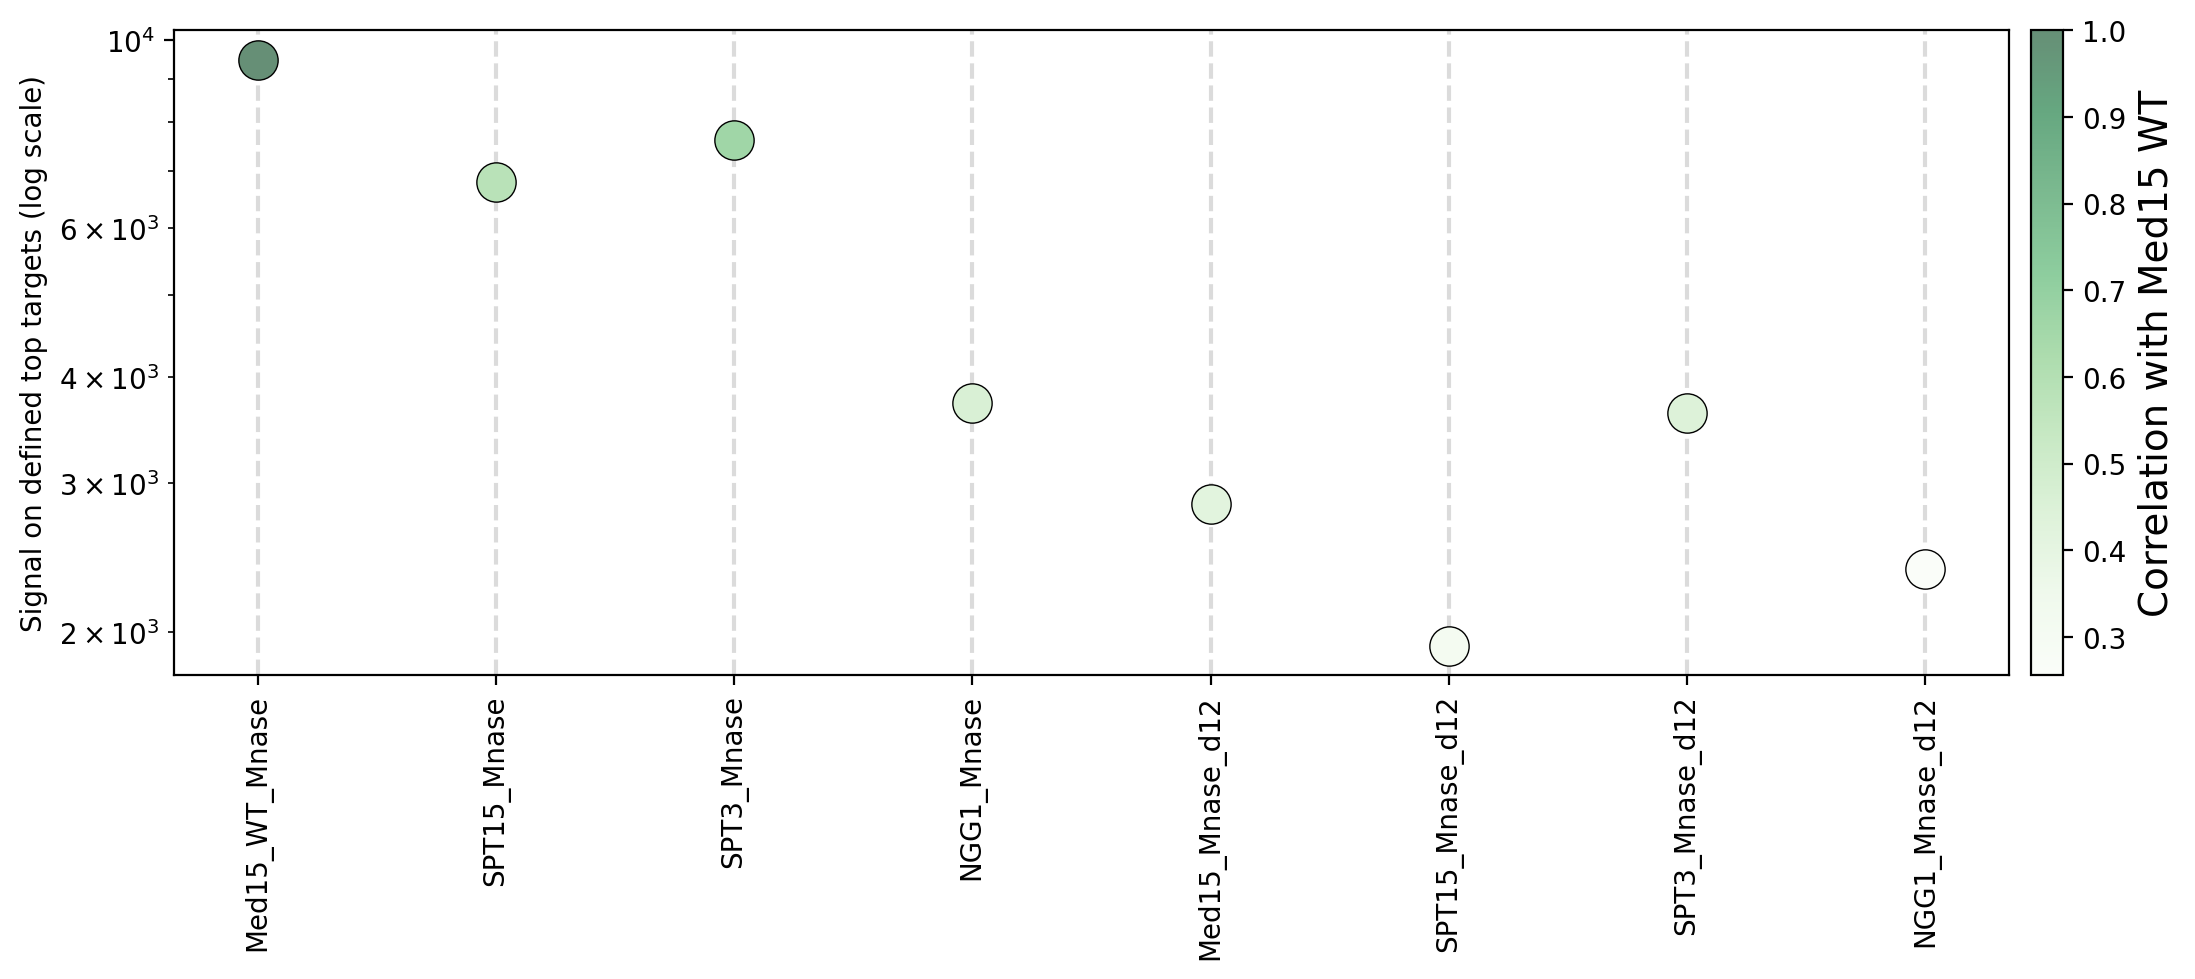

In [24]:
df_top = Figure_4B.iloc[:,1:].loc[lost_in_d12_gained_in_fusion].copy()
df_top['gene'] = df_top.index

df_long = df_top.melt(
    id_vars='gene',
    var_name='strain',
    value_name='signal'
).dropna()


median_df = (
    df_long
    .groupby('strain')['signal']
    .median()
    .reset_index(name='median_signal')
)


WT_col = 'Med15_WT_Mnase'
corr_with_WT = Figure_4B[Figure_4B.columns].corr()[WT_col]
corr_with_WT = corr_with_WT.reindex(Figure_4B.columns)  # ensure same order


median_df['corr_to_WT'] = median_df['strain'].map(corr_with_WT)


median_df = median_df.set_index('strain').reindex(Figure_4B.columns).reset_index()


norm = Normalize(
    vmin=median_df['corr_to_WT'].min(),
    vmax=median_df['corr_to_WT'].max()
)
cmap = cm.get_cmap('viridis')


plt.figure(figsize=(12, 5))


for _, row in median_df.iterrows():
    if pd.isna(row['median_signal']):
        continue
    plt.scatter(
        x=row['index'],
        y=row['median_signal'],
        color=pastel_cmap(norm(row['corr_to_WT'])),
        edgecolor='black',
        s=200,
        linewidth=0.5,
        zorder=10,rasterized=True
    )


for strain in Figure_4B.iloc[:,1:].columns:
    plt.axvline(x=strain, color='lightgrey', linestyle='--', alpha=0.8)



sm = cm.ScalarMappable(norm=norm, cmap=pastel_cmap)
cbar = plt.colorbar(sm, pad=0.01)
cbar.set_label('Correlation with Med15 WT', fontsize=14)


plt.xticks(rotation=90)
plt.yscale('log')

plt.ylabel('Signal on defined top targets (log scale)')
plt.tight_layout()

plt.show()


### Figure 4C

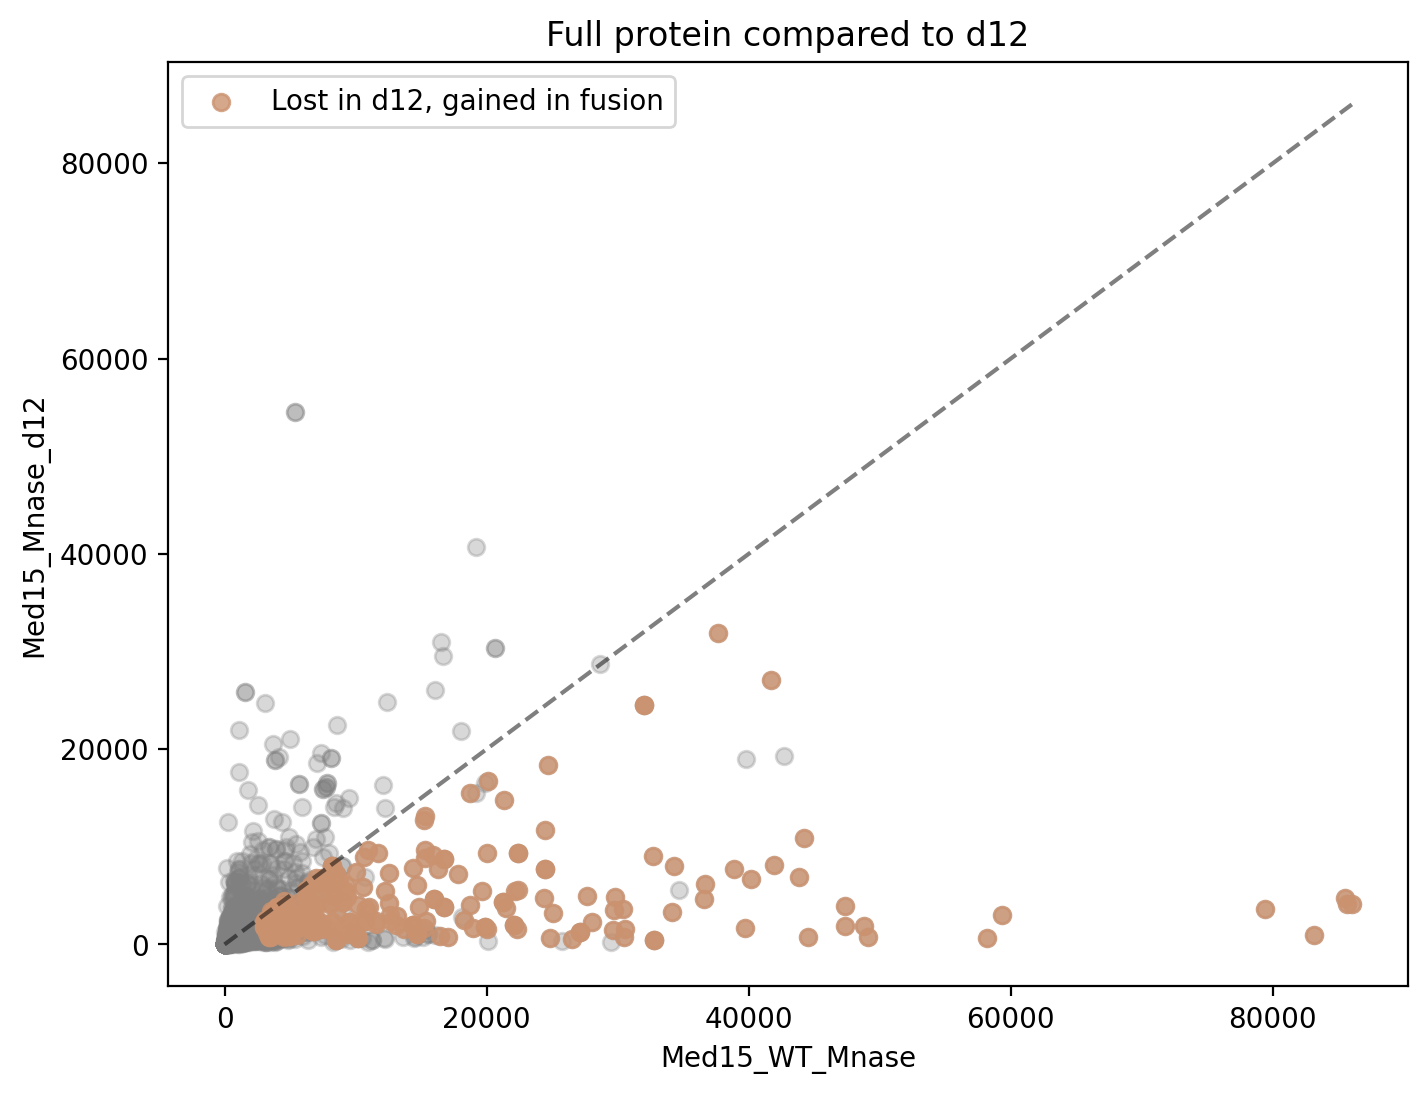

In [25]:
fig, axes = plt.subplots(1, figsize=(8, 6))
plt.scatter(Figure_4B['Med15_WT_Mnase'], Figure_4B['Med15_Mnase_d12'], 
        alpha=0.3, 
        color='grey'
    )
plt.scatter(
        Figure_4B['Med15_WT_Mnase'].loc[lost_in_d12_gained_in_fusion], Figure_4B['Med15_Mnase_d12'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion'
    )

max_val = max(Figure_4B['Med15_Mnase_d12'].max(), Figure_4B['Med15_WT_Mnase'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
plt.ylabel('Med15_Mnase_d12')
plt.xlabel('Med15_WT_Mnase')
plt.legend()
plt.title(f'Full protein compared to d12')
plt.show()

### FIgure 4D

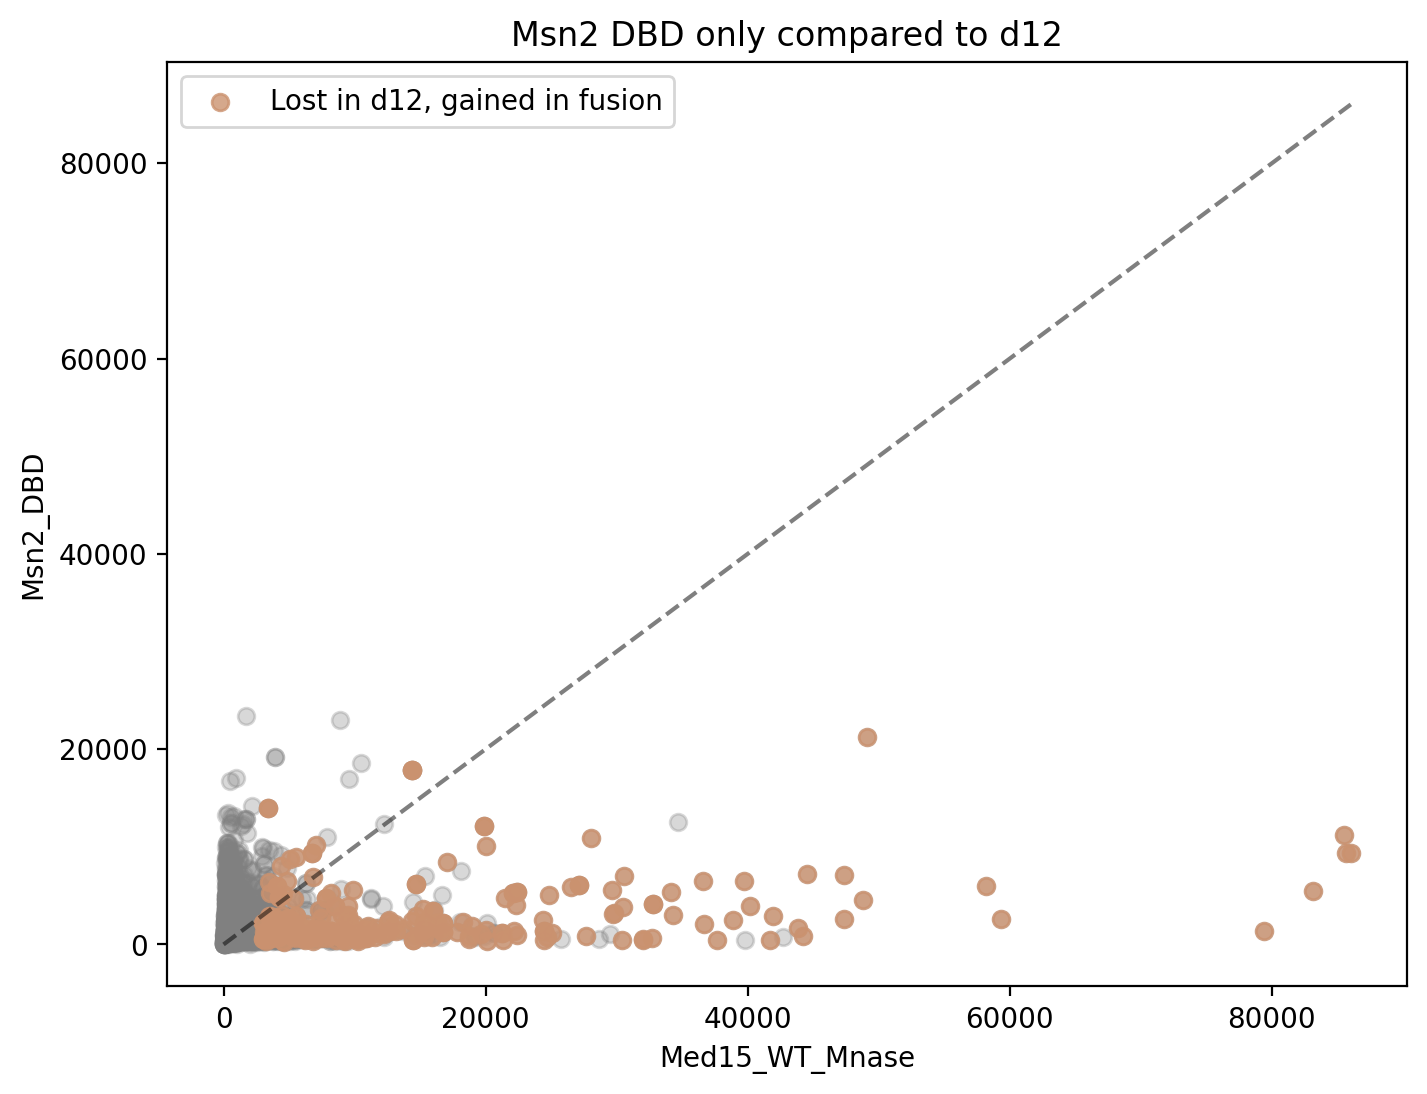

In [26]:
fig, axes = plt.subplots(1, figsize=(8, 6))
plt.scatter(Figure_4B['Med15_WT_Mnase'], Figure_4B['Msn2_DBD'], 
        alpha=0.3, 
        color='grey'
    )
plt.scatter(
        Figure_4B['Med15_WT_Mnase'].loc[lost_in_d12_gained_in_fusion], Figure_4B['Msn2_DBD'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion'
    )

max_val = max(Figure_4B['Msn2_DBD'].max(), Figure_4B['Med15_WT_Mnase'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
plt.ylabel('Msn2_DBD')
plt.xlabel('Med15_WT_Mnase')
plt.legend()
plt.title(f'Msn2 DBD only compared to d12')
plt.show()

### Figure 4F

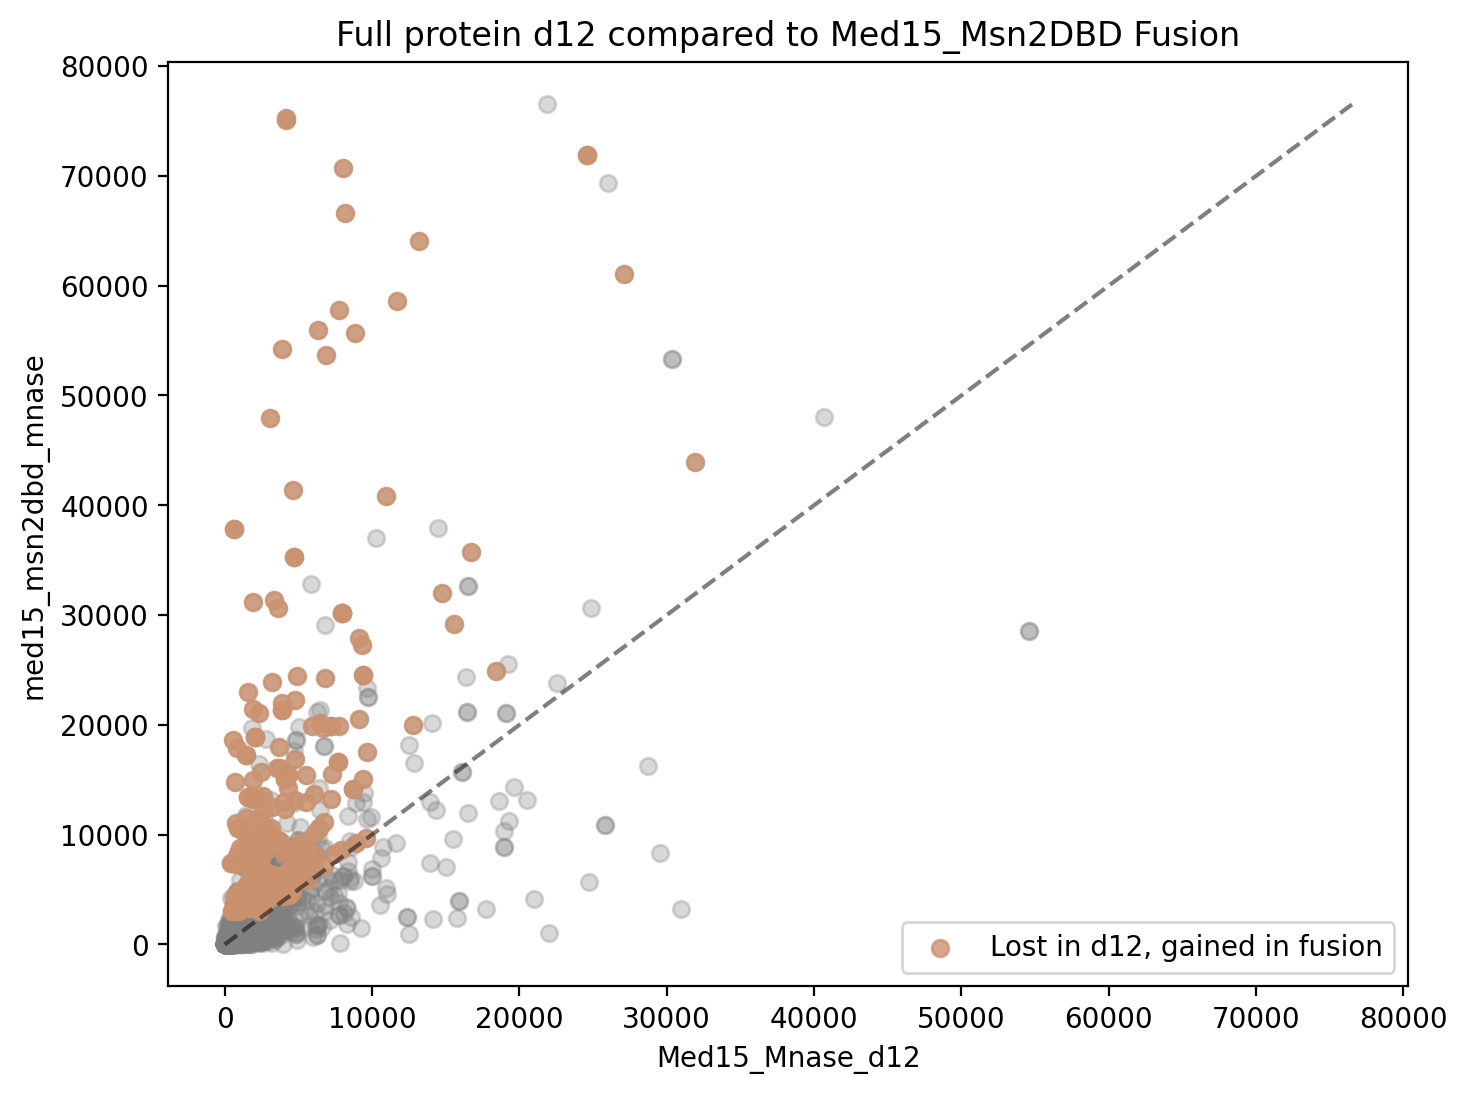

In [27]:
fig, axes = plt.subplots(1, figsize=(8, 6))
plt.scatter(Figure_4B['Med15_Mnase_d12'], d12_system_data['med15_msn2dbd_mnase'], 
        alpha=0.3, 
        color='grey'
    )
plt.scatter(
        Figure_4B['Med15_Mnase_d12'].loc[lost_in_d12_gained_in_fusion], d12_system_data['med15_msn2dbd_mnase'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion'
    )

max_val = max(d12_system_data['med15_msn2dbd_mnase'].max(), Figure_4B['Med15_Mnase_d12'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
plt.ylabel('med15_msn2dbd_mnase')
plt.xlabel('Med15_Mnase_d12')
plt.legend()
plt.title(f'Full protein d12 compared to Med15_Msn2DBD Fusion')
plt.show()

# Figure 5

### Figure 5A

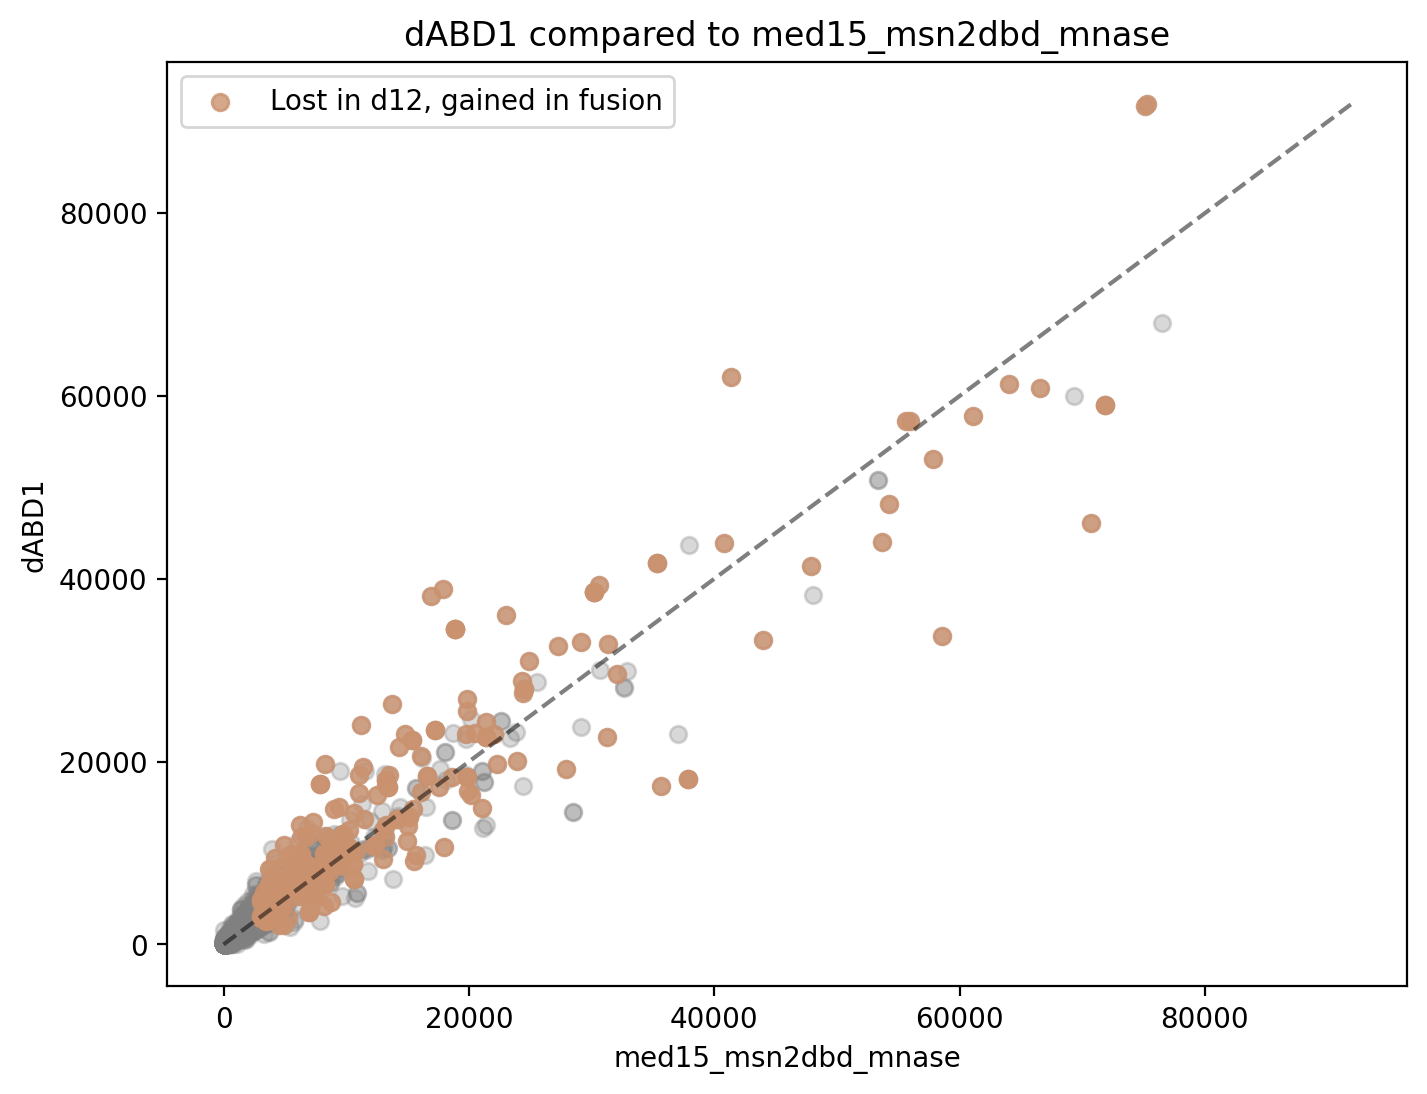

In [28]:
fig, axes = plt.subplots(1, figsize=(8, 6))
plt.scatter(d12_system_data['med15_msn2dbd_mnase'], d12_system_data['dABD1'],
        alpha=0.3, 
        color='grey'
    )
plt.scatter(
         d12_system_data['med15_msn2dbd_mnase'].loc[lost_in_d12_gained_in_fusion],d12_system_data['dABD1'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(d12_system_data['med15_msn2dbd_mnase'].max(), d12_system_data['dABD1'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
plt.xlabel('med15_msn2dbd_mnase')
plt.ylabel('dABD1')
plt.legend()
plt.title(f'dABD1 compared to med15_msn2dbd_mnase')
plt.show()

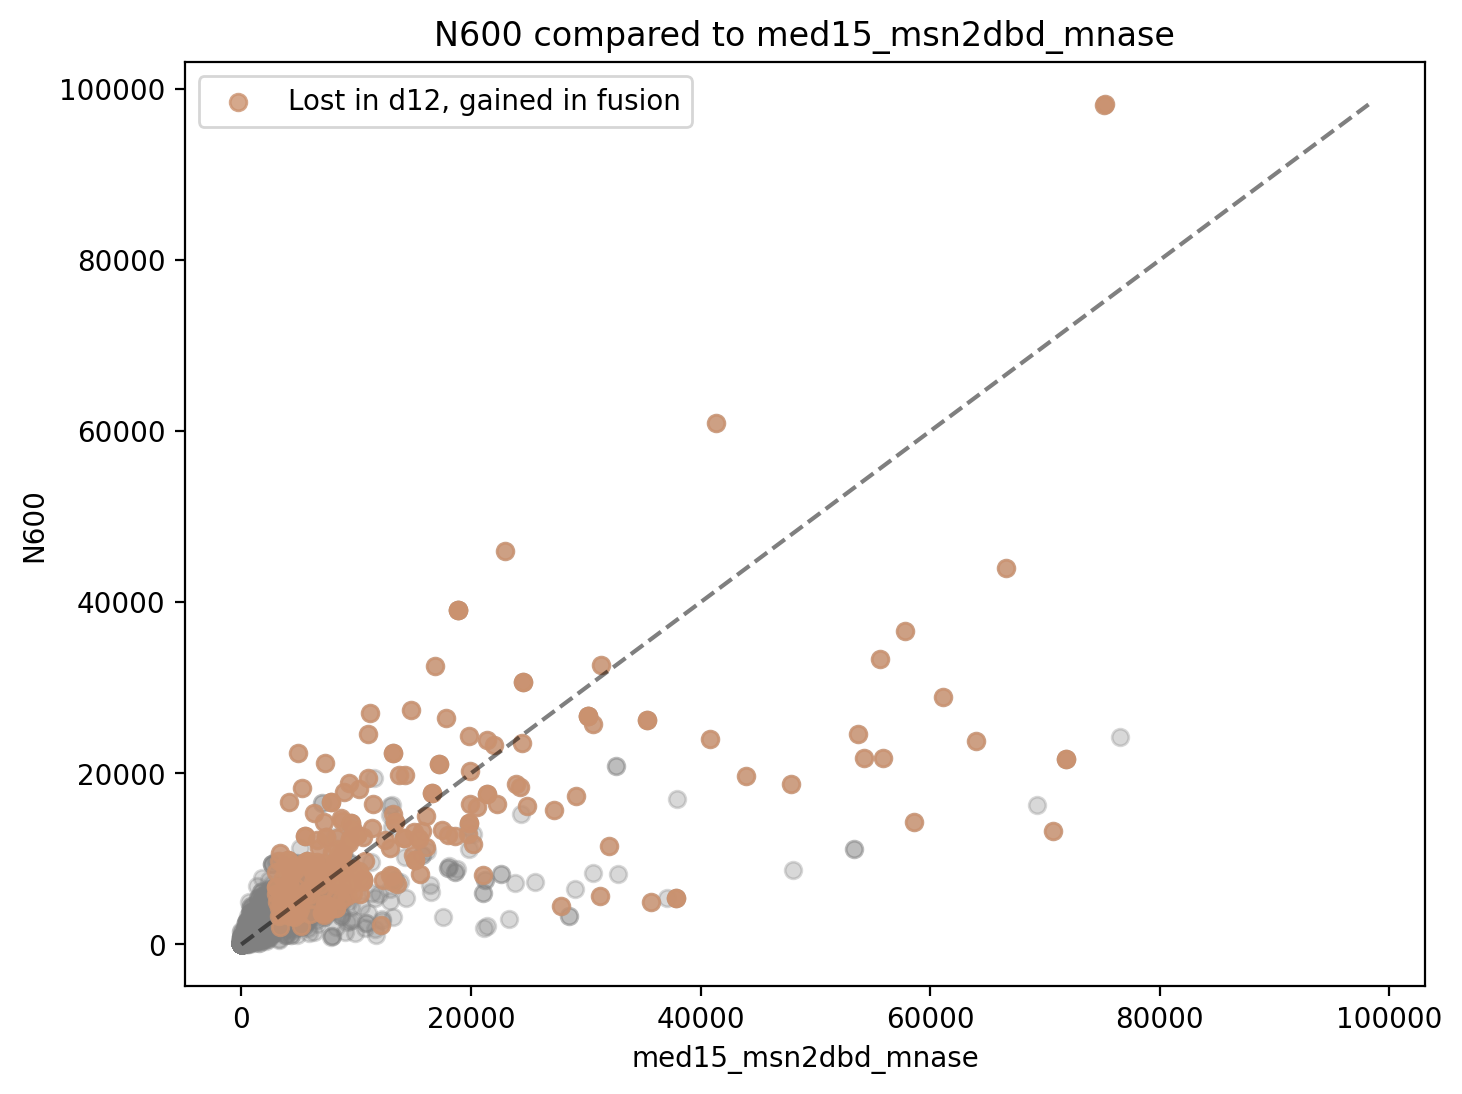

In [29]:
fig, axes = plt.subplots(1, figsize=(8, 6))
plt.scatter(d12_system_data['med15_msn2dbd_mnase'], d12_system_data['N600'],
        alpha=0.3, 
        color='grey'
    )
plt.scatter(
         d12_system_data['med15_msn2dbd_mnase'].loc[lost_in_d12_gained_in_fusion],d12_system_data['N600'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(d12_system_data['med15_msn2dbd_mnase'].max(), d12_system_data['N600'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
plt.xlabel('med15_msn2dbd_mnase')
plt.ylabel('N600')
plt.legend()
plt.title(f'N600 compared to med15_msn2dbd_mnase')
# plt.savefig('/home/labs/barkailab/aileenc/Med15_project/Paper/Figures/Figure5_Fusion_N600.pdf', dpi=300, format='pdf')
plt.show()

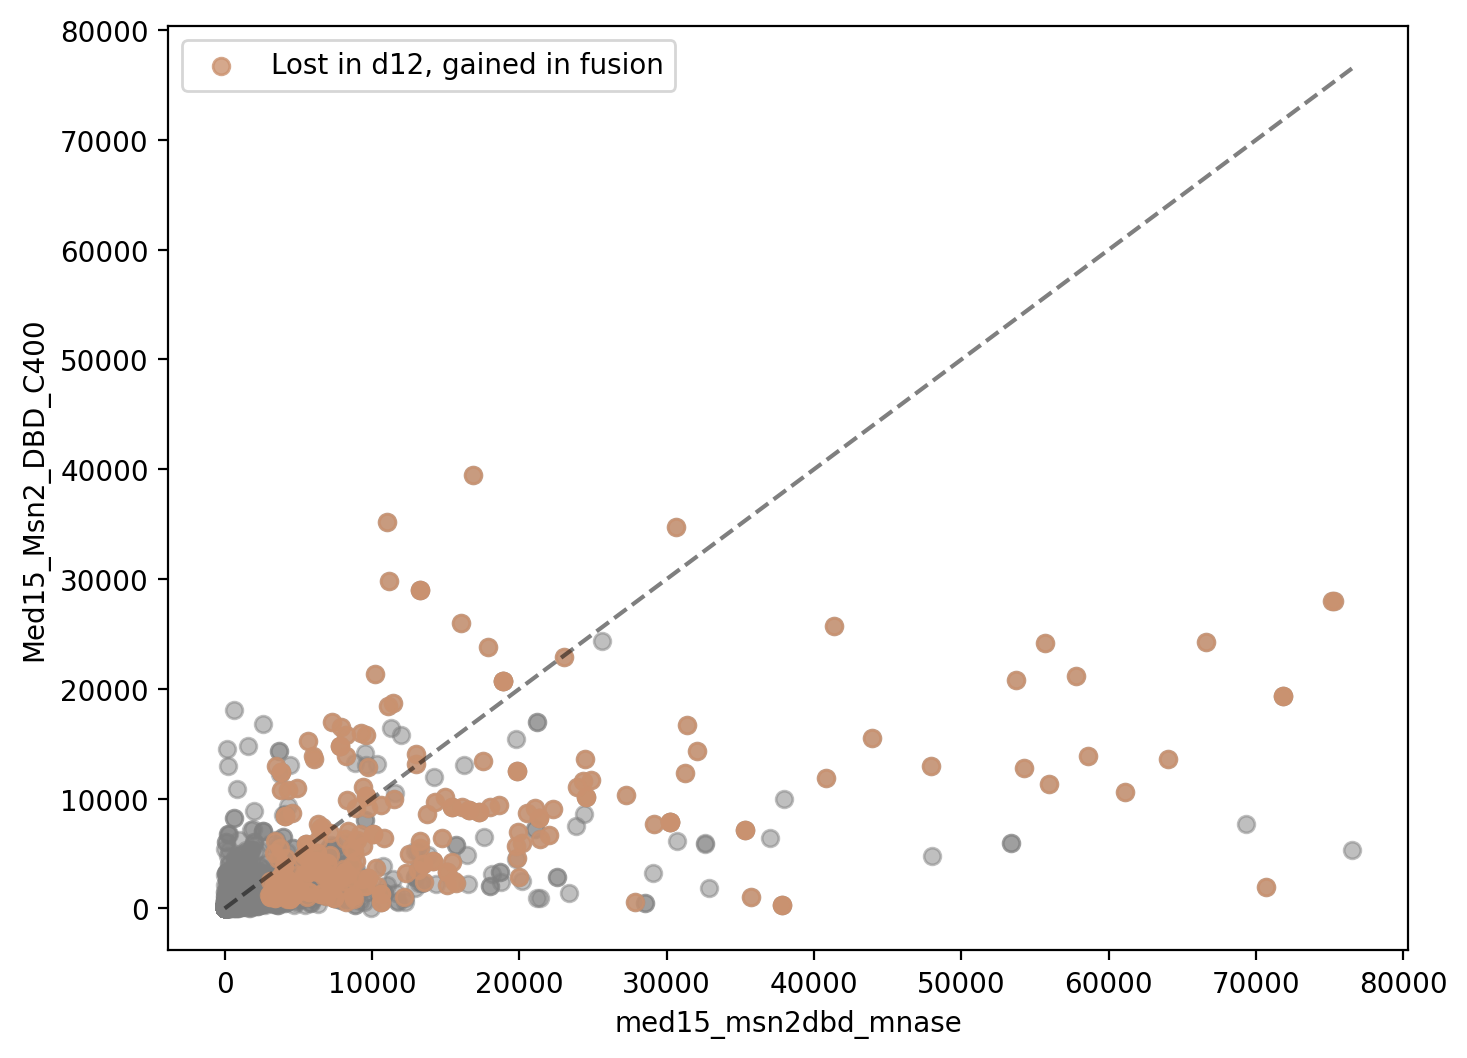

In [30]:
fig, axes = plt.subplots(1, figsize=(8, 6))
plt.scatter(d12_system_data['med15_msn2dbd_mnase'], d12_system_data['Med15_Msn2_DBD_C400'],
        alpha=0.5, 
        color='grey'
    )
plt.scatter(
         d12_system_data['med15_msn2dbd_mnase'].loc[lost_in_d12_gained_in_fusion],d12_system_data['Med15_Msn2_DBD_C400'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(d12_system_data['med15_msn2dbd_mnase'].max(), d12_system_data['Med15_Msn2_DBD_C400'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
plt.xlabel('med15_msn2dbd_mnase')
plt.ylabel('Med15_Msn2_DBD_C400')
plt.legend()

### Figure 5B

In [31]:
column_mapping = {
    'Med15_200_400': 'd200_400',
    'Med15_700_900': 'd700_900',
    'Med15_800_1000': 'd800_1000',
    'Med15_N100': 'N100',
    'Med15_N200': 'N200',
    'Med15_N300': 'N300',
    'Med15_N400': 'N400',
    'Med15_N600': 'N600',
    'Med15_N800': 'N800',
    'Med15_C100': 'Med15_Msn2_DBD_C100',
    'Med15_C200': 'Med15_Msn2_DBD_C200',
    'Med15_C300': 'Med15_Msn2_DBD_C300',
    'Med15_C400': 'Med15_Msn2_DBD_C400',
    'Med15_C600': 'Med15_Msn2_DBD_C600',
    'Med15_C700': 'Med15_Msn2_DBD_C700',
    'Med15_C800': 'Med15_Msn2_DBD_C800',  
    'Med15_dABD1': 'dABD1',
    'Med15_dABD2': 'dABD2',
    'Med15_dABD3': 'dABD3',
    'Med15_dDBD': 'dDBD'
}

WT_columns = ['Med15_WT_Mnase'] + list(column_mapping.keys())
msn2_columns = ['med15_msn2dbd_mnase'] + list(column_mapping.values())


WT_filtered = WT_system_data[WT_columns].rename(columns=column_mapping)


msn2_filtered = d12_system_data[msn2_columns]

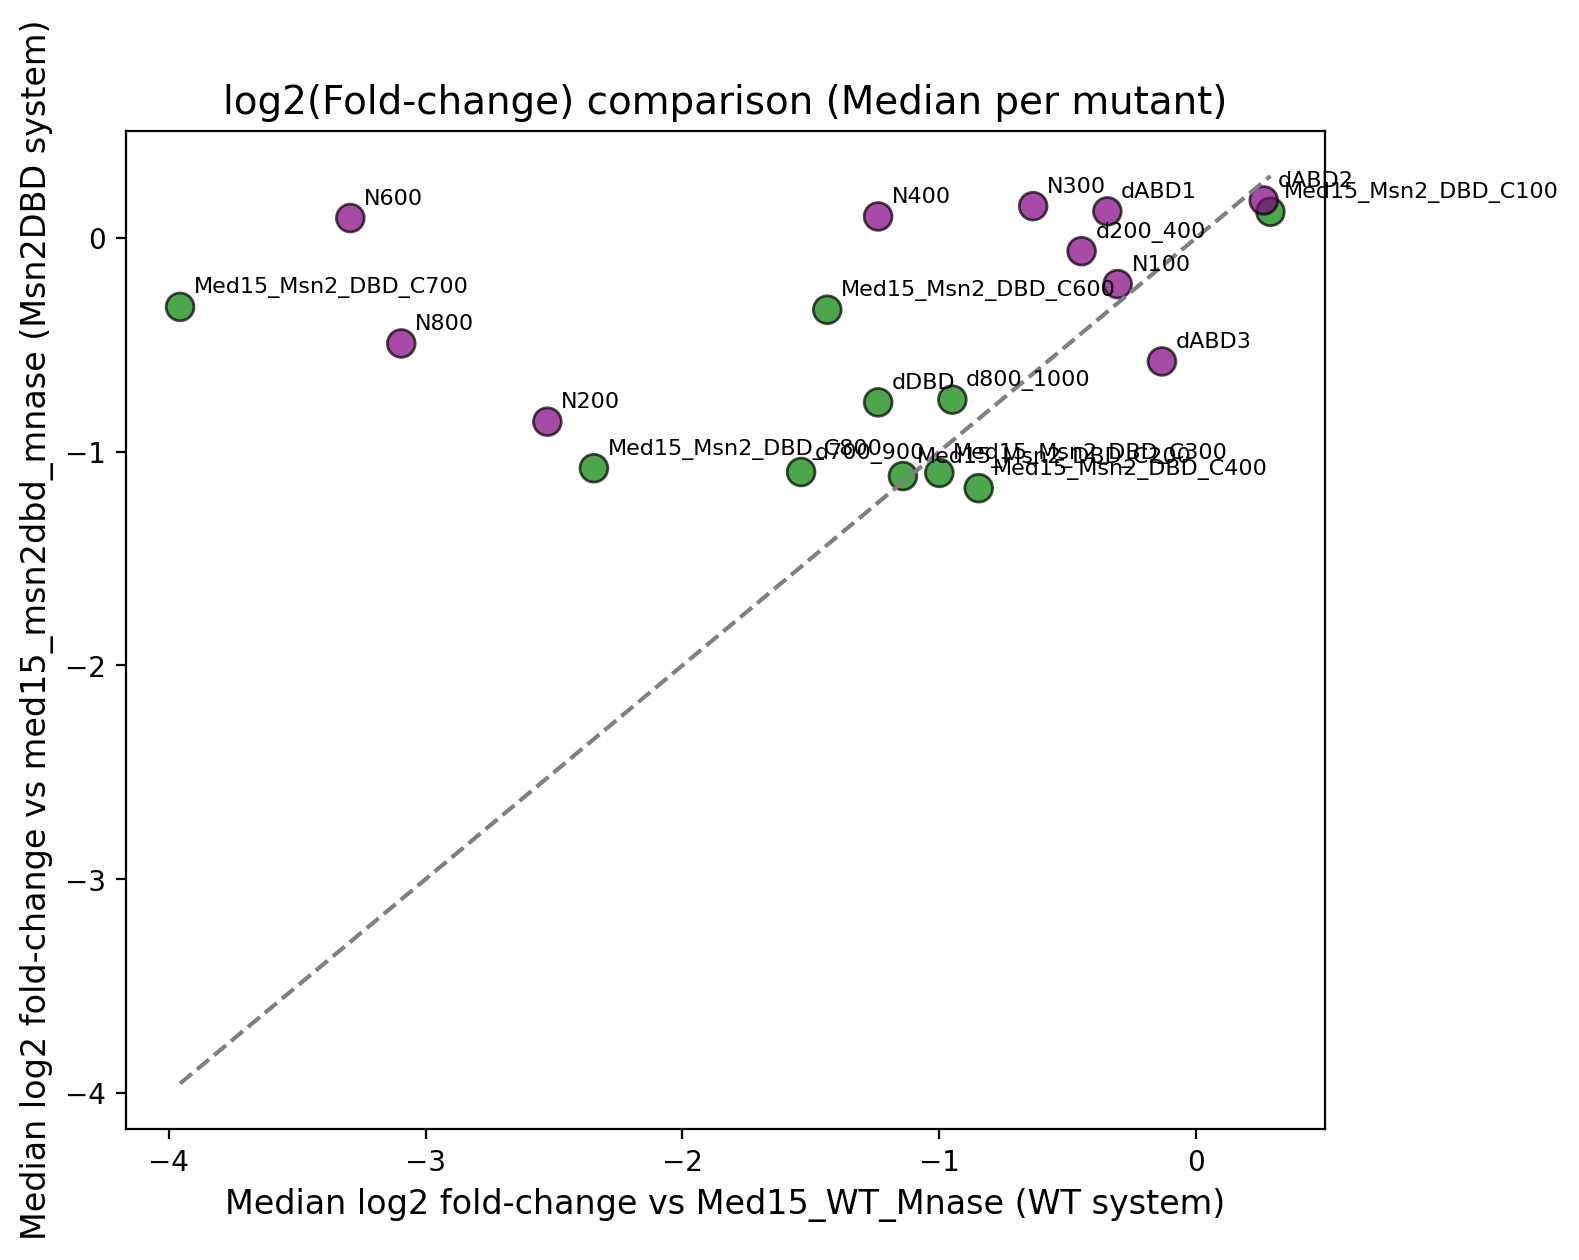

In [54]:

color_rules = [
    (r'd200|N100|N200|N300|N400|N600|N800|dABD1|dABD2|dABD3', 'purple'),
    (r'd700_900|d800_1000|dDBD|Med15_Msn2_DBD_C', 'green'),
]

labels = [name for name in WT_filtered.corr().index]


WT_sub = WT_filtered.loc[WT_filtered.index.intersection(lost_in_d12_gained_in_fusion)]
msn2_sub = msn2_filtered.loc[msn2_filtered.index.intersection(lost_in_d12_gained_in_fusion)]

colors = []

mutant_columns_WT = [col for col in WT_filtered.columns if col != 'Med15_WT_Mnase']
mutant_columns_msn2 = [col for col in msn2_filtered.columns if col != 'med15_msn2dbd_mnase']


mutant_columns_WT.sort()
mutant_columns_msn2.sort()

x_log2_medians = []
y_log2_medians = []
labels = []

for wt_col, msn2_col in zip(mutant_columns_WT, mutant_columns_msn2):

    wt_valid = WT_sub[(WT_sub['Med15_WT_Mnase'] > 0) & WT_sub[wt_col].notna()]
    msn2_valid = msn2_sub[(msn2_sub['med15_msn2dbd_mnase'] > 0) & msn2_sub[msn2_col].notna()]

    wt_fold_change = wt_valid[wt_col] / wt_valid['Med15_WT_Mnase']
    msn2_fold_change = msn2_valid[msn2_col] / msn2_valid['med15_msn2dbd_mnase']

    wt_fold_change = wt_fold_change[wt_fold_change > 0]
    msn2_fold_change = msn2_fold_change[msn2_fold_change > 0]

    wt_log2_fc = np.log2(wt_fold_change)
    msn2_log2_fc = np.log2(msn2_fold_change)

    x_median = wt_log2_fc.median(skipna=True)
    y_median = msn2_log2_fc.median(skipna=True)

    x_log2_medians.append(x_median)
    y_log2_medians.append(y_median)
    labels.append(wt_col)

    # Assign color based on wt_col
    assigned = False
    for pattern, color in color_rules:
        if re.search(pattern, wt_col):
            colors.append(color)
            assigned = True
            break

all_vals = x_log2_medians + y_log2_medians
min_lim = min(all_vals)
max_lim = max(all_vals)


pad = 0.0 *(max_lim - min_lim)
plot_min = min_lim - pad
plot_max = max_lim + pad

plt.figure(figsize=(8, 6))
plt.scatter(x_log2_medians, y_log2_medians, color=colors, edgecolor='k', s=100, alpha=0.7,rasterized=True)


plt.plot([plot_min,plot_max],[plot_min,plot_max], color='grey', linestyle='--')



for label, x, y in zip(labels, x_log2_medians, y_log2_medians):
    plt.annotate(label, (x, y), fontsize=8, xytext=(5, 5), textcoords='offset points')

plt.xlabel('Median log2 fold-change vs Med15_WT_Mnase (WT system)', fontsize=12)
plt.ylabel('Median log2 fold-change vs med15_msn2dbd_mnase (Msn2DBD system)', fontsize=12)
plt.title('log2(Fold-change) comparison (Median per mutant)', fontsize=14)
plt.tight_layout()

plt.show()

In [75]:
for_corr = d12_system_data[['Msn2_DBD','Med15_Msn2_DBD_C980','Med15_Mnase_LIVFWY_Shift_DBD_END','Med15_Msn2DBD_DBD_END_LIVFWY_N','dDBD','d800_1000','d700_900','Med15_Msn2_DBD_C800','Med15_Msn2_DBD_C700','Med15_Msn2_DBD_C600','Med15_Msn2_DBD_C500','Med15_Msn2_DBD_C400','Med15_Msn2_DBD_C300','Med15_Msn2_DBD_C200','Med15_Msn2_DBD_C100','Med15_Msn2DBD_DBD_END_QN_G', 'Med15_Msn2DBD_DBD_END_Q_N','N900','N800','N600','N400','N300','N200','N100','Fusion_dABD1_dABD2_dABD3','Fusion_dABD2_dABD3','dABD3','dABD2','dABD1','med15_msn2dbd_mnase']]

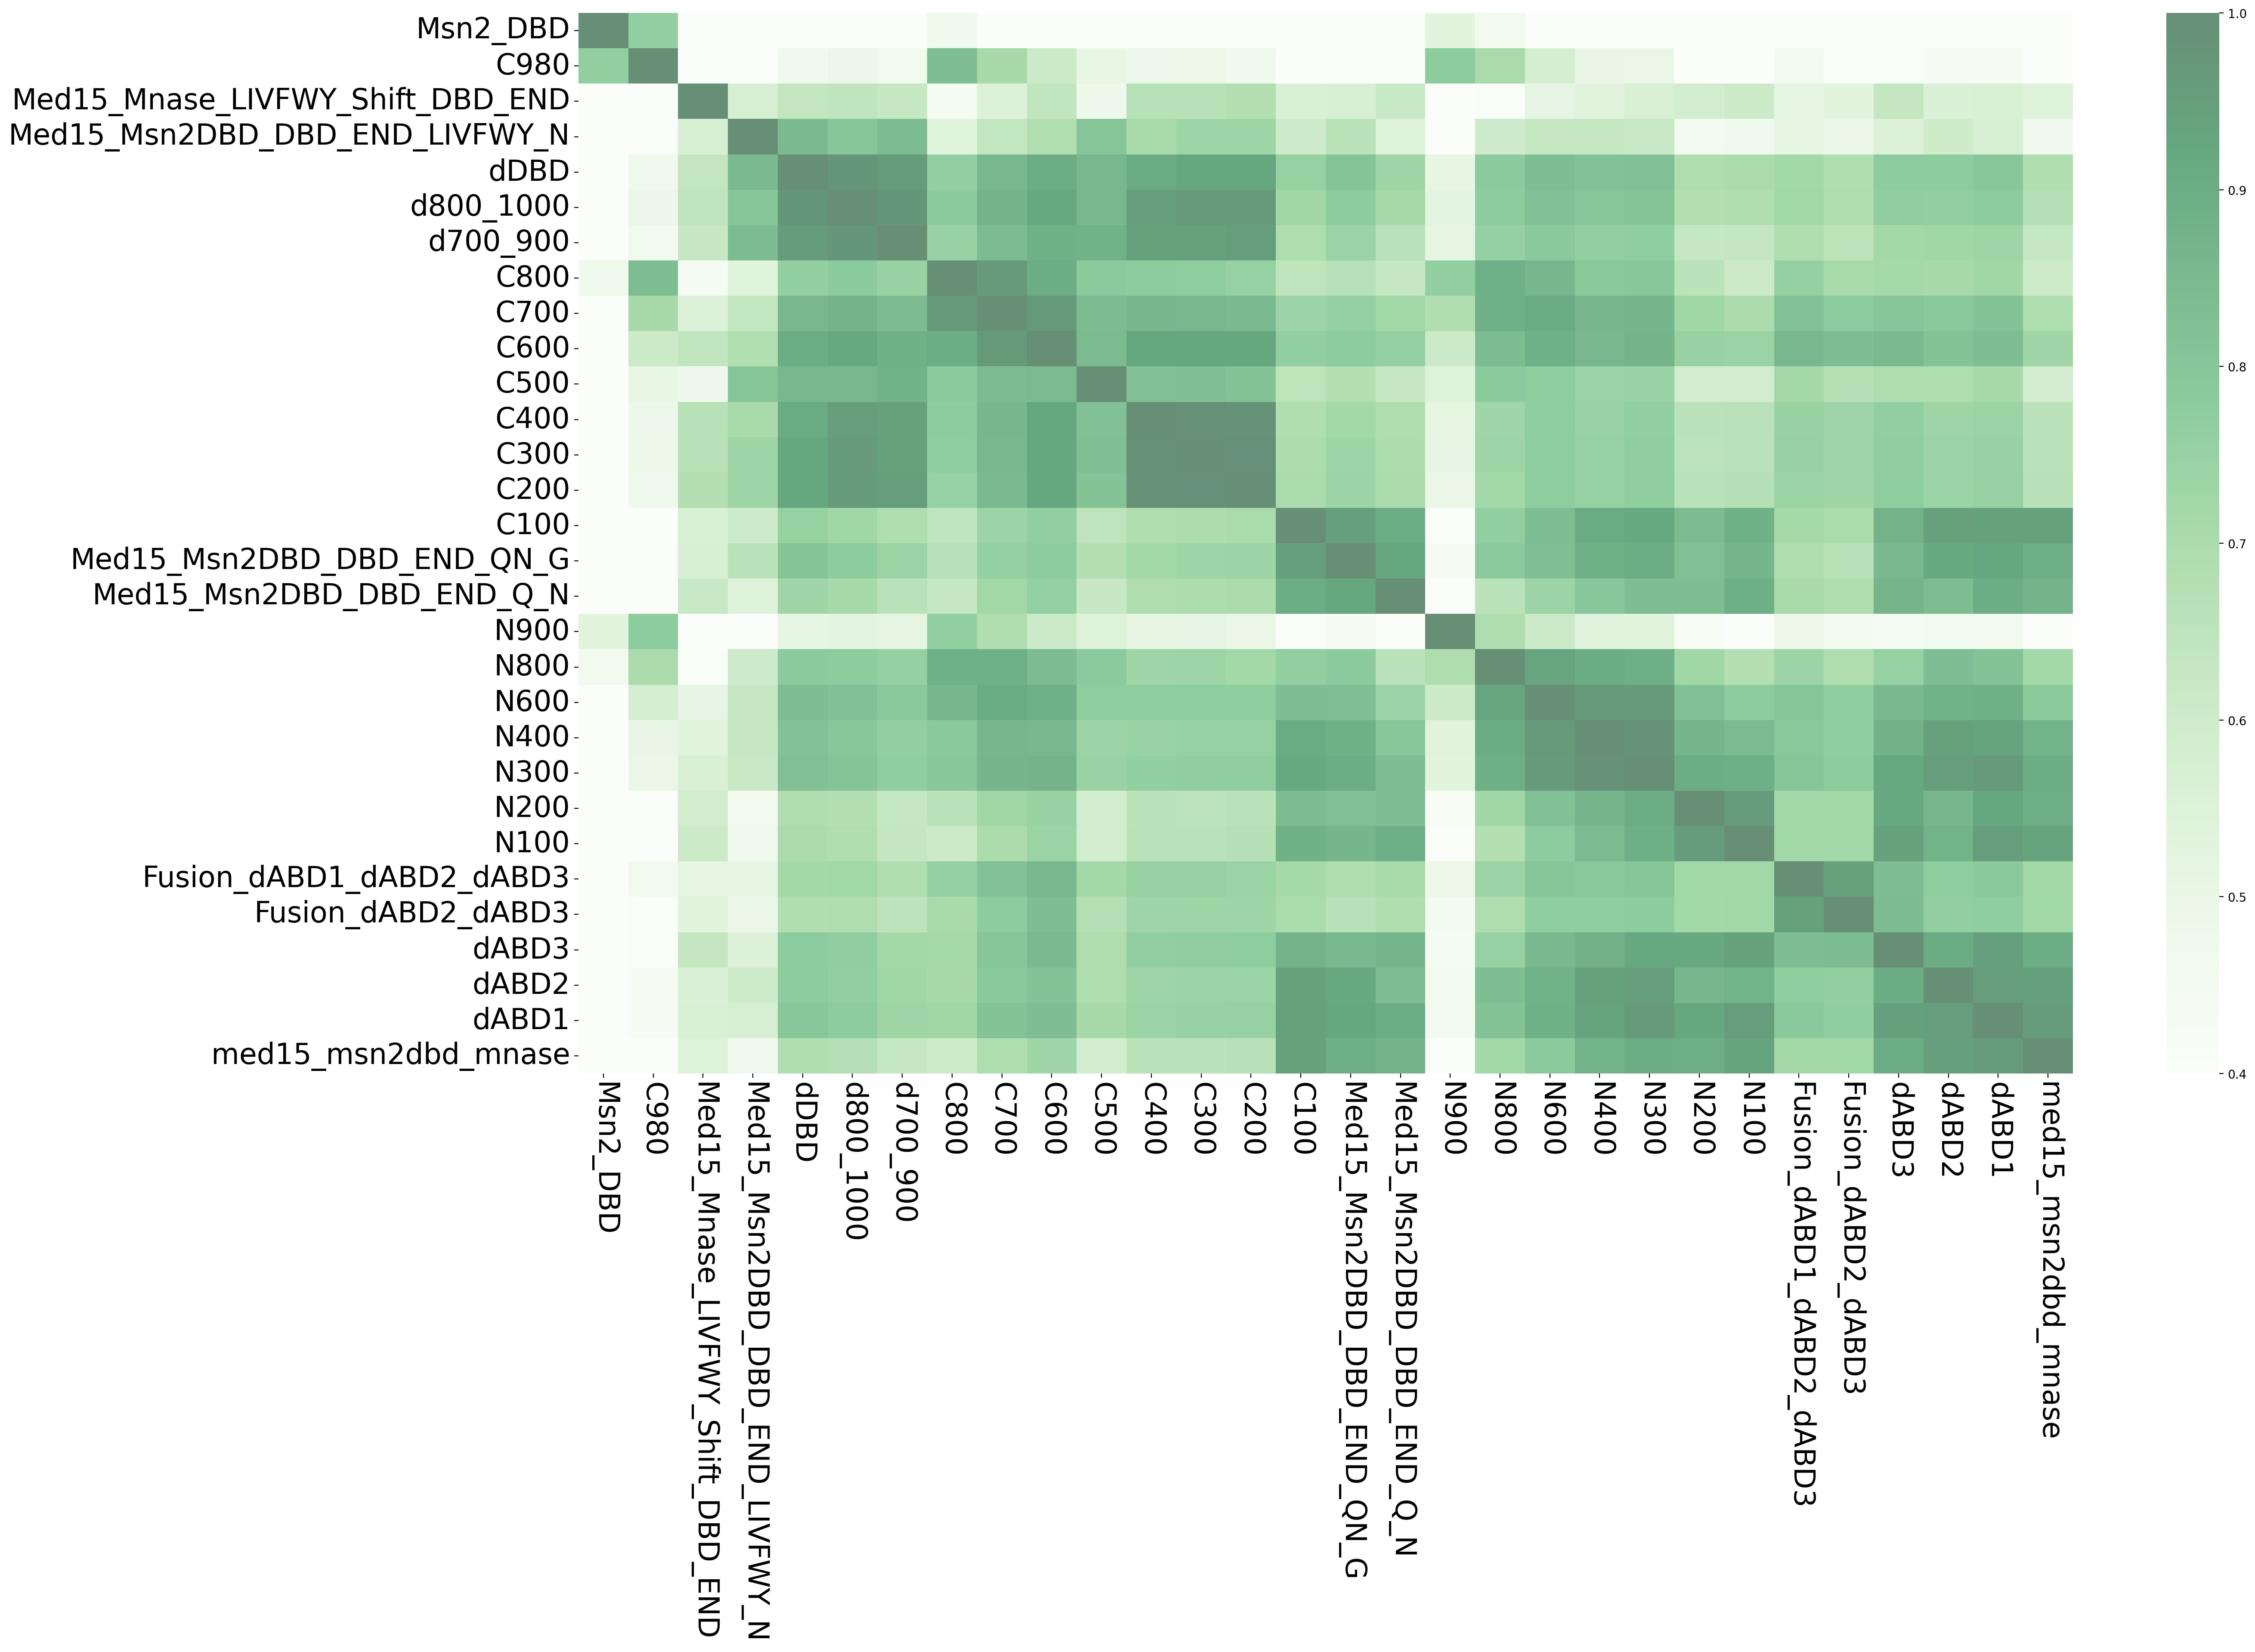

In [77]:
corr_matrix = for_corr.corr().abs()

filtered_corr_matrix = corr_matrix

plt.subplots(figsize=(28,16))
heatmap = sns.heatmap(filtered_corr_matrix,  cmap=pastel_cmap, vmax=1, vmin=0.4, annot_kws={"size": 15, 'rotation':0})

short_labels = [label.get_text().replace('Med15_Msn2_DBD_', '') for label in heatmap.get_xticklabels()]
heatmap.set_xticklabels(short_labels, size=24, rotation=270)
short_labels = [label.get_text().replace('Med15_Msn2_DBD_', '') for label in heatmap.get_yticklabels()]
heatmap.set_yticklabels(short_labels, size=24, rotation=0)

plt.show()

## Figure 6

### Figure 6A - C

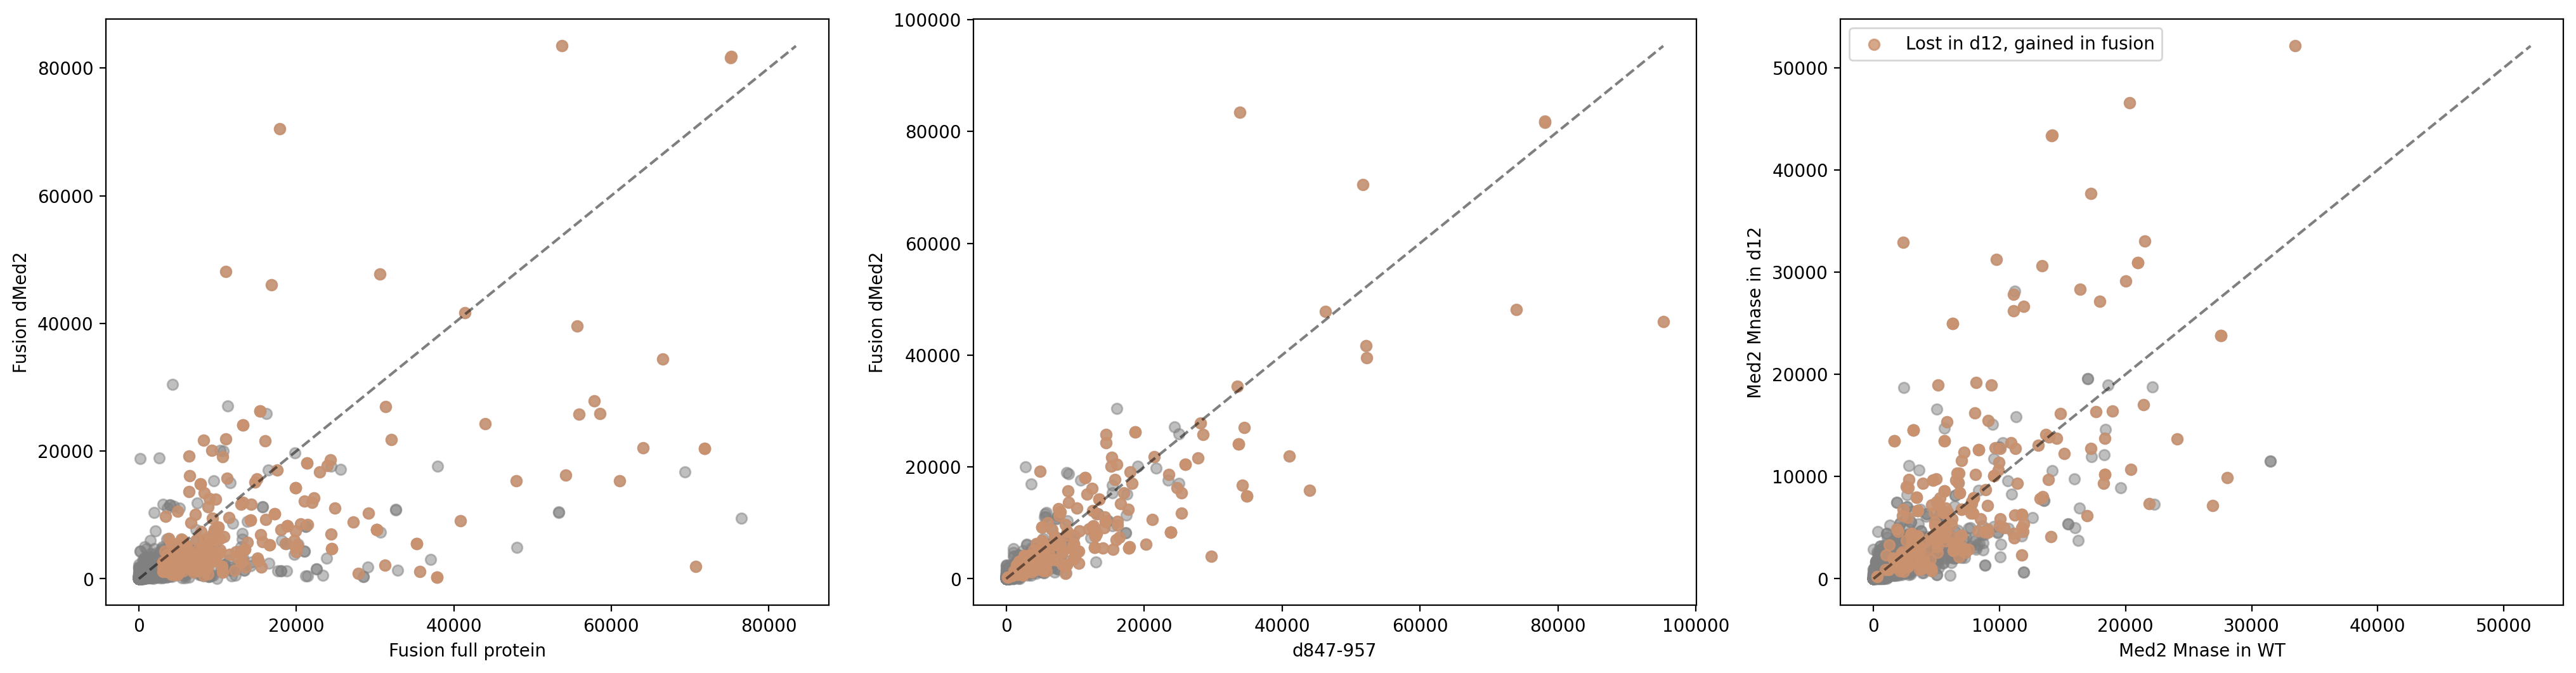

In [82]:
fig, axes = plt.subplots(1,3, figsize=(25, 6))
axes[0].scatter( d12_system_data['med15_msn2dbd_mnase'], d12_system_data['Med15_Fusion_dMed2'],
        alpha=0.5, 
        color='grey'
    )
axes[0].scatter(
         d12_system_data['med15_msn2dbd_mnase'].loc[lost_in_d12_gained_in_fusion],d12_system_data['Med15_Fusion_dMed2'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(d12_system_data['med15_msn2dbd_mnase'].max(), d12_system_data['Med15_Fusion_dMed2'].max())
axes[0].plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
axes[0].set_xlabel('Fusion full protein')
axes[0].set_ylabel('Fusion dMed2')

axes[1].scatter(  d12_system_data['dDBD'], d12_system_data['Med15_Fusion_dMed2'],
        alpha=0.5, 
        color='grey'
    )
axes[1].scatter(
         d12_system_data['dDBD'].loc[lost_in_d12_gained_in_fusion],d12_system_data['Med15_Fusion_dMed2'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(d12_system_data['dDBD'].max(), d12_system_data['Med15_Fusion_dMed2'].max())
axes[1].plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
axes[1].set_xlabel('d847-957')
axes[1].set_ylabel('Fusion dMed2')

axes[2].scatter(WT_system_data['Med2_Mnase'], d12_system_data['d12_Med2_Mnase'],
        alpha=0.5, 
        color='grey'
    )
axes[2].scatter(
         WT_system_data['Med2_Mnase'].loc[lost_in_d12_gained_in_fusion],d12_system_data['d12_Med2_Mnase'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(WT_system_data['Med2_Mnase'].max(), d12_system_data['d12_Med2_Mnase'].max())
axes[2].plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
axes[2].set_xlabel('Med2 Mnase in WT')
axes[2].set_ylabel('Med2 Mnase in d12')


plt.legend()

plt.show()

### Figure 6D

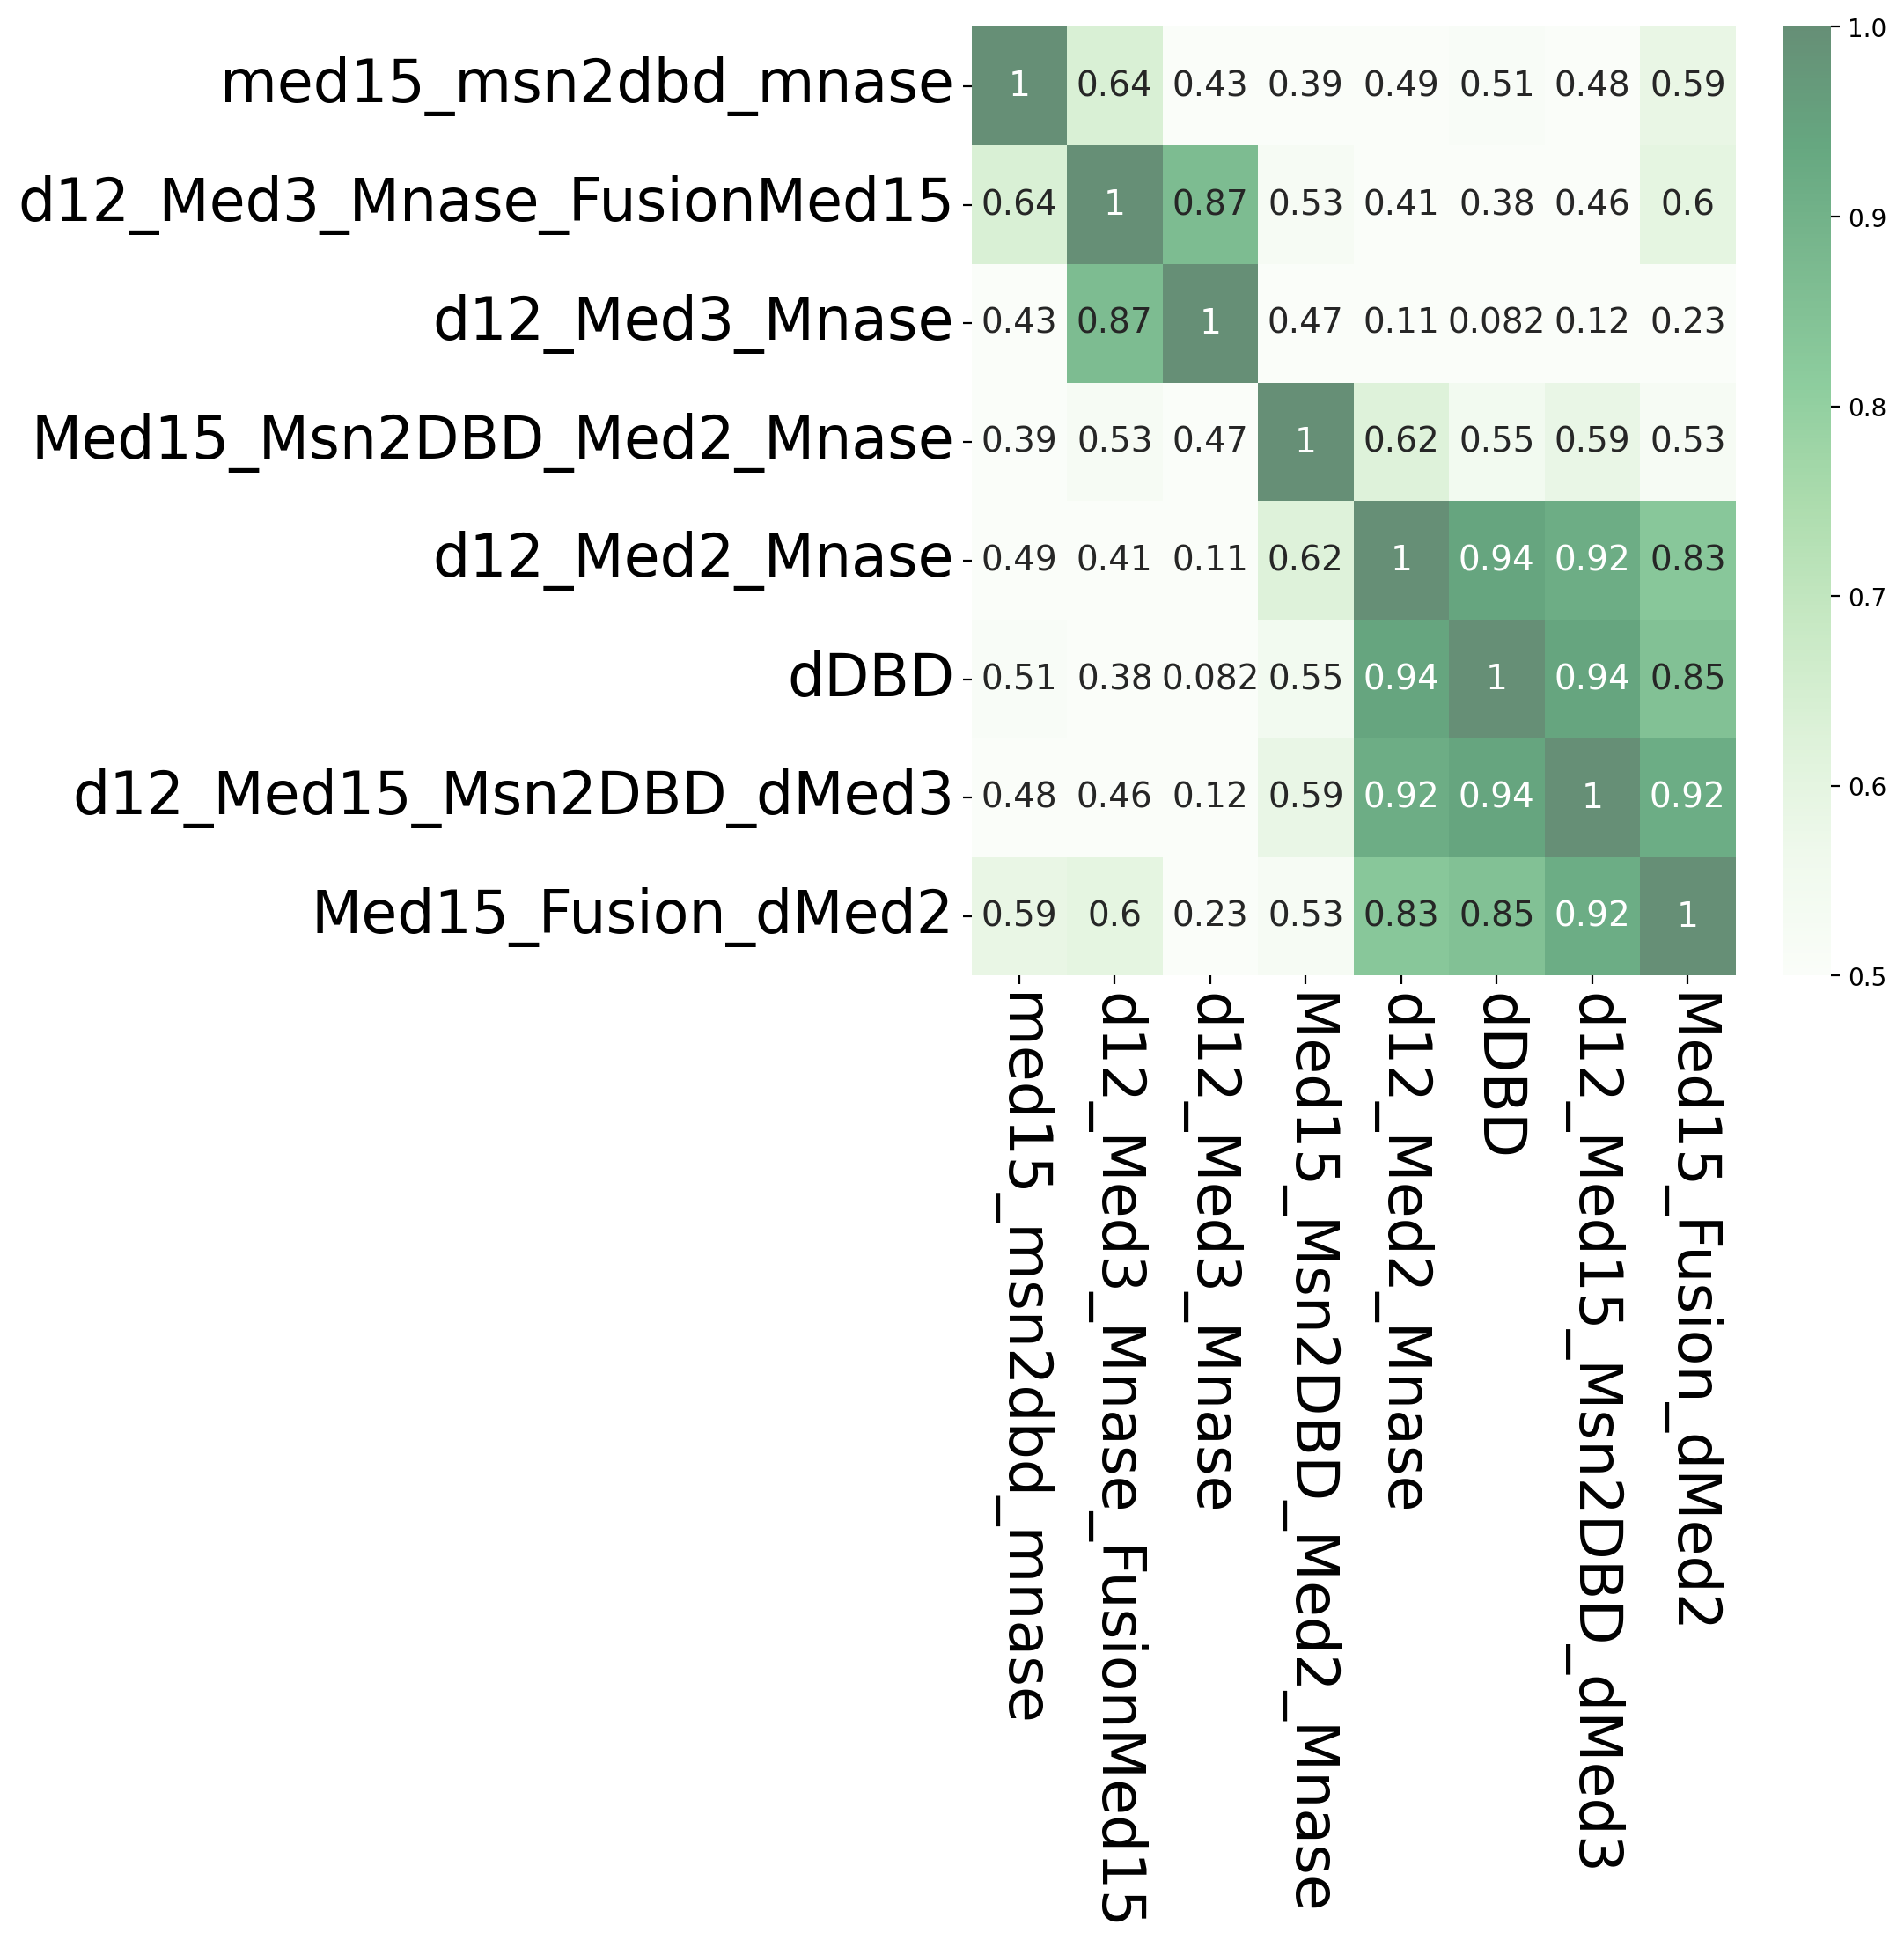

In [84]:
df = d12_system_data[['med15_msn2dbd_mnase','d12_Med3_Mnase_FusionMed15','d12_Med3_Mnase','Med15_Msn2DBD_Med2_Mnase',
         'd12_Med2_Mnase', 'dDBD',
        'd12_Med15_Msn2DBD_dMed3', 'Med15_Fusion_dMed2']]

corr_matrix = df.loc[lost_in_d12_gained_in_fusion].corr().abs()


filtered_corr_matrix = corr_matrix

plt.subplots(figsize=(7,7))
heatmap = sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2g", cmap=pastel_cmap, vmax=1, vmin=0.5, annot_kws={"size": 14, 'rotation':0})

plt.show()

# Supplementary Figure 1

### S.Figure 1A

In [90]:
SFig_1A_Floc = Flocculation.T.filter(regex='WT|N100|N200|100-300|KIX')

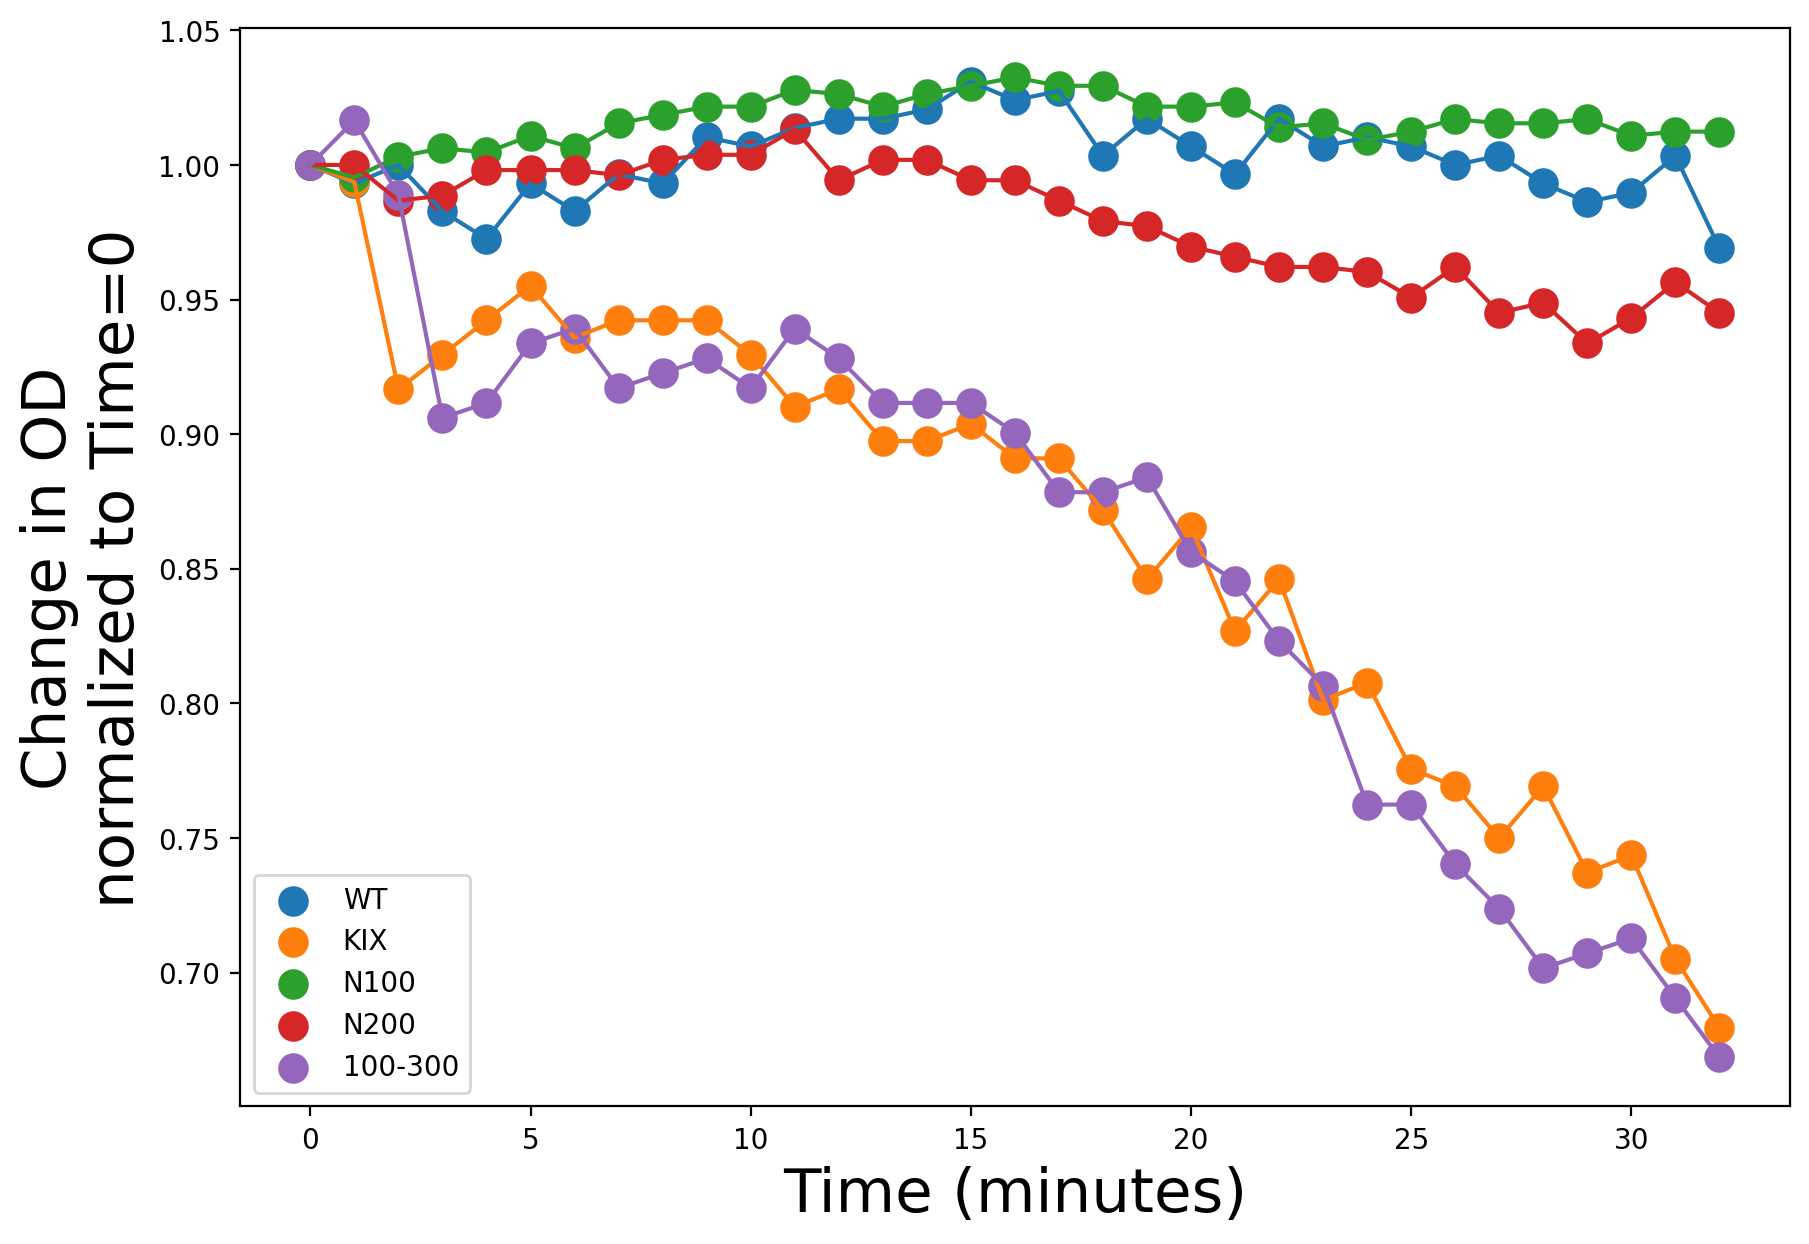

In [92]:
plt.subplots(figsize=(10,7))
for idx, column in enumerate(SFig_1A_Floc):
    x_values = range(0,33)
    y_values = SFig_1A_Floc[column]

    plt.scatter(x_values, y_values,s=100, label = column)
    plt.plot(x_values, y_values)

plt.xlabel('Time (minutes)',fontsize=22)
plt.ylabel('Change in OD \nnormalized to Time=0',fontsize=22)
plt.legend()
plt.show()

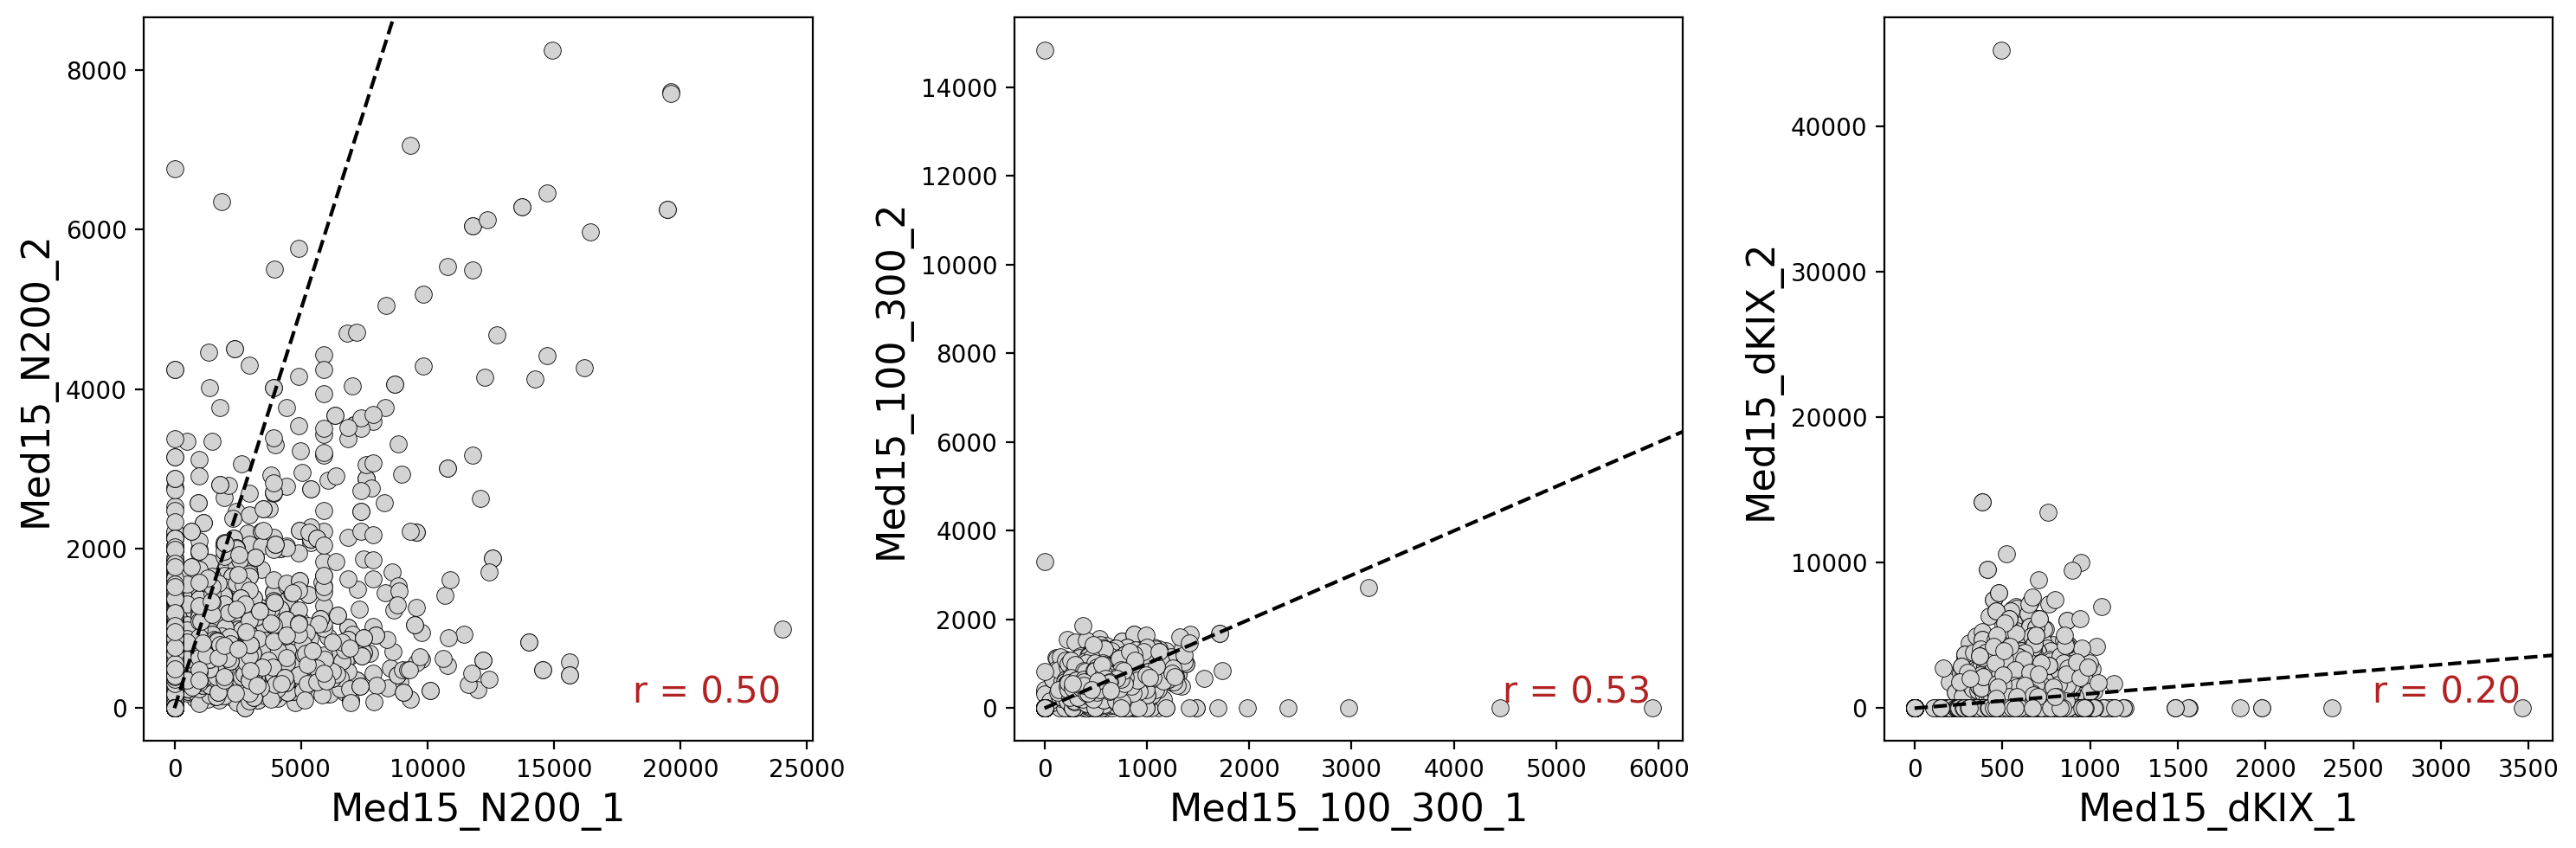

In [94]:
SFig_2A = Repeats[['Med15_N200_1', 'Med15_N200_2','Med15_100_300_1', 'Med15_100_300_2','Med15_dKIX_1', 'Med15_dKIX_2']]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

scatter_pairs = [
    ('Med15_N200_1', 'Med15_N200_2'),
    ( 'Med15_100_300_1', 'Med15_100_300_2'),
    ('Med15_dKIX_1','Med15_dKIX_2')
]


for i, (x_col, y_col) in enumerate(scatter_pairs):
    ax = axes[i]  
    x_data = SFig_2A[x_col]
    y_data = SFig_2A[y_col]
    correlation = np.corrcoef(x_data, y_data)[0, 1]
    ax.scatter(x_data, y_data, c='lightgrey', s=50, ec='k',lw=0.3)


    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    xy_min, xy_max = min(x_data.min(), y_data.min()), max(x_data.max(), y_data.max())
    ax.plot([xy_min, xy_max], [xy_min, xy_max], linestyle="--", color="k")


    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    # Labels
    ax.set_xlabel(x_col, fontsize=16)
    ax.set_ylabel(y_col, fontsize=16)
    
    ax.text(
        x_lim[1] * 0.95,
        y_lim[0] * 0.09,   
        f"r = {correlation:.2f}",
        fontsize=15,
        color="firebrick",
        ha="right",
        va="bottom",
    )

plt.show()

### S.Figure 1B

In [95]:
def get_strain_name(col):
    return re.sub(r'_\d+$', '', col)  


def get_repeat_pairs(df):
    pairs = {}
    for col in df.columns:
        strain = get_strain_name(col)
        if strain not in pairs:
            pairs[strain] = []
        pairs[strain].append(col)
    return {k: v for k, v in pairs.items() if len(v) == 2}  

def filter_repeats(df, threshold=0.85):
    repeat_pairs = get_repeat_pairs(df)
    passed = []
    filtered_corrs = []
    
    for strain, (rep1, rep2) in repeat_pairs.items():
        corr = df[[rep1, rep2]].corr().iloc[0, 1]
        if corr >= threshold:
            passed.extend([rep1, rep2])
            filtered_corrs.append(corr)  

    return df[passed], filtered_corrs  




df_filtered, repeat_corrs = filter_repeats(Repeats)


repeat_pairs = get_repeat_pairs(df_filtered)
df_avg = pd.DataFrame()
for strain, (rep1, rep2) in repeat_pairs.items():
    df_avg[strain] = df_filtered[[rep1, rep2]].mean(axis=1)

strain_corr_matrix = df_avg.corr()
strain_corr_values = strain_corr_matrix.values[np.triu_indices_from(strain_corr_matrix, k=1)]

In [96]:
comp_df = pd.concat([pd.DataFrame(dict(zip(repeat_corrs, repeat('repeat'))), index=['origin']).T,
pd.DataFrame(dict(zip(strain_corr_values, repeat('strain'))), index=['origin']).T,], axis=0)

In [97]:
a = comp_df.reset_index()

Text(0.5, 0, 'Correlation')

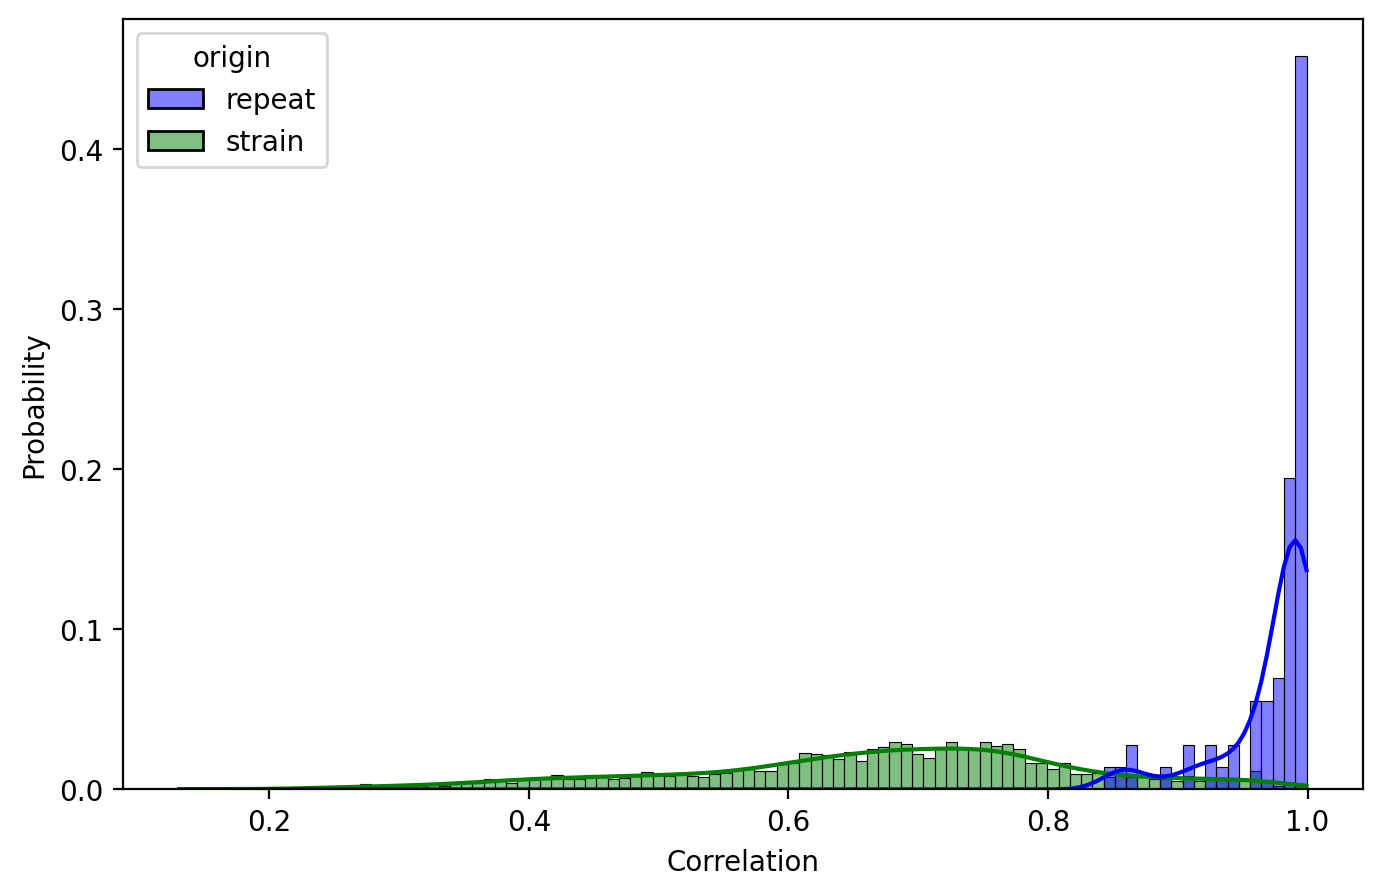

In [98]:
fig,ax = plt.subplots(figsize=(8, 5)) 
sns.histplot(data=a, x='index', hue='origin', common_norm=False, bins=100, kde=True, stat='probability', palette={'repeat': 'blue', 'strain': 'green'})
ax.set_xlabel('Correlation')

### S.Figure 1C

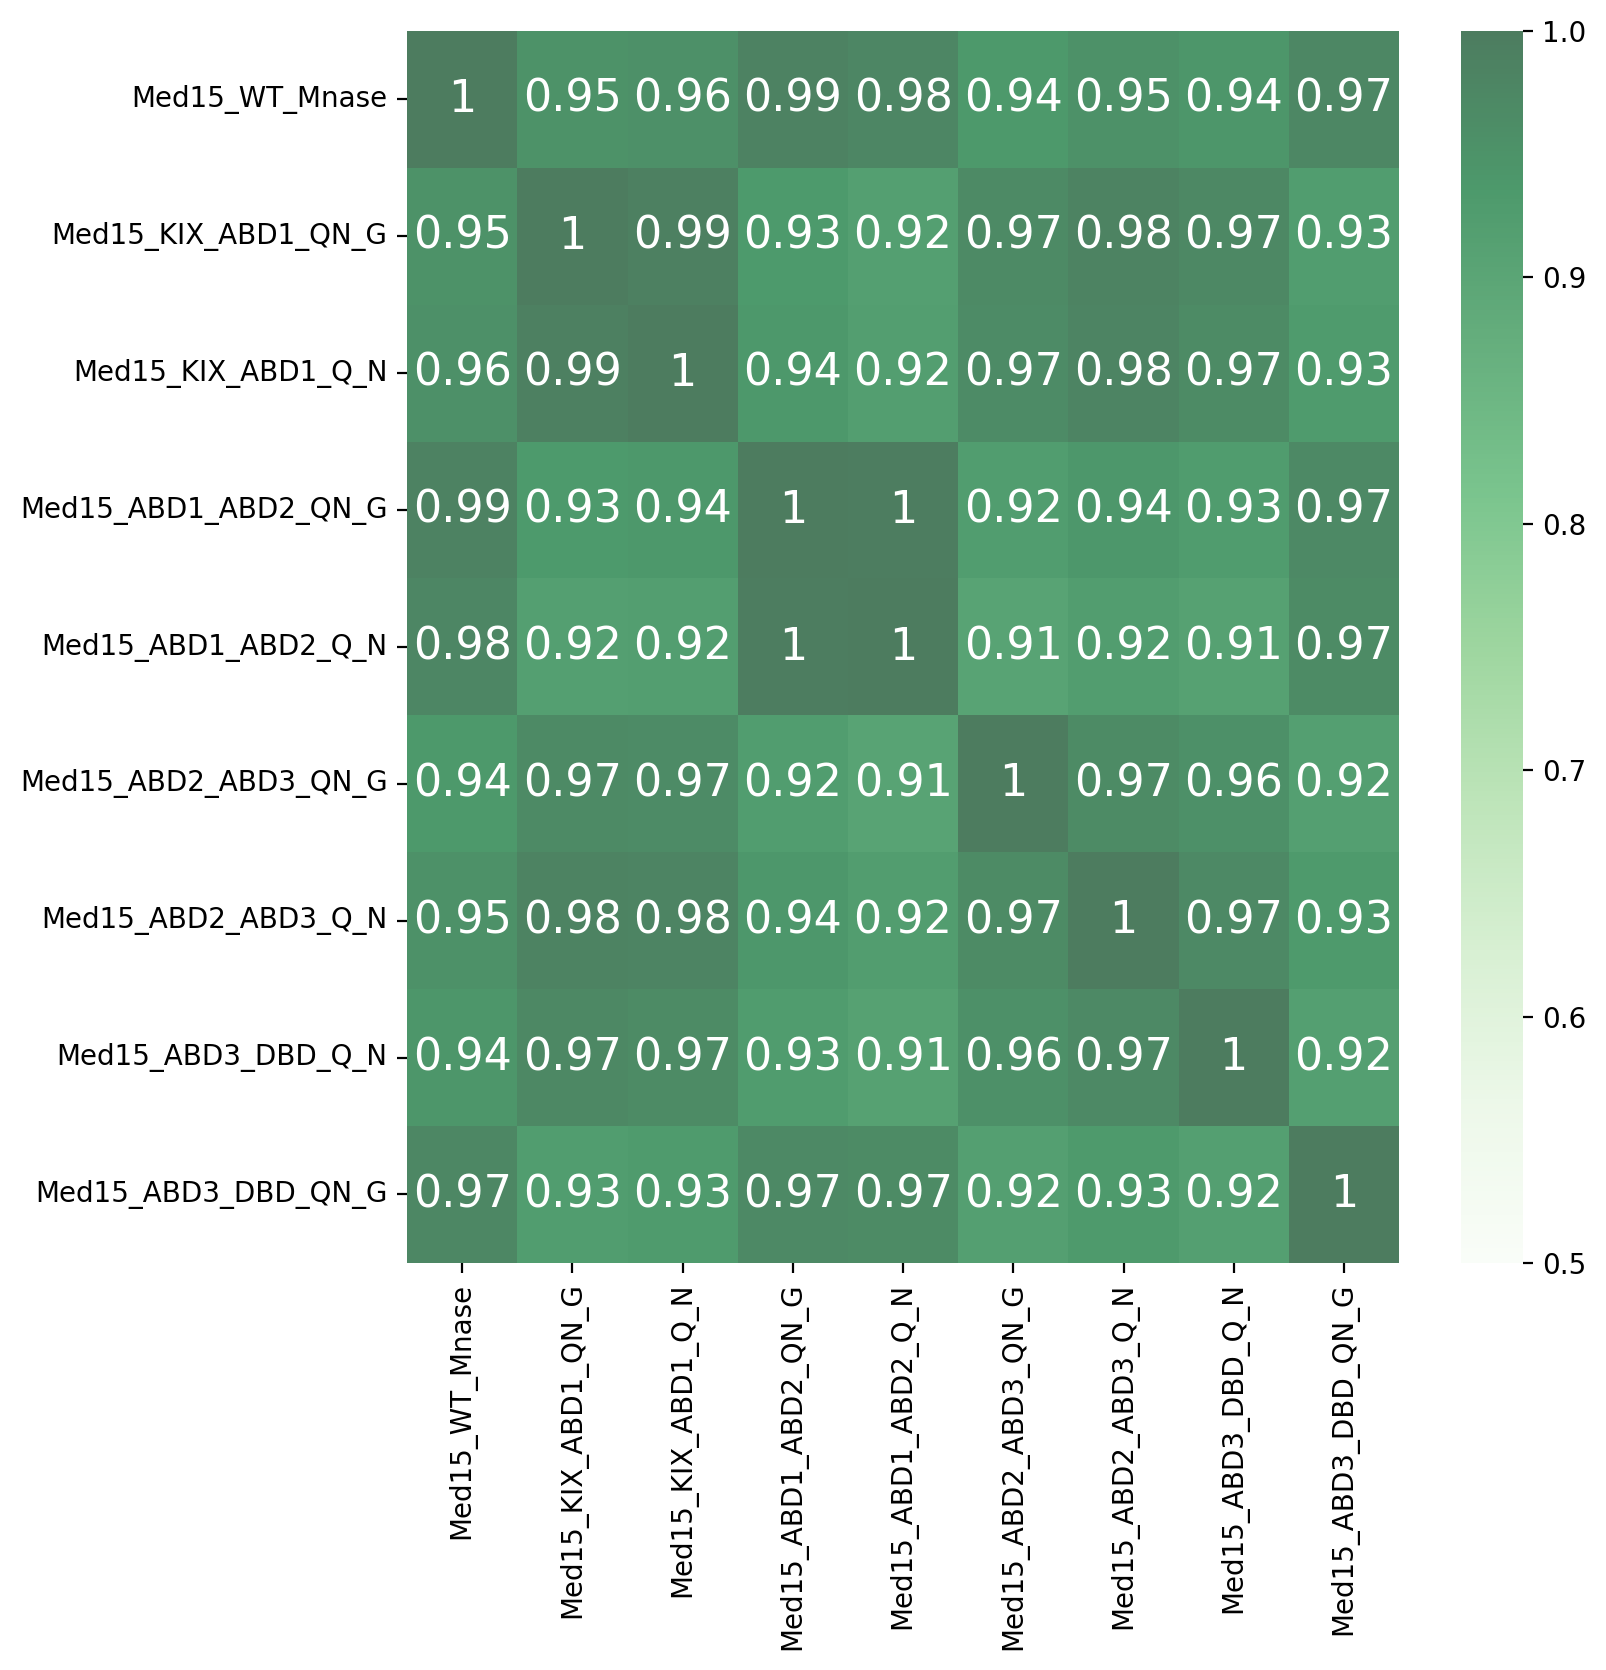

In [108]:
corr_matrix = WT_system_data[['Med15_WT_Mnase','Med15_KIX_ABD1_QN_G', 'Med15_KIX_ABD1_Q_N','Med15_ABD1_ABD2_QN_G', 'Med15_ABD1_ABD2_Q_N','Med15_ABD2_ABD3_QN_G',
       'Med15_ABD2_ABD3_Q_N','Med15_ABD3_DBD_Q_N',
       'Med15_ABD3_DBD_QN_G']].corr()

filtered_corr_matrix = corr_matrix
n = 256  
c = 0.3 
base_cmap = plt.get_cmap("Greens")  
colors = (1. - c) * base_cmap(np.linspace(0., 1., n)) + c * np.ones((n, 4)) 
pastel_cmap = mcolors.LinearSegmentedColormap.from_list("PastelGreens", colors, N=n)
norm = mcolors.Normalize(vmin=0, vmax=1)
plt.subplots(figsize=(8, 8))
heatmap = sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2g", cmap=pastel_cmap, vmax=1, vmin=0.5, annot_kws={"size": 16, 'rotation':0})

plt.show()

# Supplementary Figure 2

### S.Figure 2A

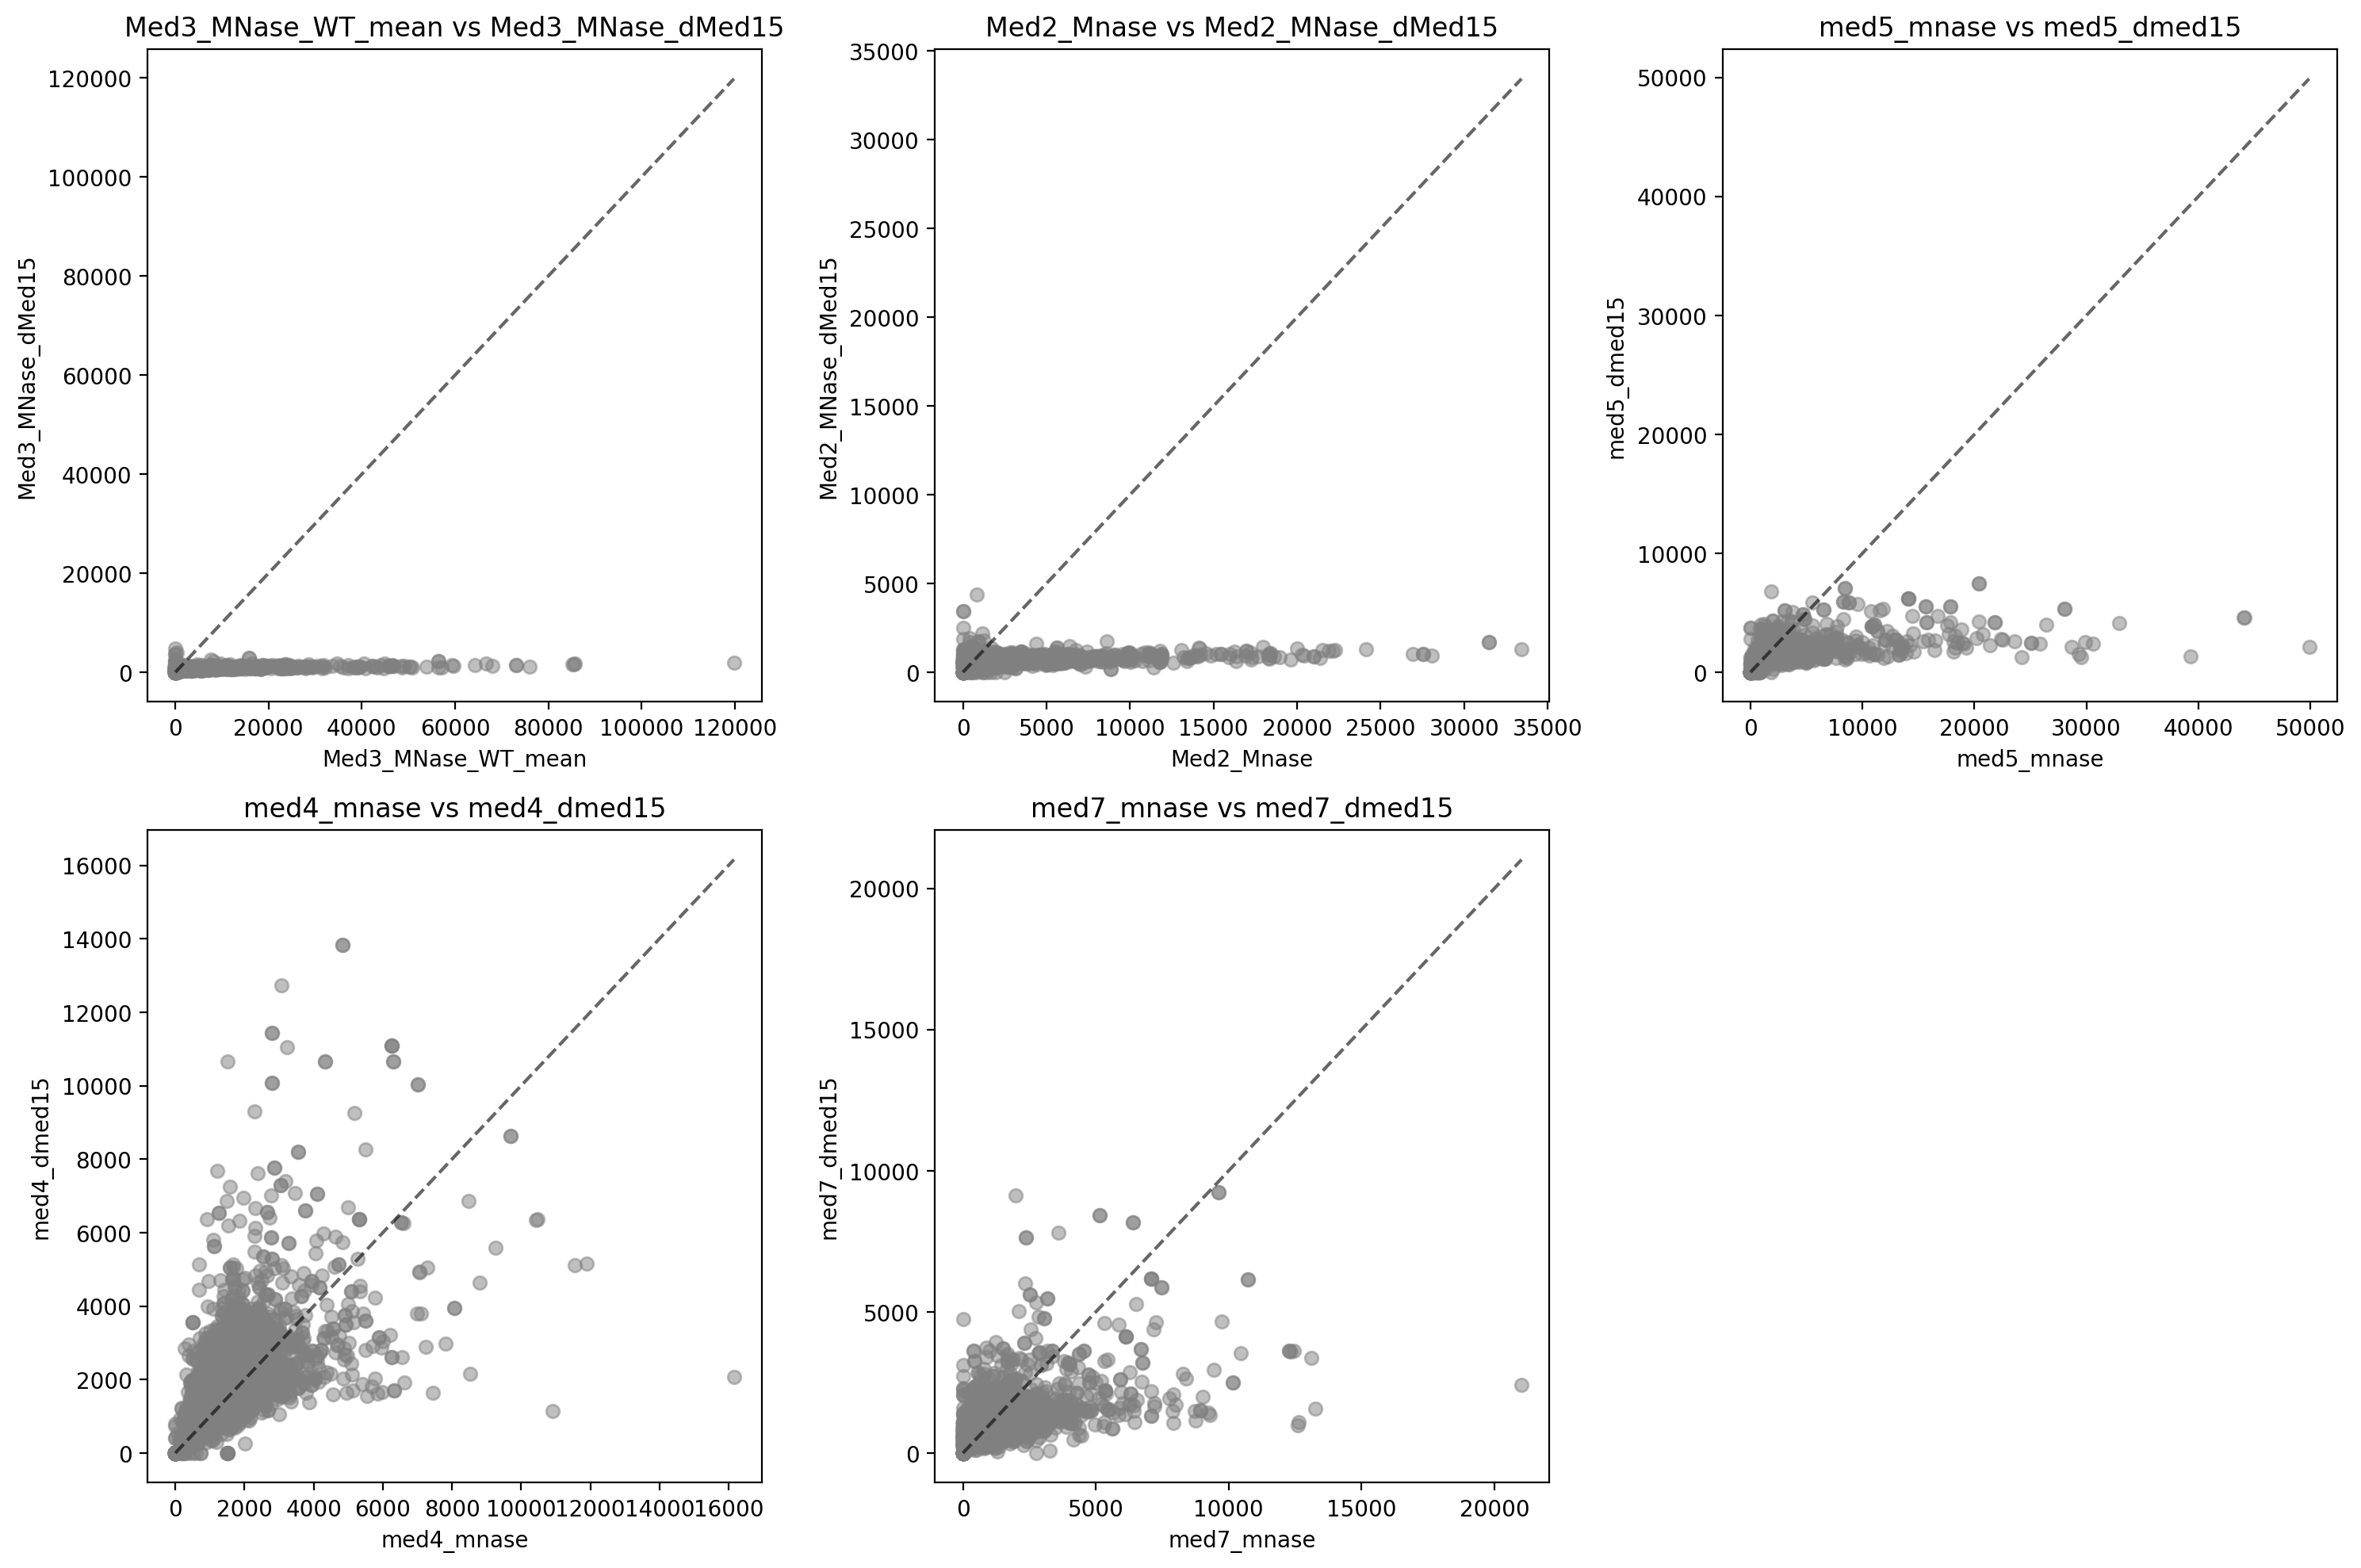

In [114]:
df = WT_system_data[['Med3_MNase_WT_mean','Med3_MNase_dMed15','Med2_Mnase','Med2_MNase_dMed15','med5_mnase','med5_dmed15','med4_mnase','med4_dmed15','med7_mnase','med7_dmed15']]

pairs = []

for col in df.columns:
    if col.endswith('_Mnase') or col.endswith('_mnase') or '_WT' in col:
        base = col.lower().split('_')[0]
     
        matches = [c for c in df.columns if c.lower().startswith(base) and 'dmed15' in c.lower()]
        if matches:
            pairs.append( (col, matches[0]) )


# 3️⃣ Plotting
num_plots = len(pairs)
ncols = 3
nrows = (num_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), squeeze=False)

for ax, (wt_col, dmed15_col) in zip(axes.flatten(), pairs):
    ax.scatter(df[wt_col], df[dmed15_col], alpha=0.5, color='grey', edgecolor='grey', rasterized=True)
    ax.set_xlabel(wt_col)
    ax.set_ylabel(dmed15_col)
    ax.set_title(f'{wt_col} vs {dmed15_col}')
    ax.plot([df[wt_col].min(), df[wt_col].max()], [df[wt_col].min(), df[wt_col].max()], '--', color='black', alpha=0.6)

# Hide any empty subplots
for ax in axes.flatten()[len(pairs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


### S.Figure 2B

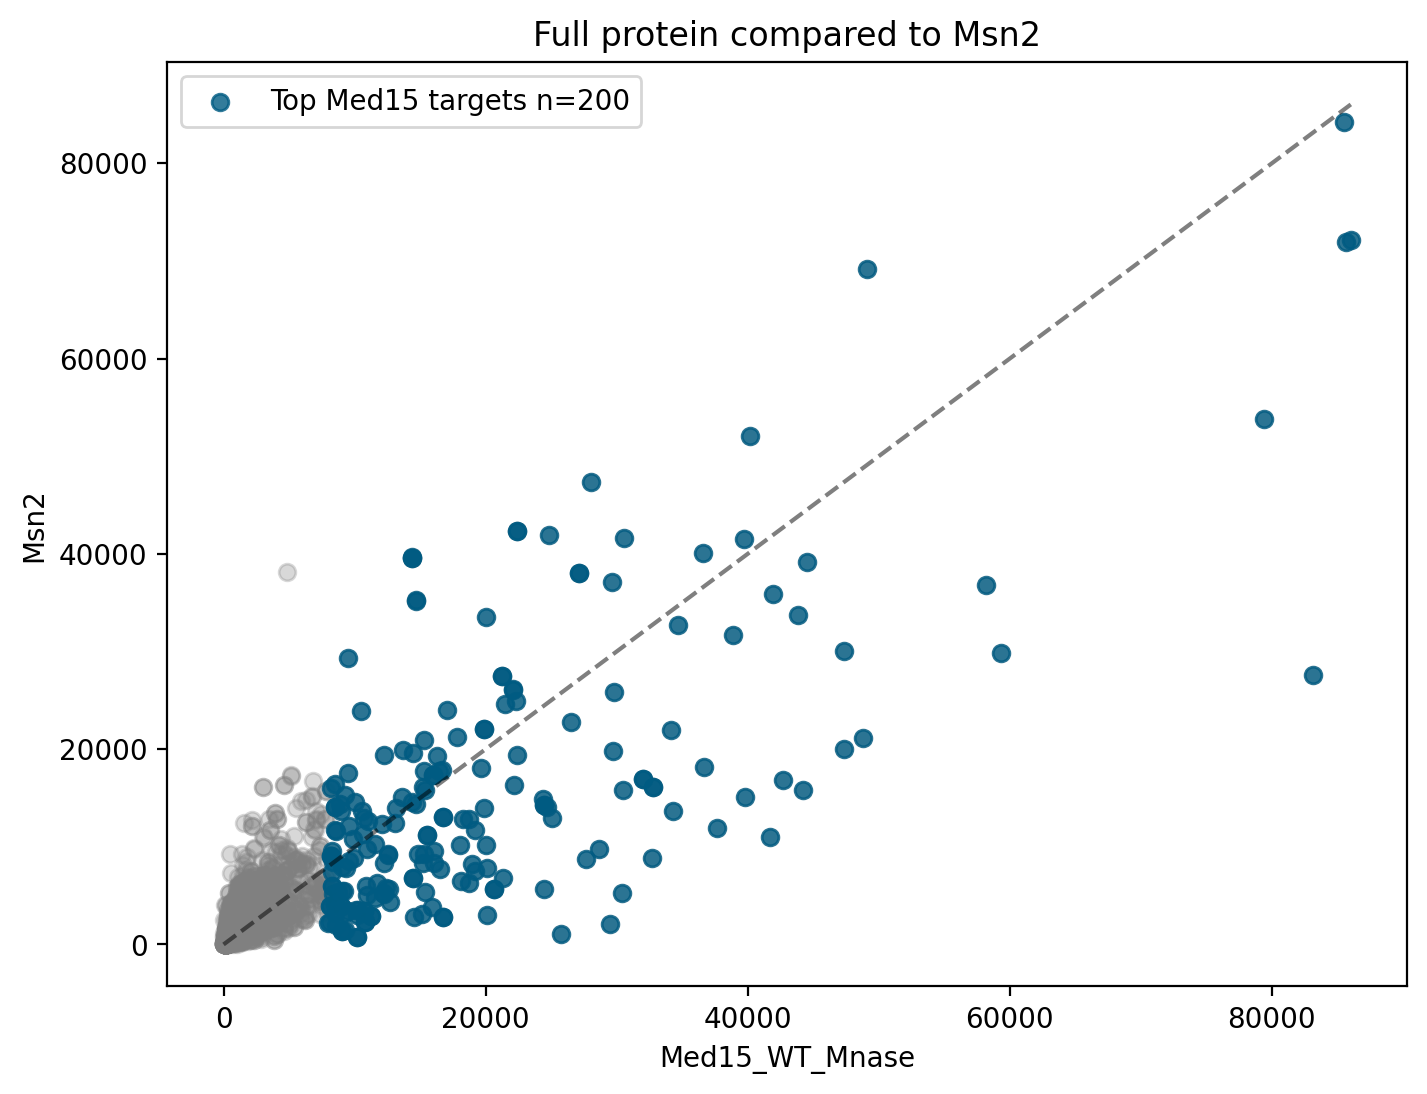

In [115]:
fig, axes = plt.subplots(1, figsize=(8, 6))
plt.scatter(WT_system_data['Med15_WT_Mnase'], WT_system_data['Msn2'], 
        alpha=0.3, 
        color='grey'
    )
plt.scatter(
        WT_system_data['Med15_WT_Mnase'].loc[med15_top_targets], WT_system_data['Msn2'].loc[med15_top_targets],
        alpha=0.8, 
        color='#005b82', edgecolor='#005b82',
        label='Top Med15 targets n=200'
    )

max_val = max(WT_system_data['Msn2'].max(), WT_system_data['Med15_WT_Mnase'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
    
plt.ylabel('Msn2')
plt.xlabel('Med15_WT_Mnase')
plt.legend()
plt.title(f'Full protein compared to Msn2')
plt.show()

### S.Figure 2C

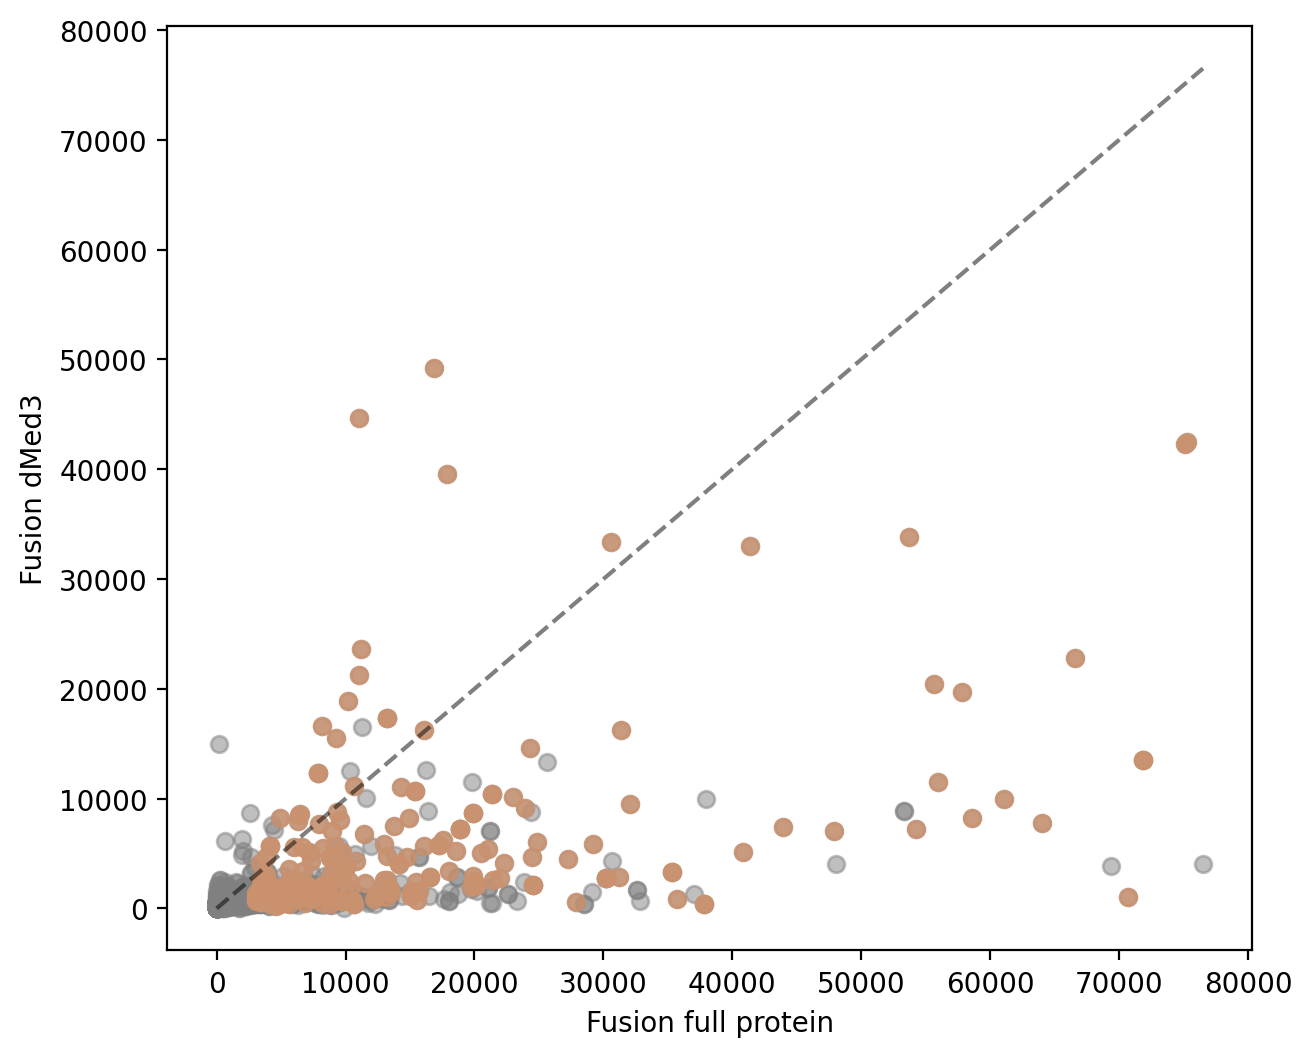

In [116]:
fig, axes = plt.subplots(1, figsize=(7, 6))
plt.scatter( d12_system_data['med15_msn2dbd_mnase'], d12_system_data['d12_Med15_Msn2DBD_dMed3'],
        alpha=0.5, 
        color='grey'
    )
plt.scatter(
         d12_system_data['med15_msn2dbd_mnase'].loc[lost_in_d12_gained_in_fusion],d12_system_data['d12_Med15_Msn2DBD_dMed3'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(d12_system_data['med15_msn2dbd_mnase'].max(), d12_system_data['d12_Med15_Msn2DBD_dMed3'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
plt.ylabel('Fusion dMed3')
plt.xlabel('Fusion full protein')
plt.show()

### S.Figure 2D

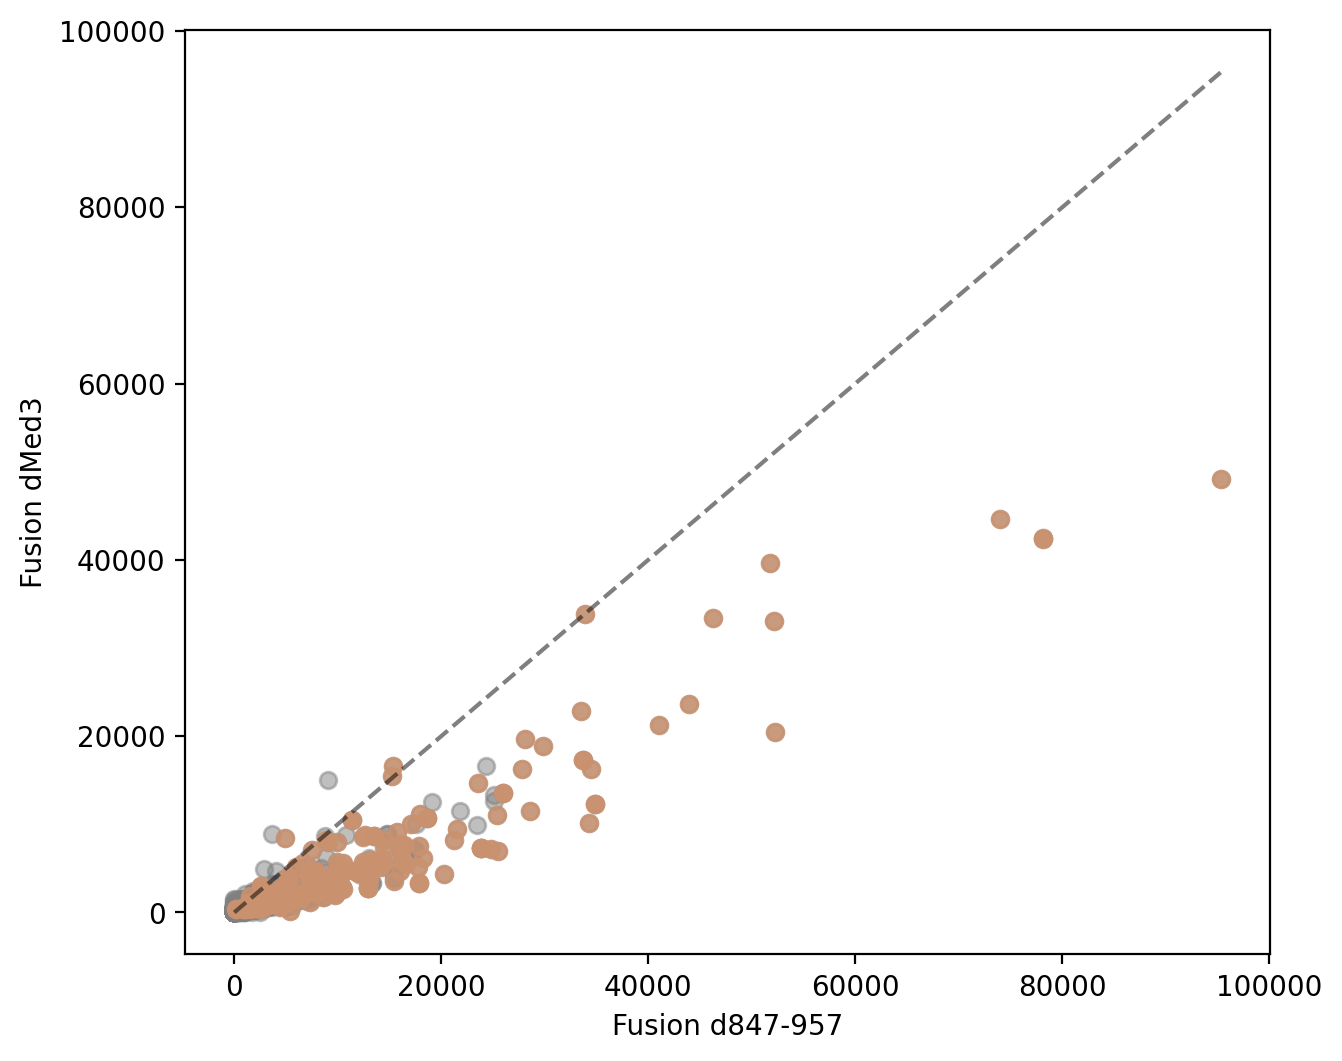

In [117]:
fig, axes = plt.subplots(1, figsize=(7, 6))
plt.scatter( d12_system_data['dDBD'], d12_system_data['d12_Med15_Msn2DBD_dMed3'],
        alpha=0.5, 
        color='grey'
    )
plt.scatter(
         d12_system_data['dDBD'].loc[lost_in_d12_gained_in_fusion],d12_system_data['d12_Med15_Msn2DBD_dMed3'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(d12_system_data['dDBD'].max(), d12_system_data['d12_Med15_Msn2DBD_dMed3'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
plt.ylabel('Fusion dMed3')
plt.xlabel('Fusion d847-957')
plt.show()

### S.Figure 2E

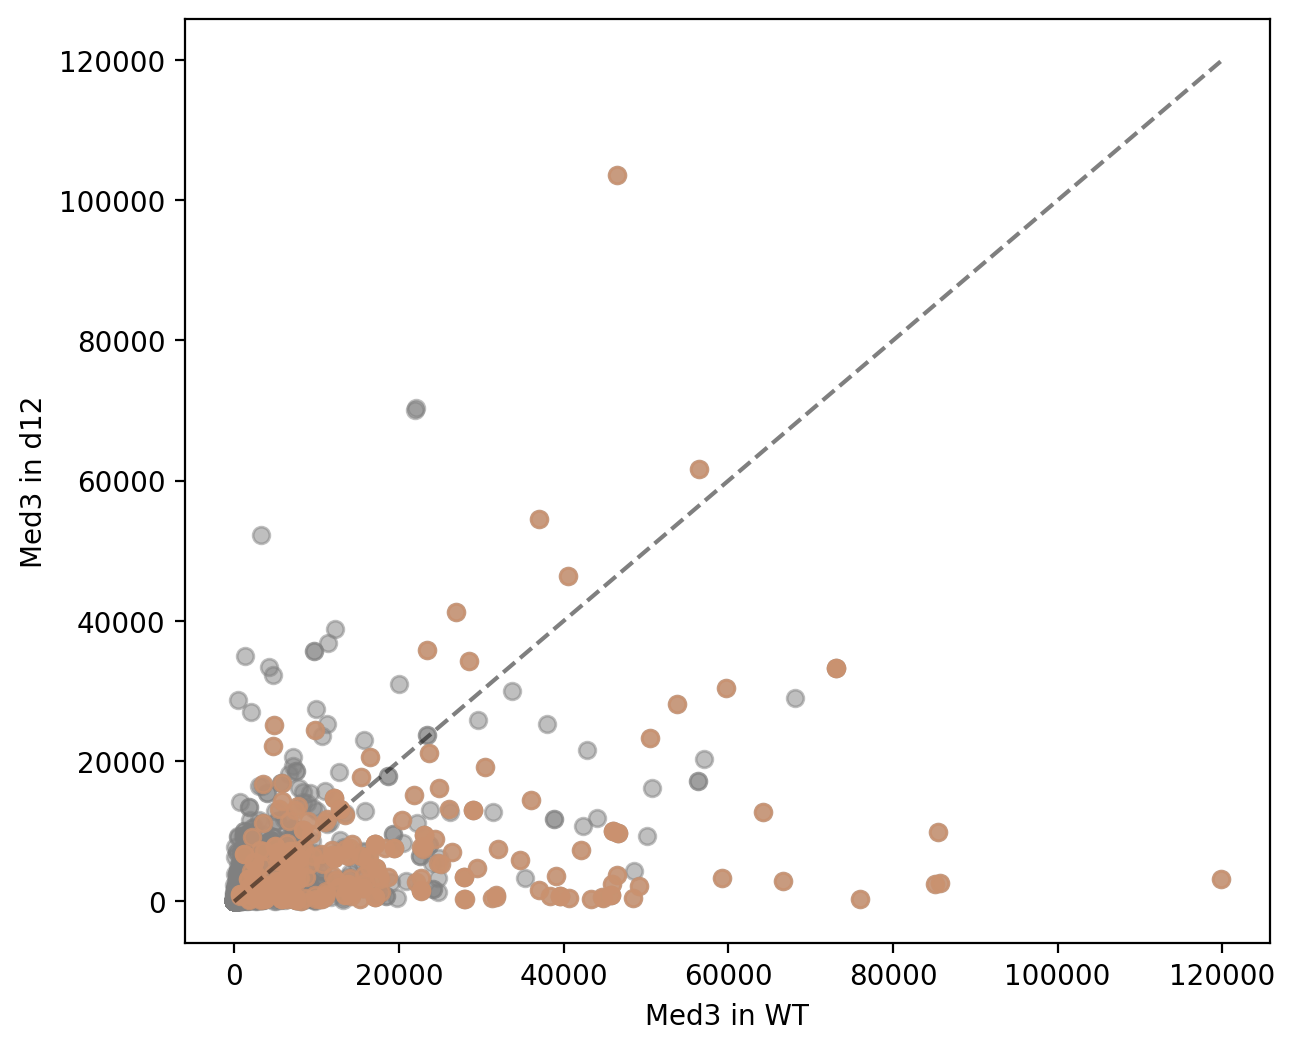

In [119]:
fig, axes = plt.subplots(1, figsize=(7, 6))
plt.scatter( WT_system_data['Med3_MNase_WT_mean'], d12_system_data['d12_Med3_Mnase'],
        alpha=0.5, 
        color='grey'
    )
plt.scatter(
         WT_system_data['Med3_MNase_WT_mean'].loc[lost_in_d12_gained_in_fusion],d12_system_data['d12_Med3_Mnase'].loc[lost_in_d12_gained_in_fusion],
        alpha=0.8, 
        color='#CB926F', edgecolor='#CB926F',
        label='Lost in d12, gained in fusion',rasterized=True
    )

max_val = max(WT_system_data['Med3_MNase_WT_mean'].max(), d12_system_data['d12_Med3_Mnase'].max())
plt.plot([0, max_val], [0, max_val], '--', color='black', alpha=0.5)
plt.ylabel('Med3 in d12')
plt.xlabel('Med3 in WT')
plt.show()